In [1691]:
import requests
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

%matplotlib inline

## Updating the dataset

In [1692]:
time_series_ncov_confirmed = requests.get('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

with open('../data/time_series_covid19_confirmed_global.csv', 'wb') as f:
    f.write(time_series_ncov_confirmed.content)

In [1693]:
time_series_ncov_deaths = requests.get('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
with open('../data/time_series_covid19_deaths_global.csv', 'wb') as f:
    f.write(time_series_ncov_deaths.content)

## Reading and organizing the dataset

In [1694]:
corona_cases = pd.read_csv('../data/time_series_covid19_confirmed_global.csv')
corona_cases = corona_cases.rename(columns={"Province/State": "province", "Country/Region": "location"})
corona_cases = corona_cases.fillna(0)
corona_cases.location[corona_cases.location == 'US'] = 'United States of America'
# Change from wide form to narrow
corona_cases = corona_cases.melt(id_vars=['province', 'location', 'Lat', 'Long'], var_name='date', value_name="total_cases")
corona_cases['date'] = pd.to_datetime(corona_cases['date'])

corona_cases = corona_cases[corona_cases.total_cases > 0]
corona_cases = corona_cases.sort_values(['date', 'total_cases'])
corona_cases.head()

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


province location      Lat      Long       date  total_cases
49    Anhui    China  31.8257  117.2264 2020-01-22            1
52   Fujian    China  26.0789  117.9874 2020-01-22            1
56  Guizhou    China  26.8154  106.8748 2020-01-22            1
58    Hebei    China  39.5490  116.1306 2020-01-22            1
65  Jiangsu    China  32.9711  119.4550 2020-01-22            1

In [1695]:
corona_cases.shape

(7901, 6)

In [1696]:
death_dataset = pd.read_csv('../data/time_series_covid19_deaths_global.csv')
death_dataset = death_dataset.rename(columns={"Province/State": "province", "Country/Region": "location"})
death_dataset = death_dataset.fillna(0)
death_dataset.location[death_dataset.location == 'US'] = 'United States of America'
# Change from wide form to narrow
death_dataset = death_dataset.melt(id_vars=['province', 'location', 'Lat', 'Long'], var_name='date', value_name="total_deaths")
death_dataset['date'] = pd.to_datetime(death_dataset['date'])

death_dataset = death_dataset[death_dataset.total_deaths > 0]
death_dataset = death_dataset.sort_values(['date', 'total_deaths'])
death_dataset.head()

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


province location      Lat      Long       date  total_deaths
62          Hubei    China  30.9756  112.2707 2020-01-22            17
311         Hebei    China  39.5490  116.1306 2020-01-23             1
315         Hubei    China  30.9756  112.2707 2020-01-23            17
564         Hebei    China  39.5490  116.1306 2020-01-24             1
565  Heilongjiang    China  47.8620  127.7615 2020-01-24             1

In [1697]:
# Summing up the total_cases for the countries that are seprated by province

countries = corona_cases[corona_cases.province != 0].location.unique().tolist()
for country in countries:
    
    total = {
        'location': country,
        'province': country,
        'date': corona_cases[corona_cases.location == country].date.max(),
        'total_cases': sum(corona_cases.total_cases[(corona_cases.location == country) & (corona_cases.date == corona_cases[corona_cases.location == country].date.max())])
    }
    corona_cases = corona_cases.append(total, ignore_index=True)

In [1698]:
# Summing up the total_cases for the countries that are seprated by province

countries = death_dataset[death_dataset.province != 0].location.unique().tolist()
for country in countries:
    
    total = {
        'location': country,
        'province': country,
        'date': death_dataset[death_dataset.location == country].date.max(),
        'total_deaths': sum(death_dataset.total_deaths[(death_dataset.location == country) & (death_dataset.date == death_dataset[death_dataset.location == country].date.max())])
    }
    death_dataset = death_dataset.append(total, ignore_index=True)

## Cases of Corona virus excluding China

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


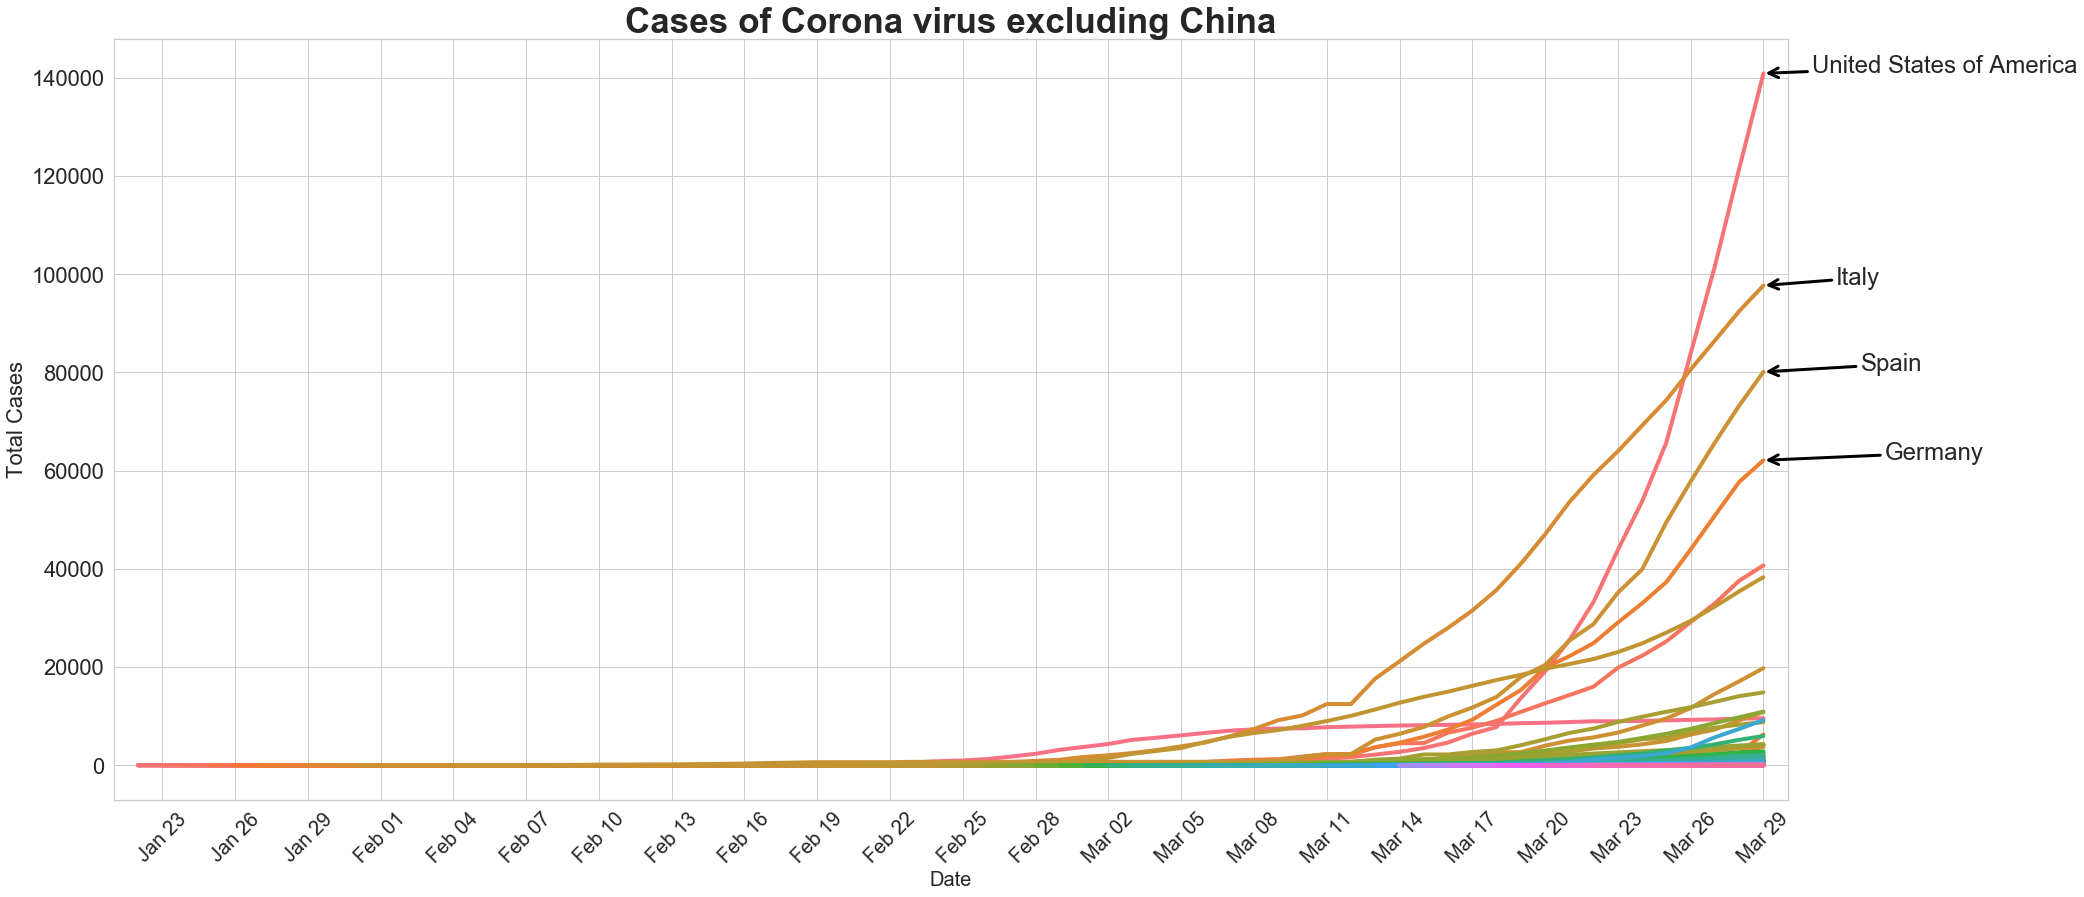

In [1798]:
no_china_dataset = corona_cases[corona_cases['location'] != 'China']
no_china_dataset = no_china_dataset.sort_values(['date', 'location']).drop_duplicates(subset =['date', 'location'], keep = 'last') 
highest_countries = no_china_dataset.nlargest(6, ['date', 'total_cases']).reset_index()


plt.figure(figsize = (30, 14))

ax = sns.lineplot(x="date", y="total_cases", hue="location", legend=False,  data=no_china_dataset, linewidth=4 )

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

ax.set_xlim([no_china_dataset.date.min() - datetime.timedelta(days=1), no_china_dataset.date.max() + datetime.timedelta(days=1)])

plt.title('Cases of Corona virus excluding China', fontsize = 35, weight='bold')

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)


plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)

for i in range(4):
    ax.annotate(highest_countries.iloc[i].location, 
                xy=(no_china_dataset.date.max(), highest_countries.iloc[i].total_cases), fontsize=24,
                xytext=(no_china_dataset.date.max() + datetime.timedelta(days=(2 + i)),
                        highest_countries.iloc[i].total_cases + (200)), 
                arrowprops=dict(facecolor='black', arrowstyle="->", color='black', linewidth=3));

## Excluding outliers, (Italy, US, Germany, Spain)

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


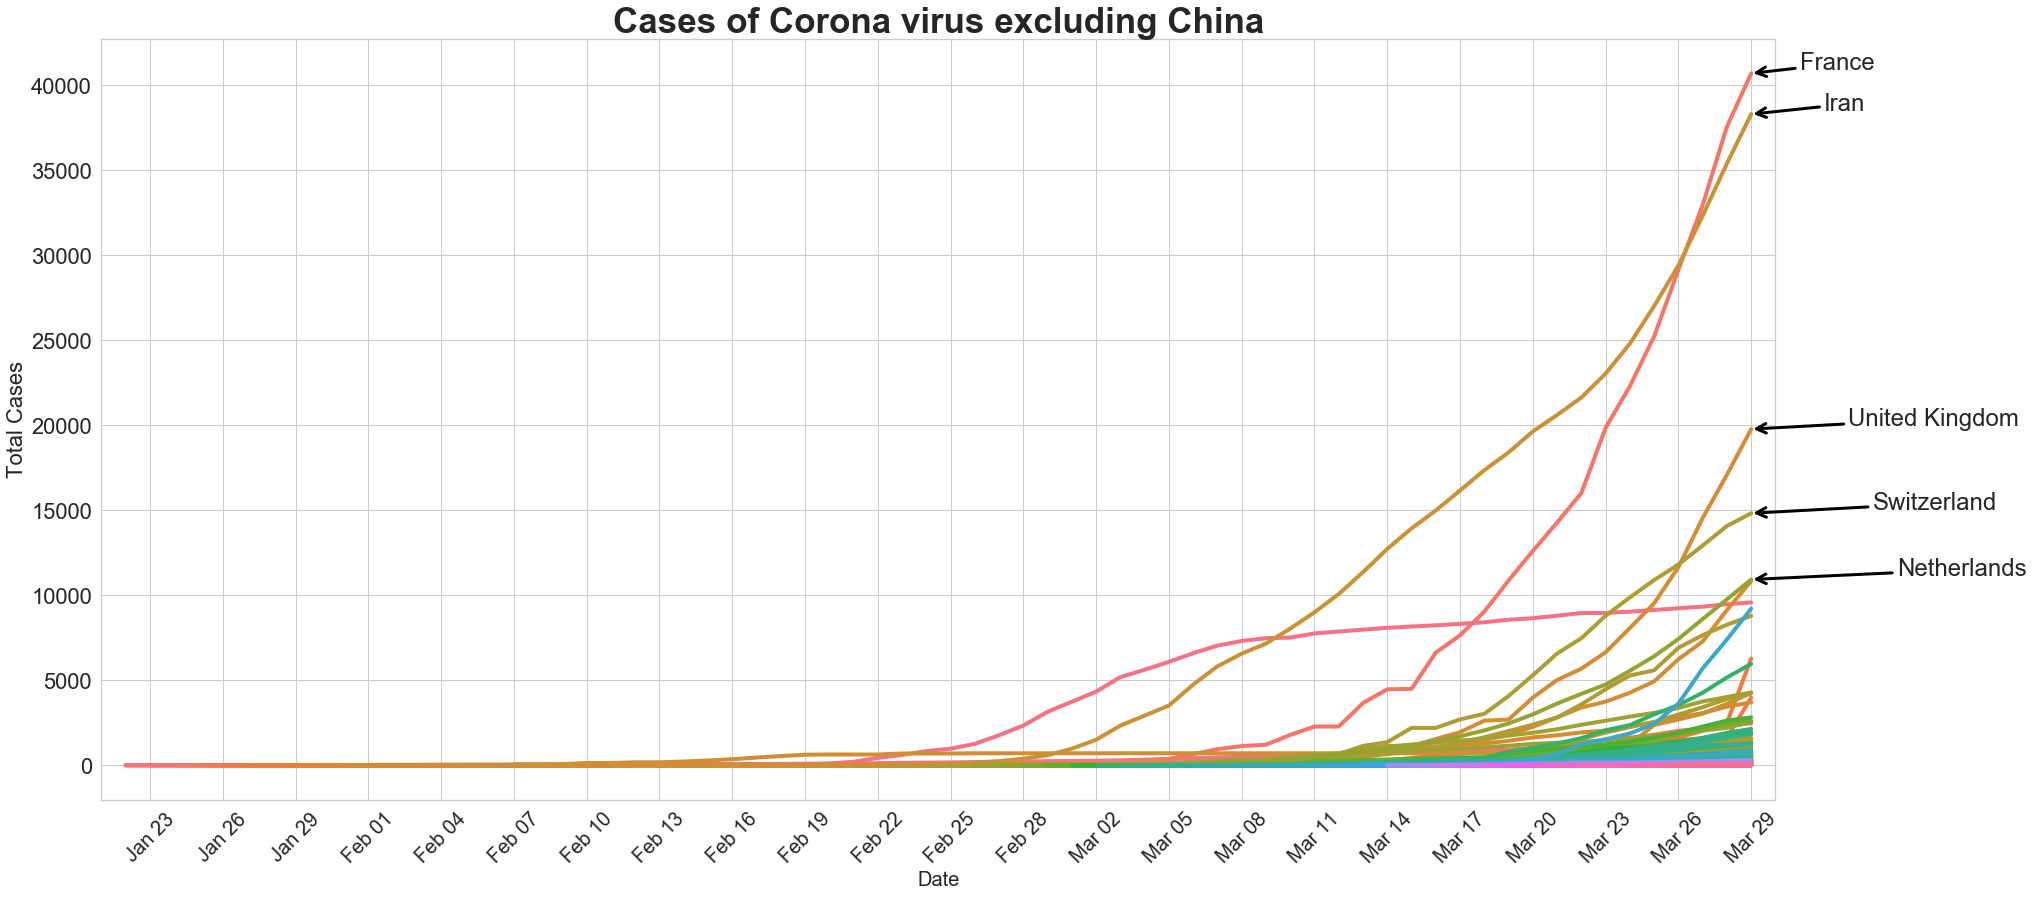

In [1799]:
no_outliers = no_china_dataset[~ no_china_dataset['location'].isin(['Italy', 'United States of America', 'Spain', 'Germany']) ]


highest_no_outliers = no_outliers.nlargest(6, ['date', 'total_cases']).reset_index()

plt.figure(figsize = (30, 14))
sns.set_style("whitegrid")
ax = sns.lineplot(x="date", y="total_cases", hue="location", legend=False,  data=no_outliers, linewidth=4)

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

ax.set_xlim([no_outliers.date.min() - datetime.timedelta(days=1), no_outliers.date.max() + datetime.timedelta(days=1)])
plt.title('Cases of Corona virus excluding China', fontsize = 35, weight='bold')

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)

plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)

for i in range(5):
    ax.annotate(highest_no_outliers.iloc[i].location, 
                xy=(no_outliers.date.max(), highest_no_outliers.iloc[i].total_cases), fontsize=24,
                xytext=(no_outliers.date.max() + datetime.timedelta(days=(2 + i)),
                        highest_no_outliers.iloc[i].total_cases + (200)), 
                arrowprops=dict(facecolor='black', arrowstyle="->", color='black', linewidth=3));

## Chinese Cities Corona Virus Spread

In [1702]:
china_cities = corona_cases[corona_cases['location'] == 'China']
china_cities = china_cities[china_cities['province'] != 'China']
china_cities = china_cities[china_cities['province'] != 'Hubei']
china_cities_highest = china_cities.nlargest(4, ['date', 'total_cases']).reset_index()

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


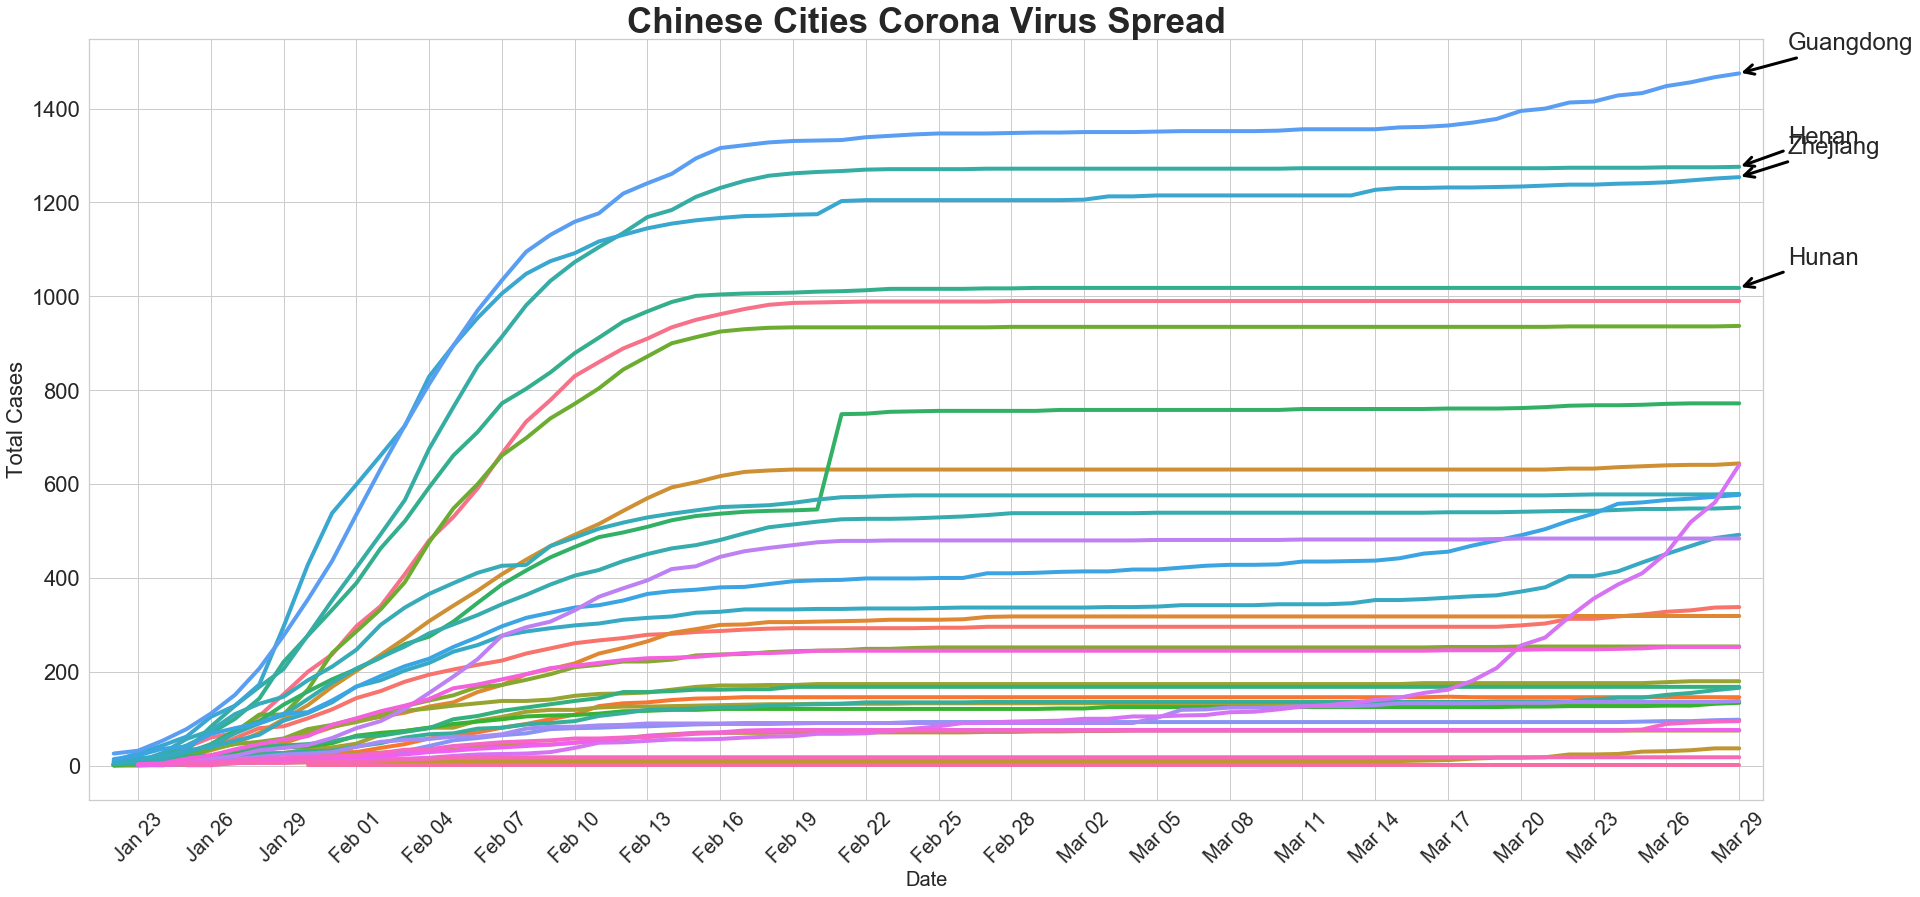

In [1703]:
plt.figure(figsize = (30, 14))
plt.title('Chinese Cities Corona Virus Spread', fontsize=35, weight='bold')
sns.set_style("whitegrid")

ax = sns.lineplot(x="date", y="total_cases", hue="province", legend=False,  data=china_cities, linewidth=4)

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

ax.set_xlim([china_cities.date.min() - datetime.timedelta(days=1), china_cities.date.max() + datetime.timedelta(days=1)])

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)

plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)

for i in range(4):
    ax.annotate(china_cities_highest.iloc[i].province, 
                xy=(china_cities.date.max(), china_cities_highest.iloc[i].total_cases), fontsize=24,
                xytext=(china_cities.date.max() + datetime.timedelta(days=2),
                        china_cities_highest.iloc[i].total_cases + 50), 
                arrowprops=dict(facecolor='black', arrowstyle="->", color='black', linewidth=3));

## Weather data

In [1704]:
def get_weather_data(date, location):
    try:
        path = '../weather_data/{}.csv'.format(location)
        weather_data = pd.read_csv(path, usecols=['date_time', 'tempC'], parse_dates=['date_time'])
        temp = weather_data.tempC[weather_data.date_time == date]
        return temp.mean()
    except FileNotFoundError:
        return 'na', 'na', 'na'

In [1461]:
def get_humidity_data(date, location):
    try:
        path = '../weather_data/{}.csv'.format(location)
        weather_data = pd.read_csv(path, usecols=['date_time', 'humidity'], parse_dates=['date_time'])
        humidity = weather_data.humidity[weather_data.date_time == date]
        return humidity.mean()
    except FileNotFoundError:
        return 'na', 'na', 'na'

### Chian

In [1477]:
china_cities = corona_cases[corona_cases['location'] == 'China']
china_cities = china_cities[china_cities['province'] != 'China']
# new_cases function is implemented a few blocks below
china_cities['new_cases'] = china_cities.apply(lambda x: new_cases(x['date'], x['total_cases'], province=x['province']), axis=1)

china_cities['temp'] = china_cities.apply(lambda x: get_weather_data(x['date'], x['province']), axis=1)
china_cities['humidity'] = china_cities.apply(lambda x: get_humidity_data(x['date'], x['province']), axis=1)


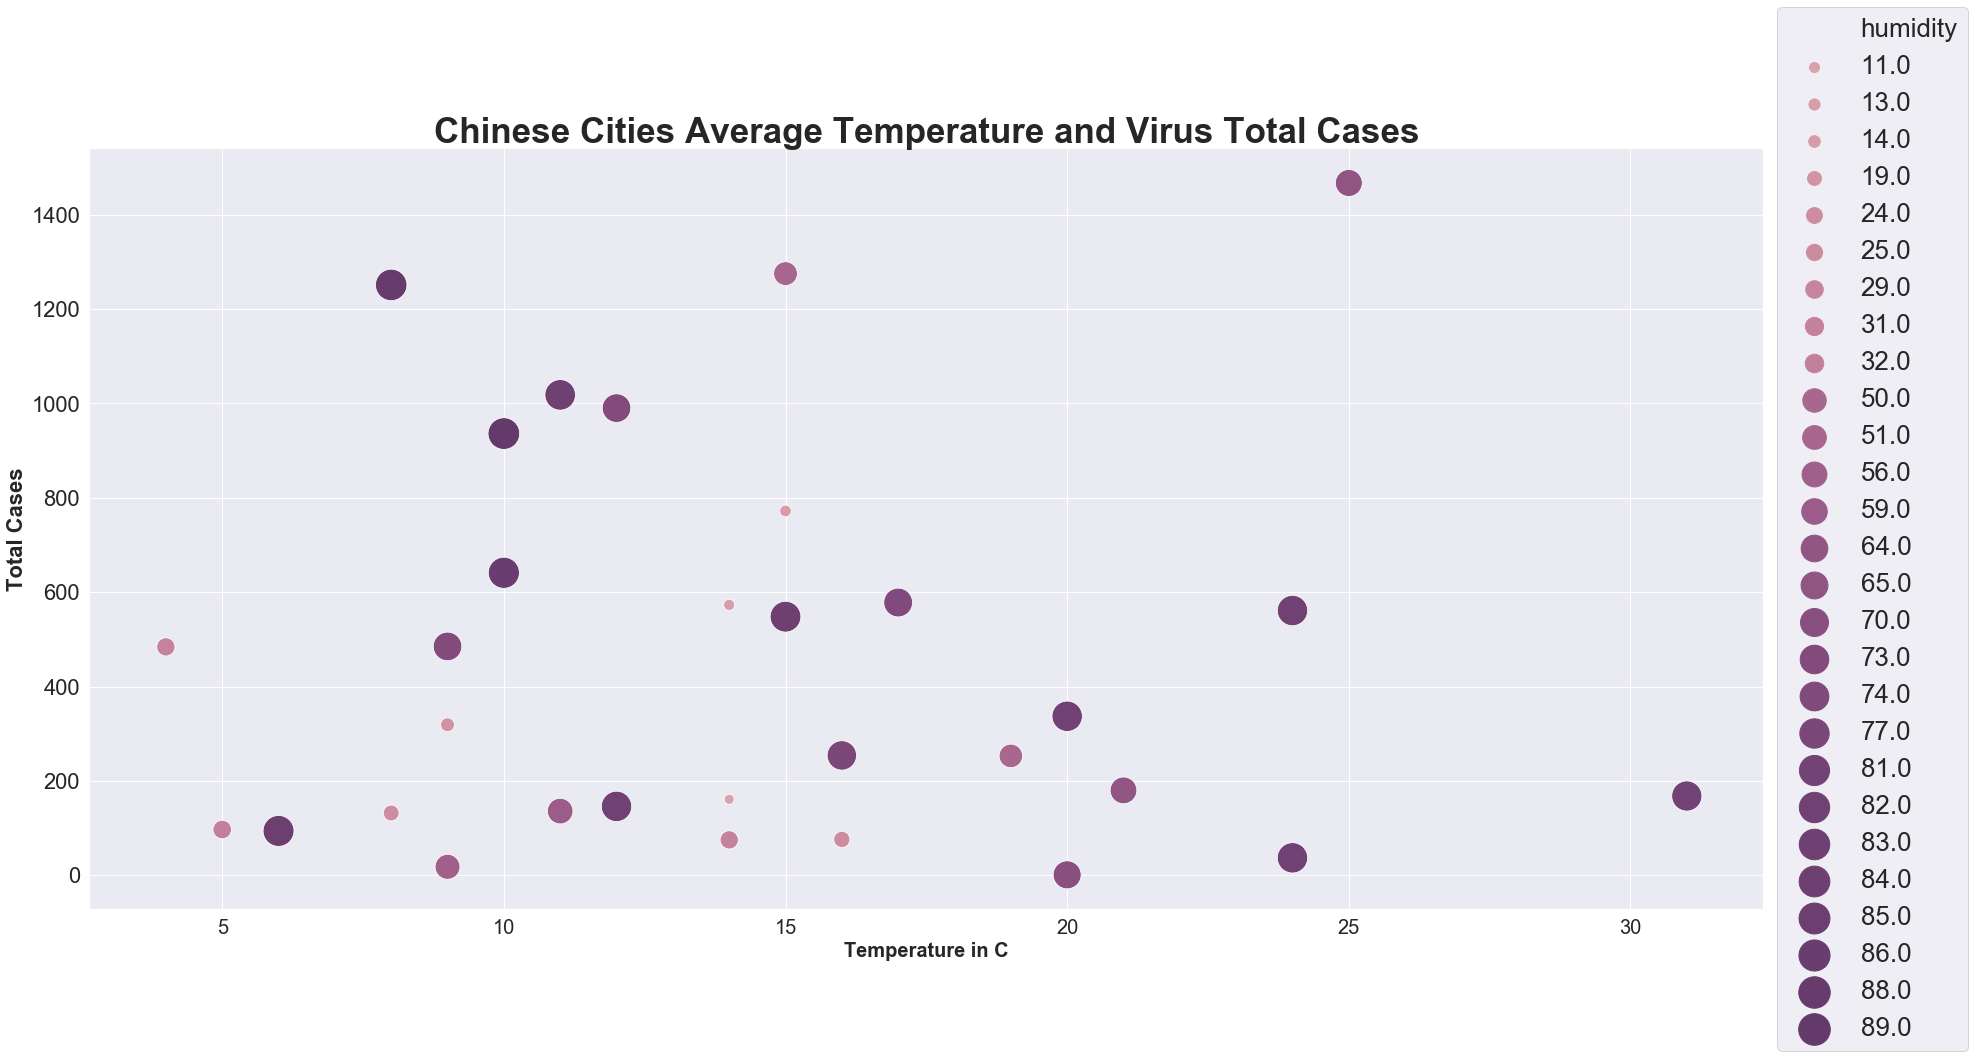

In [1480]:
plt.figure(figsize = (30, 14))
plt.title('Chinese Cities Average Temperature and Virus Total Cases', fontsize=35, weight='bold')
cmap = sns.cubehelix_palette(dark=.3, light=.7, as_cmap=True)
ax = sns.scatterplot(x="temp", y="total_cases", hue='humidity', legend='full',  data=china_cities[(china_cities['province'] != 'Hubei') & (china_cities.date == china_cities.date.max())], size='humidity', palette=cmap, sizes=(100, 1000))
sns.set(font_scale = 2)

# ax.set_xlim([china_cities.temp.min() - 1, china_cities.temp.max() + 1])
ax.legend(loc='center right', bbox_to_anchor=(1.13, 0.5), ncol=1, prop={'size':26});

plt.xticks(fontsize =20)
plt.yticks(fontsize =22)

plt.xlabel('Temperature in C', fontsize =20, weight='bold')
plt.ylabel('Total Cases', fontsize =22, weight='bold');

### Australia

In [1483]:
australia = corona_cases[corona_cases['province'].isin(['New South Wales', 'Victoria', 'Queensland', 'Australian Capital Territory', 'Northern Territory', 'South Australia', 'Tasmania', 'Western Australia'])]
# new_cases function is implemented a few blocks below
australia['new_cases'] = australia.apply(lambda x: new_cases(x['date'], x['total_cases'], province=x['province']), axis=1)

australia['temp'] = australia.apply(lambda x: get_weather_data(x['date'], x['province']), axis=1)
australia['humidity'] = australia.apply(lambda x: get_humidity_data(x['date'], x['province']), axis=1)



/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

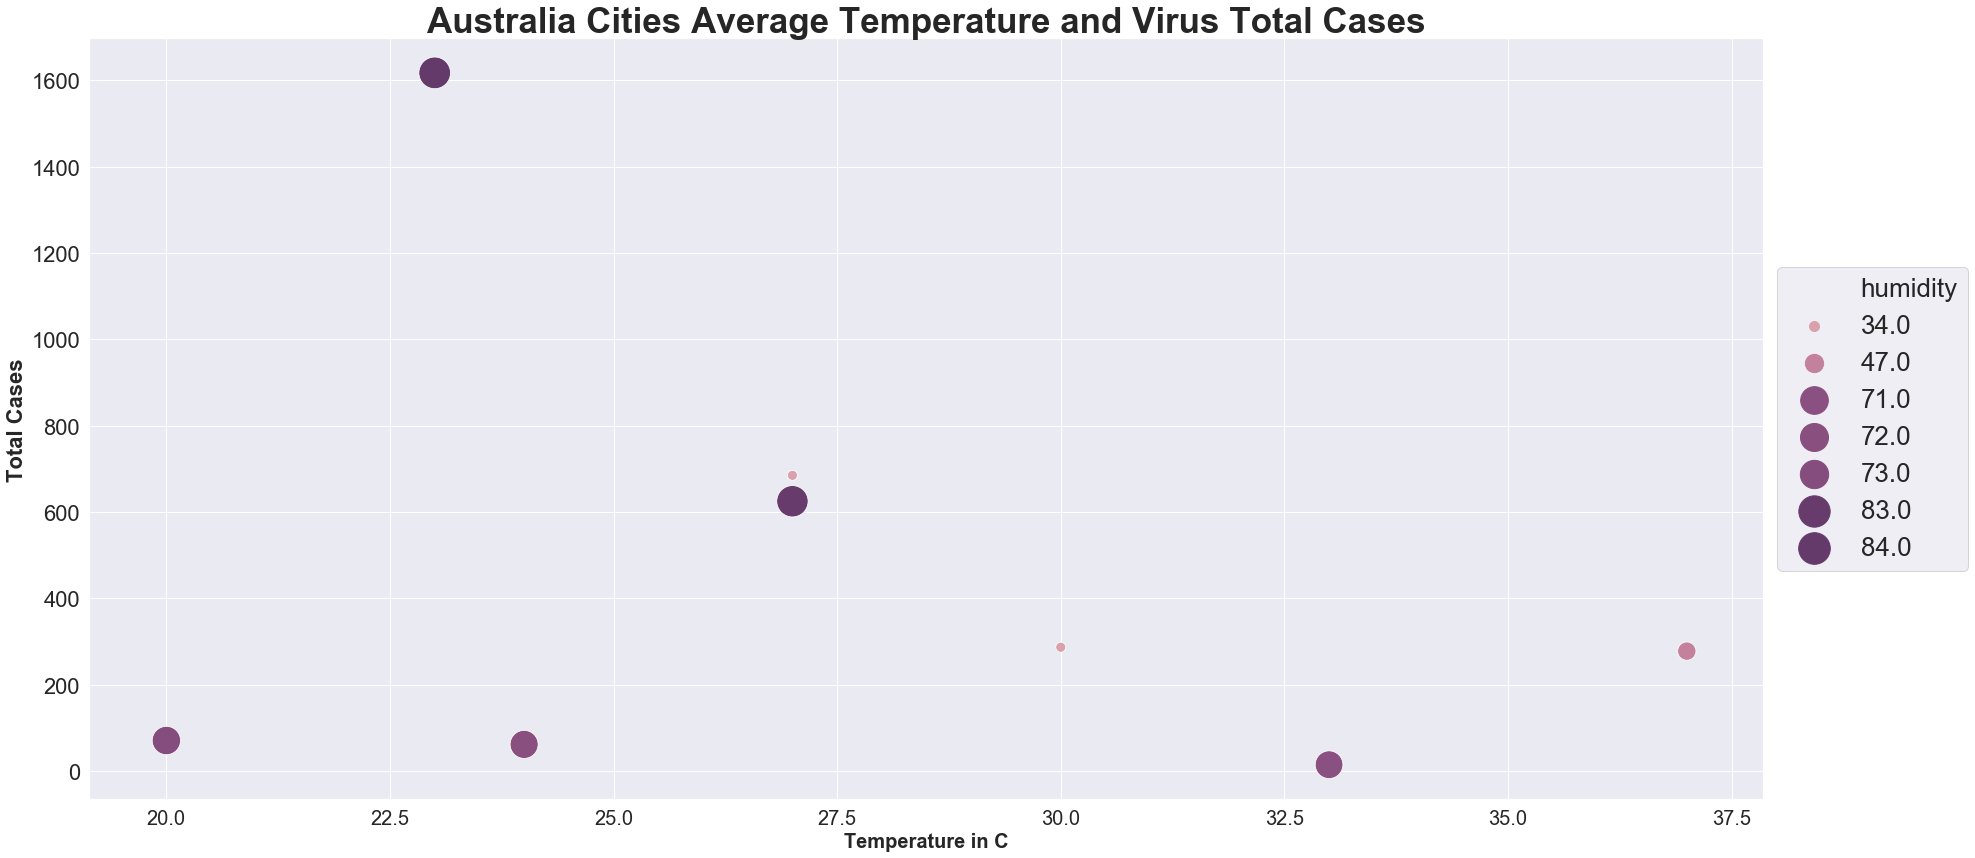

In [1484]:
plt.figure(figsize = (30, 14))
plt.title('Australia Cities Average Temperature and Virus Total Cases', fontsize=35, weight='bold')
cmap = sns.cubehelix_palette(dark=.3, light=.7, as_cmap=True)
ax = sns.scatterplot(x="temp", y="total_cases", hue='humidity', legend='full',  data=australia[(australia.date == china_cities.date.max())], size='humidity', palette=cmap, sizes=(100, 1000))
sns.set(font_scale = 2)

# ax.set_xlim([china_cities.temp.min() - 1, china_cities.temp.max() + 1])
ax.legend(loc='center right', bbox_to_anchor=(1.13, 0.5), ncol=1, prop={'size':26});

plt.xticks(fontsize =20)
plt.yticks(fontsize =22)

plt.xlabel('Temperature in C', fontsize =20, weight='bold')
plt.ylabel('Total Cases', fontsize =22, weight='bold');

## Italy, Iran, Spain, Germany V.S China Cities ( exluding Hubei )

In [1705]:
world_vs_china = corona_cases[corona_cases['location'].isin(['Italy', 'Iran', 'Spain', 'Germany', 'China'])]
world_vs_china = world_vs_china[world_vs_china.province != 'China']
world_vs_china.location[world_vs_china['location'] == 'China'] = world_vs_china.province[world_vs_china['location'] == 'China']
world_vs_china = world_vs_china[world_vs_china.location != 'Hubei']
world_highest = world_vs_china.nlargest(4, ['date', 'total_cases']).reset_index()

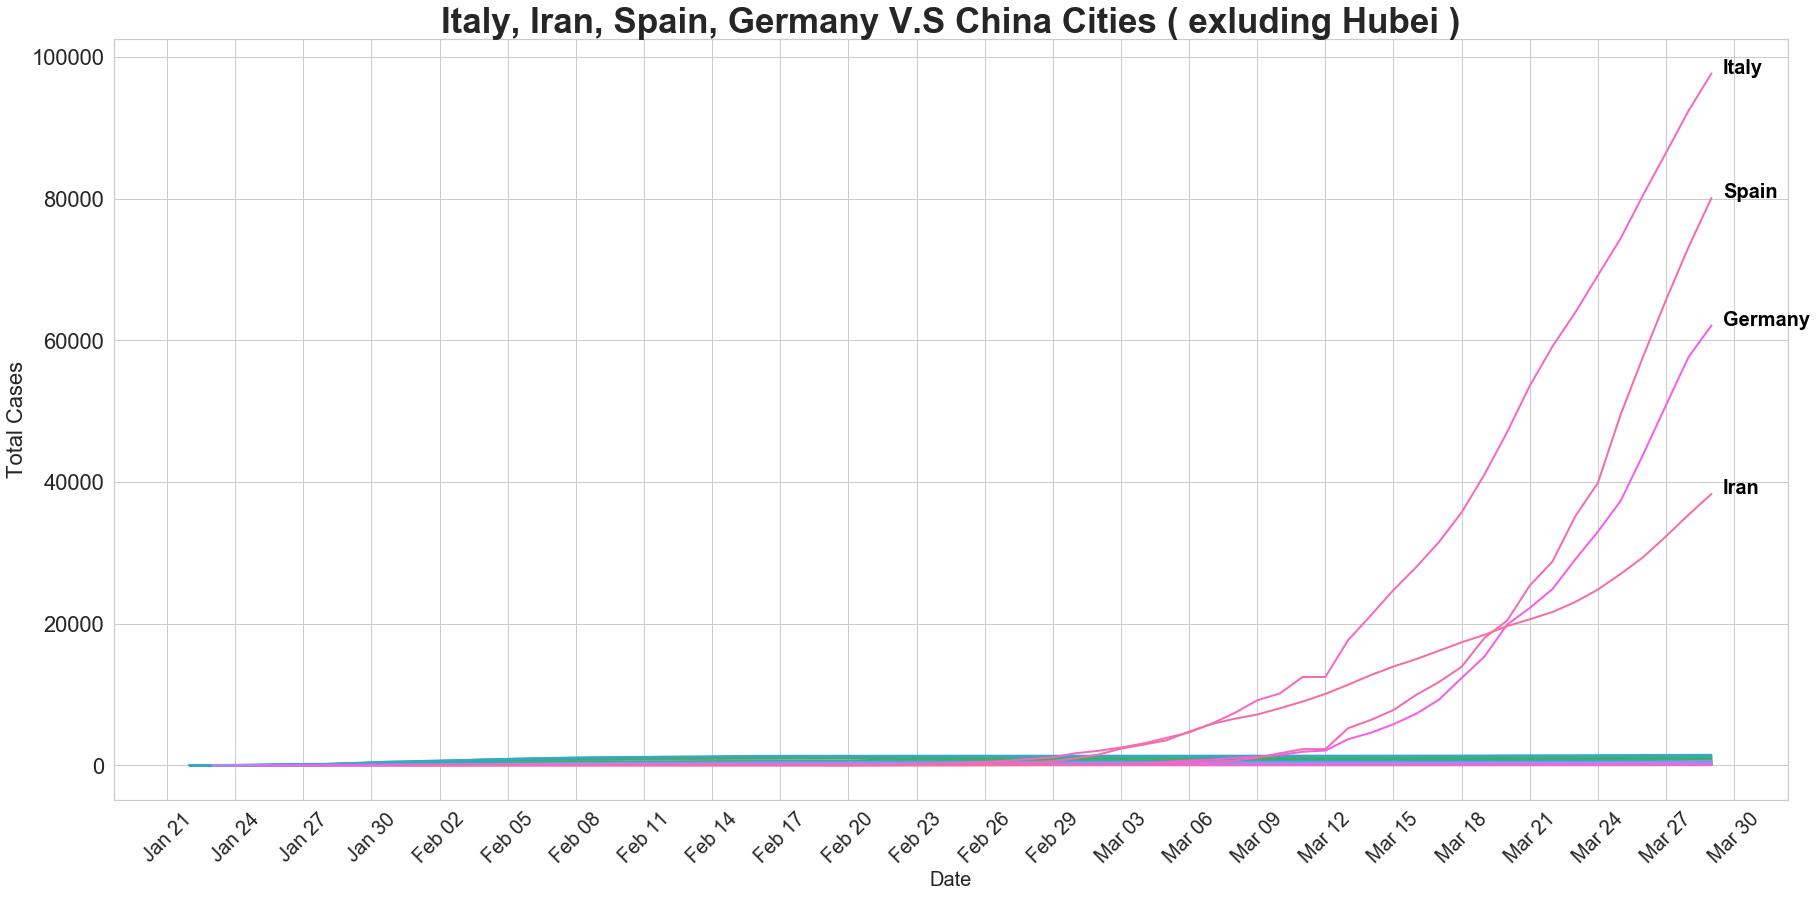

In [1706]:
plt.figure(figsize = (30, 14))
plt.title('Italy, Iran, Spain, Germany V.S China Cities ( exluding Hubei )', fontsize = 35, weight='bold')


ax = sns.lineplot(x="date", y="total_cases", hue="location", legend=False,   data=world_vs_china, linewidth=2)
sns.set_style("whitegrid")
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)

plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)

# ax.set_xlim([world_vs_china.date.min() - datetime.timedelta(days=1), world_vs_china.date.max() + datetime.timedelta(days=1)]);

    
# for i in range(4):
#     ax.annotate(world_highest.iloc[i].location, 
#                 xy=(world_vs_china.date.max(), world_highest.iloc[i].total_cases), fontsize=24,
#                 xytext=(world_vs_china.date.max() + datetime.timedelta(days=2),
#                         world_highest.iloc[i].total_cases + 50), 
#                 arrowprops=dict(facecolor='black', arrowstyle="->"));

for line in range(0,world_highest.shape[0]):
     ax.text(world_highest.date[line] + datetime.timedelta(days=0.5), world_highest.total_cases[line], world_highest.location[line], horizontalalignment='left', size='20', color='black', weight='bold')



## Gulf Countries

In [1707]:
gulf_countries = corona_cases[corona_cases.location.isin(['Saudi Arabia', 'Kuwait', 'Bahrain', 'United Arab Emirates', 'Qatar', 'Oman'])]
gulf_highest = gulf_countries.nlargest(6, ['date', 'total_cases']).reset_index()
gulf_highest

index province              location      Lat     Long       date  \
0   7863        0          Saudi Arabia  24.0000  45.0000 2020-03-29   
1   7833        0                 Qatar  25.3548  51.1839 2020-03-29   
2   7828        0  United Arab Emirates  24.0000  54.0000 2020-03-29   
3   7823        0               Bahrain  26.0275  50.5500 2020-03-29   
4   7797        0                Kuwait  29.5000  47.7500 2020-03-29   
5   7785        0                  Oman  21.0000  57.0000 2020-03-29   

   total_cases  
0         1299  
1          634  
2          570  
3          499  
4          255  
5          167

### Saudi Arabia

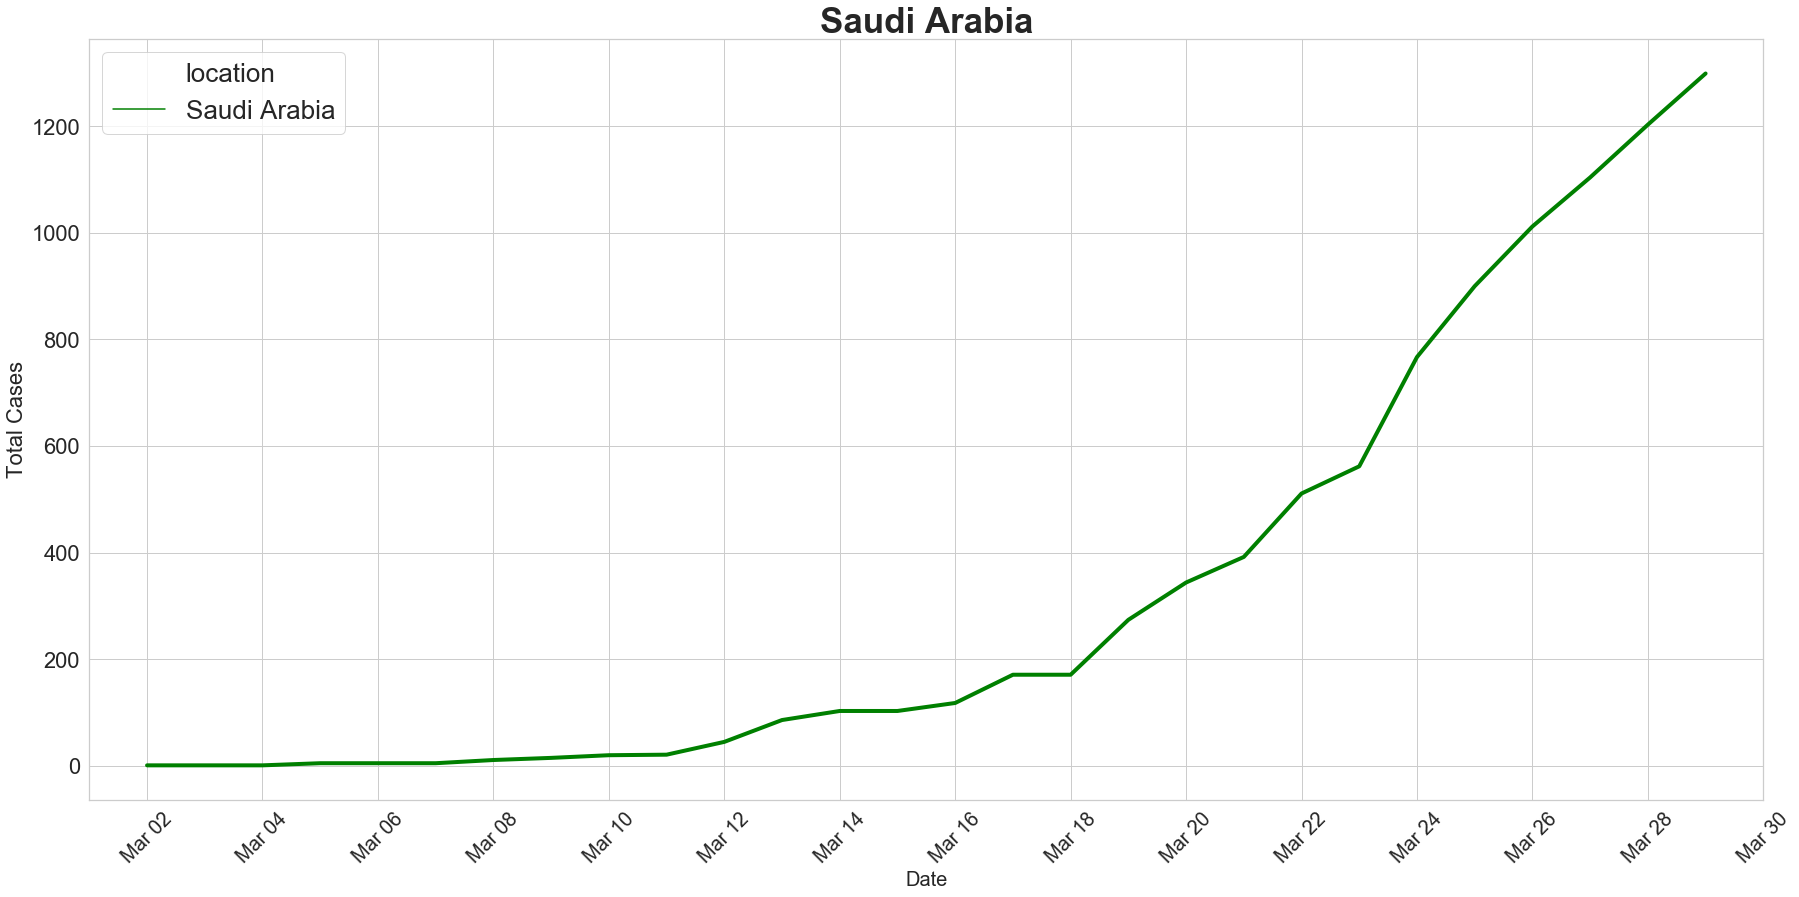

In [1708]:
saudi = gulf_countries[gulf_countries.location == 'Saudi Arabia']


plt.figure(figsize = (30, 14))
plt.title('Saudi Arabia', fontsize = 35, weight='bold')
sns.set_style("whitegrid")

ax = sns.lineplot(x="date", y="total_cases", hue="location",  data=saudi, linewidth=4, palette=['green'])

ax.set_xlim([saudi.date.min() - datetime.timedelta(days=1), saudi.date.max() + datetime.timedelta(days=1)])

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)

plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=26)

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

### Gulf Countries

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


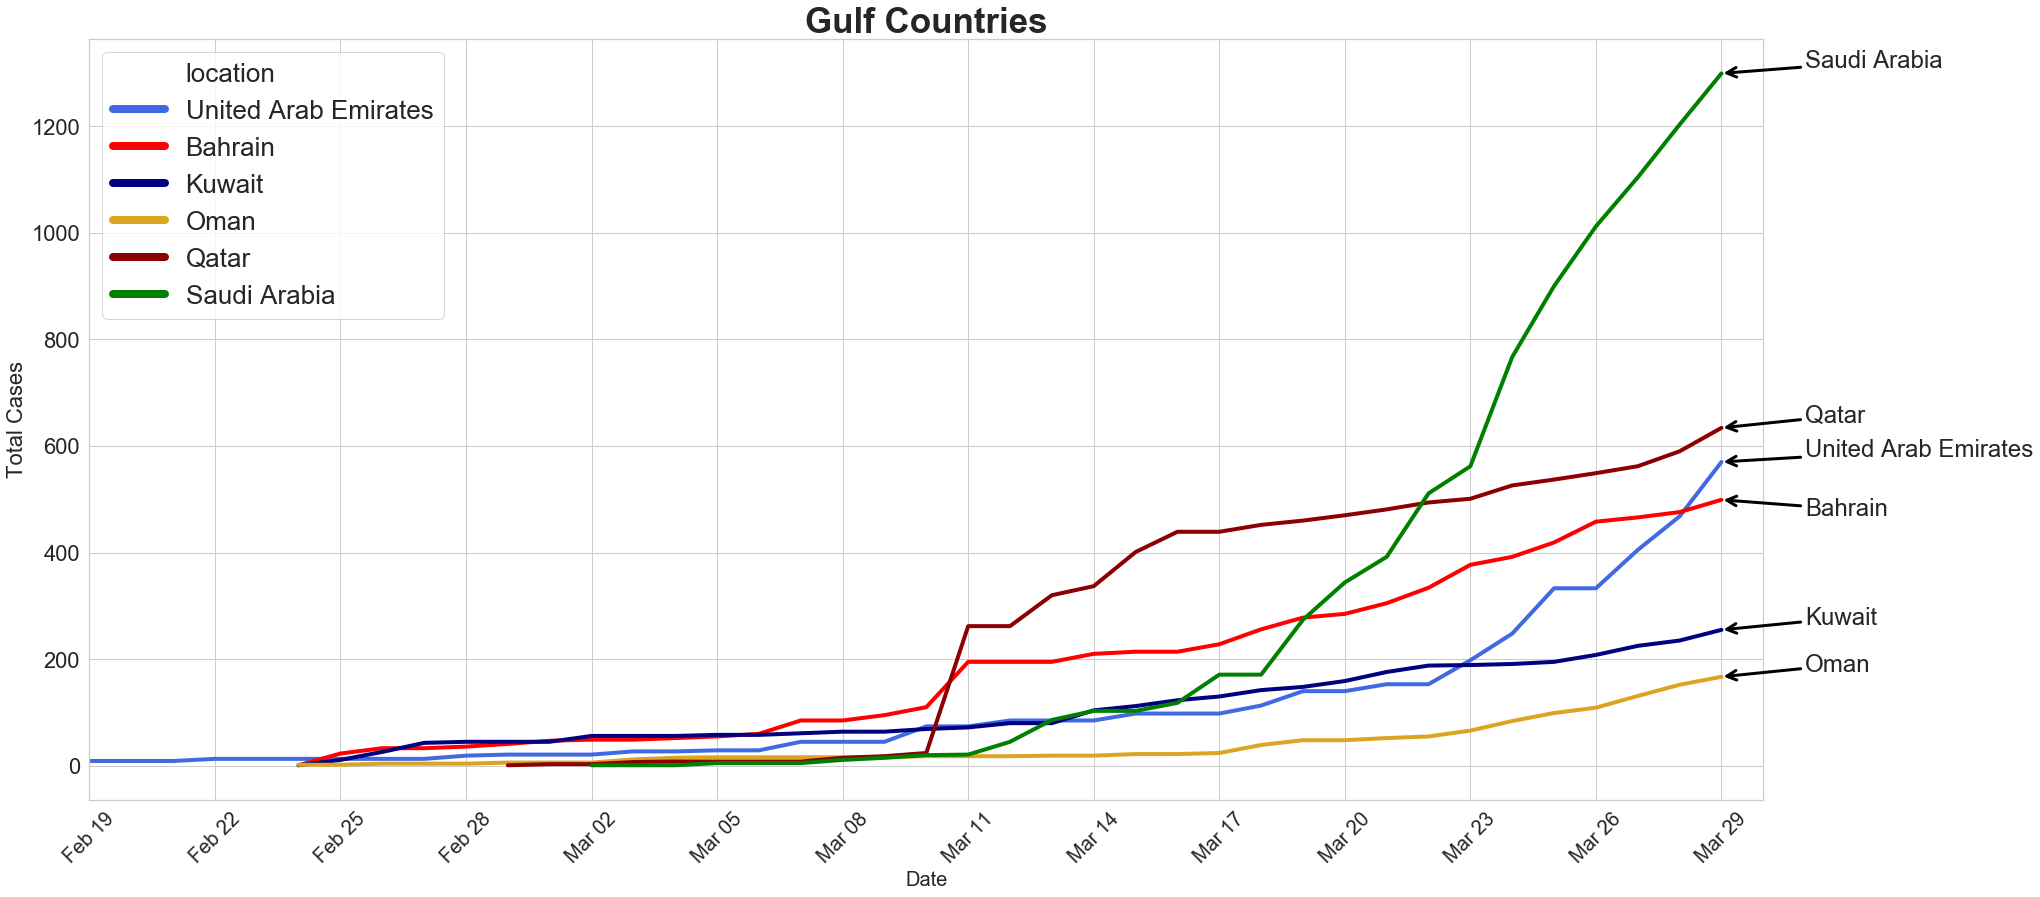

In [1709]:
palette = {
    'United Arab Emirates': 'royalblue',
    'Kuwait': 'navy',
    'Bahrain': 'red',
    'Saudi Arabia': 'green',
    'Oman': 'goldenrod',
    'Qatar': 'darkred'
}

plt.figure(figsize = (30, 14))
plt.title('Gulf Countries', fontsize = 35, weight='bold')

sns.set_style("whitegrid")
ax = sns.lineplot(x="date", y="total_cases", hue="location",  data=gulf_countries, linewidth=4, palette=palette)

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

ax.set_xlim([gulf_countries.date.min() + datetime.timedelta(days=21), gulf_countries.date.max() + datetime.timedelta(days=1)])

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)

plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=24)

for i in range(gulf_highest.shape[0]):
    if i == 3:
        ax.annotate(gulf_highest.iloc[i].location, 
                xy=(gulf_countries.date.max(), gulf_highest.iloc[i].total_cases), fontsize=24,
                xytext=(gulf_countries.date.max() + datetime.timedelta(days=2),
                        gulf_highest.iloc[i].total_cases - 30), 
                arrowprops=dict(facecolor='black', arrowstyle="->", color='black', linewidth=3));
    else:
        ax.annotate(gulf_highest.iloc[i].location, 
                xy=(gulf_countries.date.max(), gulf_highest.iloc[i].total_cases), fontsize=24,
                xytext=(gulf_countries.date.max() + datetime.timedelta(days=2),
                        gulf_highest.iloc[i].total_cases + 10), 
                arrowprops=dict(facecolor='black', arrowstyle="->", color='black', linewidth=3));

leg = ax.legend(ncol=1, prop={'size':26});
for line in leg.get_lines():
    line.set_linewidth(8)

## Functions to create week and new_cases columns

In [1710]:
# will assign the number of week sense the first case 
def num_of_week(date, location):
    start_date = corona_cases.date[(corona_cases.location == location)].min()    
    week_num = (date - start_date)
    return int(week_num / np.timedelta64(1, 'W')) + 1


In [1778]:
# get the new cases for each day
def new_cases(date, cases, location=None, province=None):
    # if the date given is not the start day for corona cases at the given location then proceed 
    prev_day = date - datetime.timedelta(days=1)
    if province != None:
        if corona_cases[(corona_cases.province == province) & (corona_cases.date == prev_day)].empty == False:
            prev_day_cases = corona_cases.total_cases[(corona_cases.province == province) & (corona_cases.date == prev_day)]        
            return int(cases - prev_day_cases)
        else: 
            return cases
    else:
        if corona_cases[(corona_cases.location == location) & (corona_cases.date == prev_day)].empty == False:
            prev_day_cases = corona_cases.total_cases[(corona_cases.location == location) & (corona_cases.date == prev_day)]        
            return int(cases - prev_day_cases)
        else: 
            return cases

### Gulf Countries

In [1712]:
gulf_countries['week'] = gulf_countries.apply(lambda x: num_of_week(x['date'], x['location']), axis=1)
gulf_countries = gulf_countries.sort_values(['date', 'total_cases'])

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1713]:
gulf_countries['new_cases'] = gulf_countries.apply(lambda x: new_cases(x['date'], x['total_cases'], location=x['location']), axis=1)


In [1714]:
weekly = gulf_countries.sort_values("date").drop_duplicates(subset =['location', 'week'], keep = 'last') 

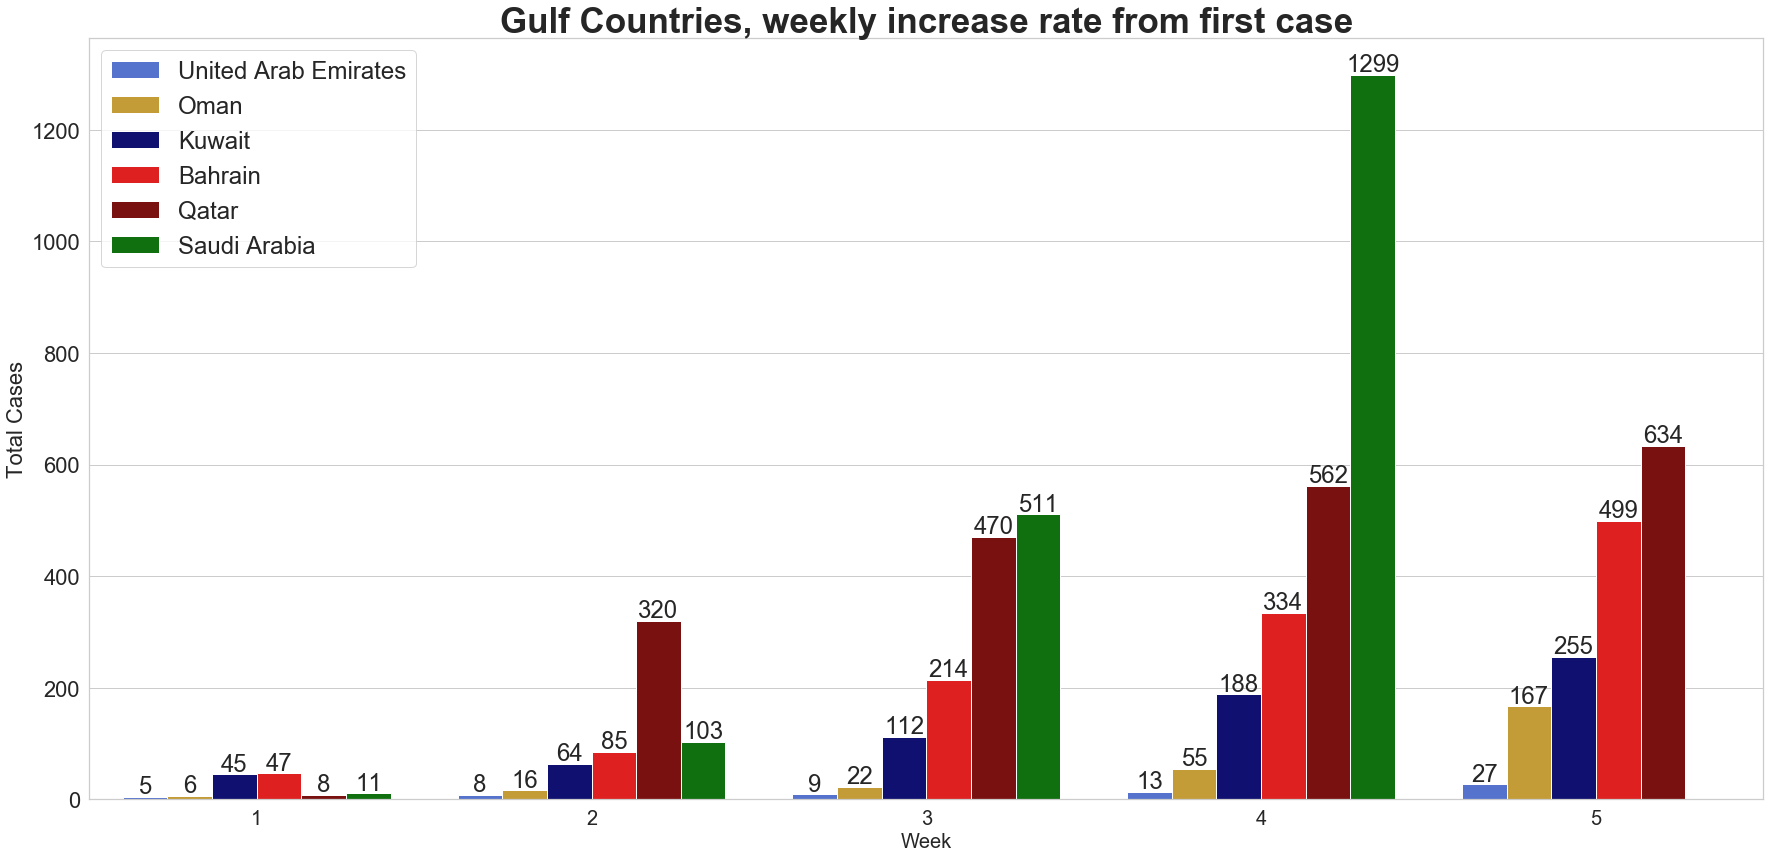

In [1715]:
# If I use here catplot() it will be clearer 


plt.figure(figsize = (30, 14))
plt.title('Gulf Countries, weekly increase rate from first case', fontsize = 35, weight='bold')

palette = {
    'United Arab Emirates': 'royalblue',
    'Kuwait': 'navy',
    'Bahrain': 'red',
    'Saudi Arabia': 'green',
    'Oman': 'goldenrod',
    'Qatar': 'darkred'
}
sns.set(font_scale = 2)
sns.set_style("whitegrid")
ax = sns.barplot(x="week", y="total_cases", hue="location", ci=None,  data=weekly[weekly['week'] < 6], palette=palette)

plt.xticks(fontsize =20)
plt.yticks(fontsize =22)

plt.xlabel('Week', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=24)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

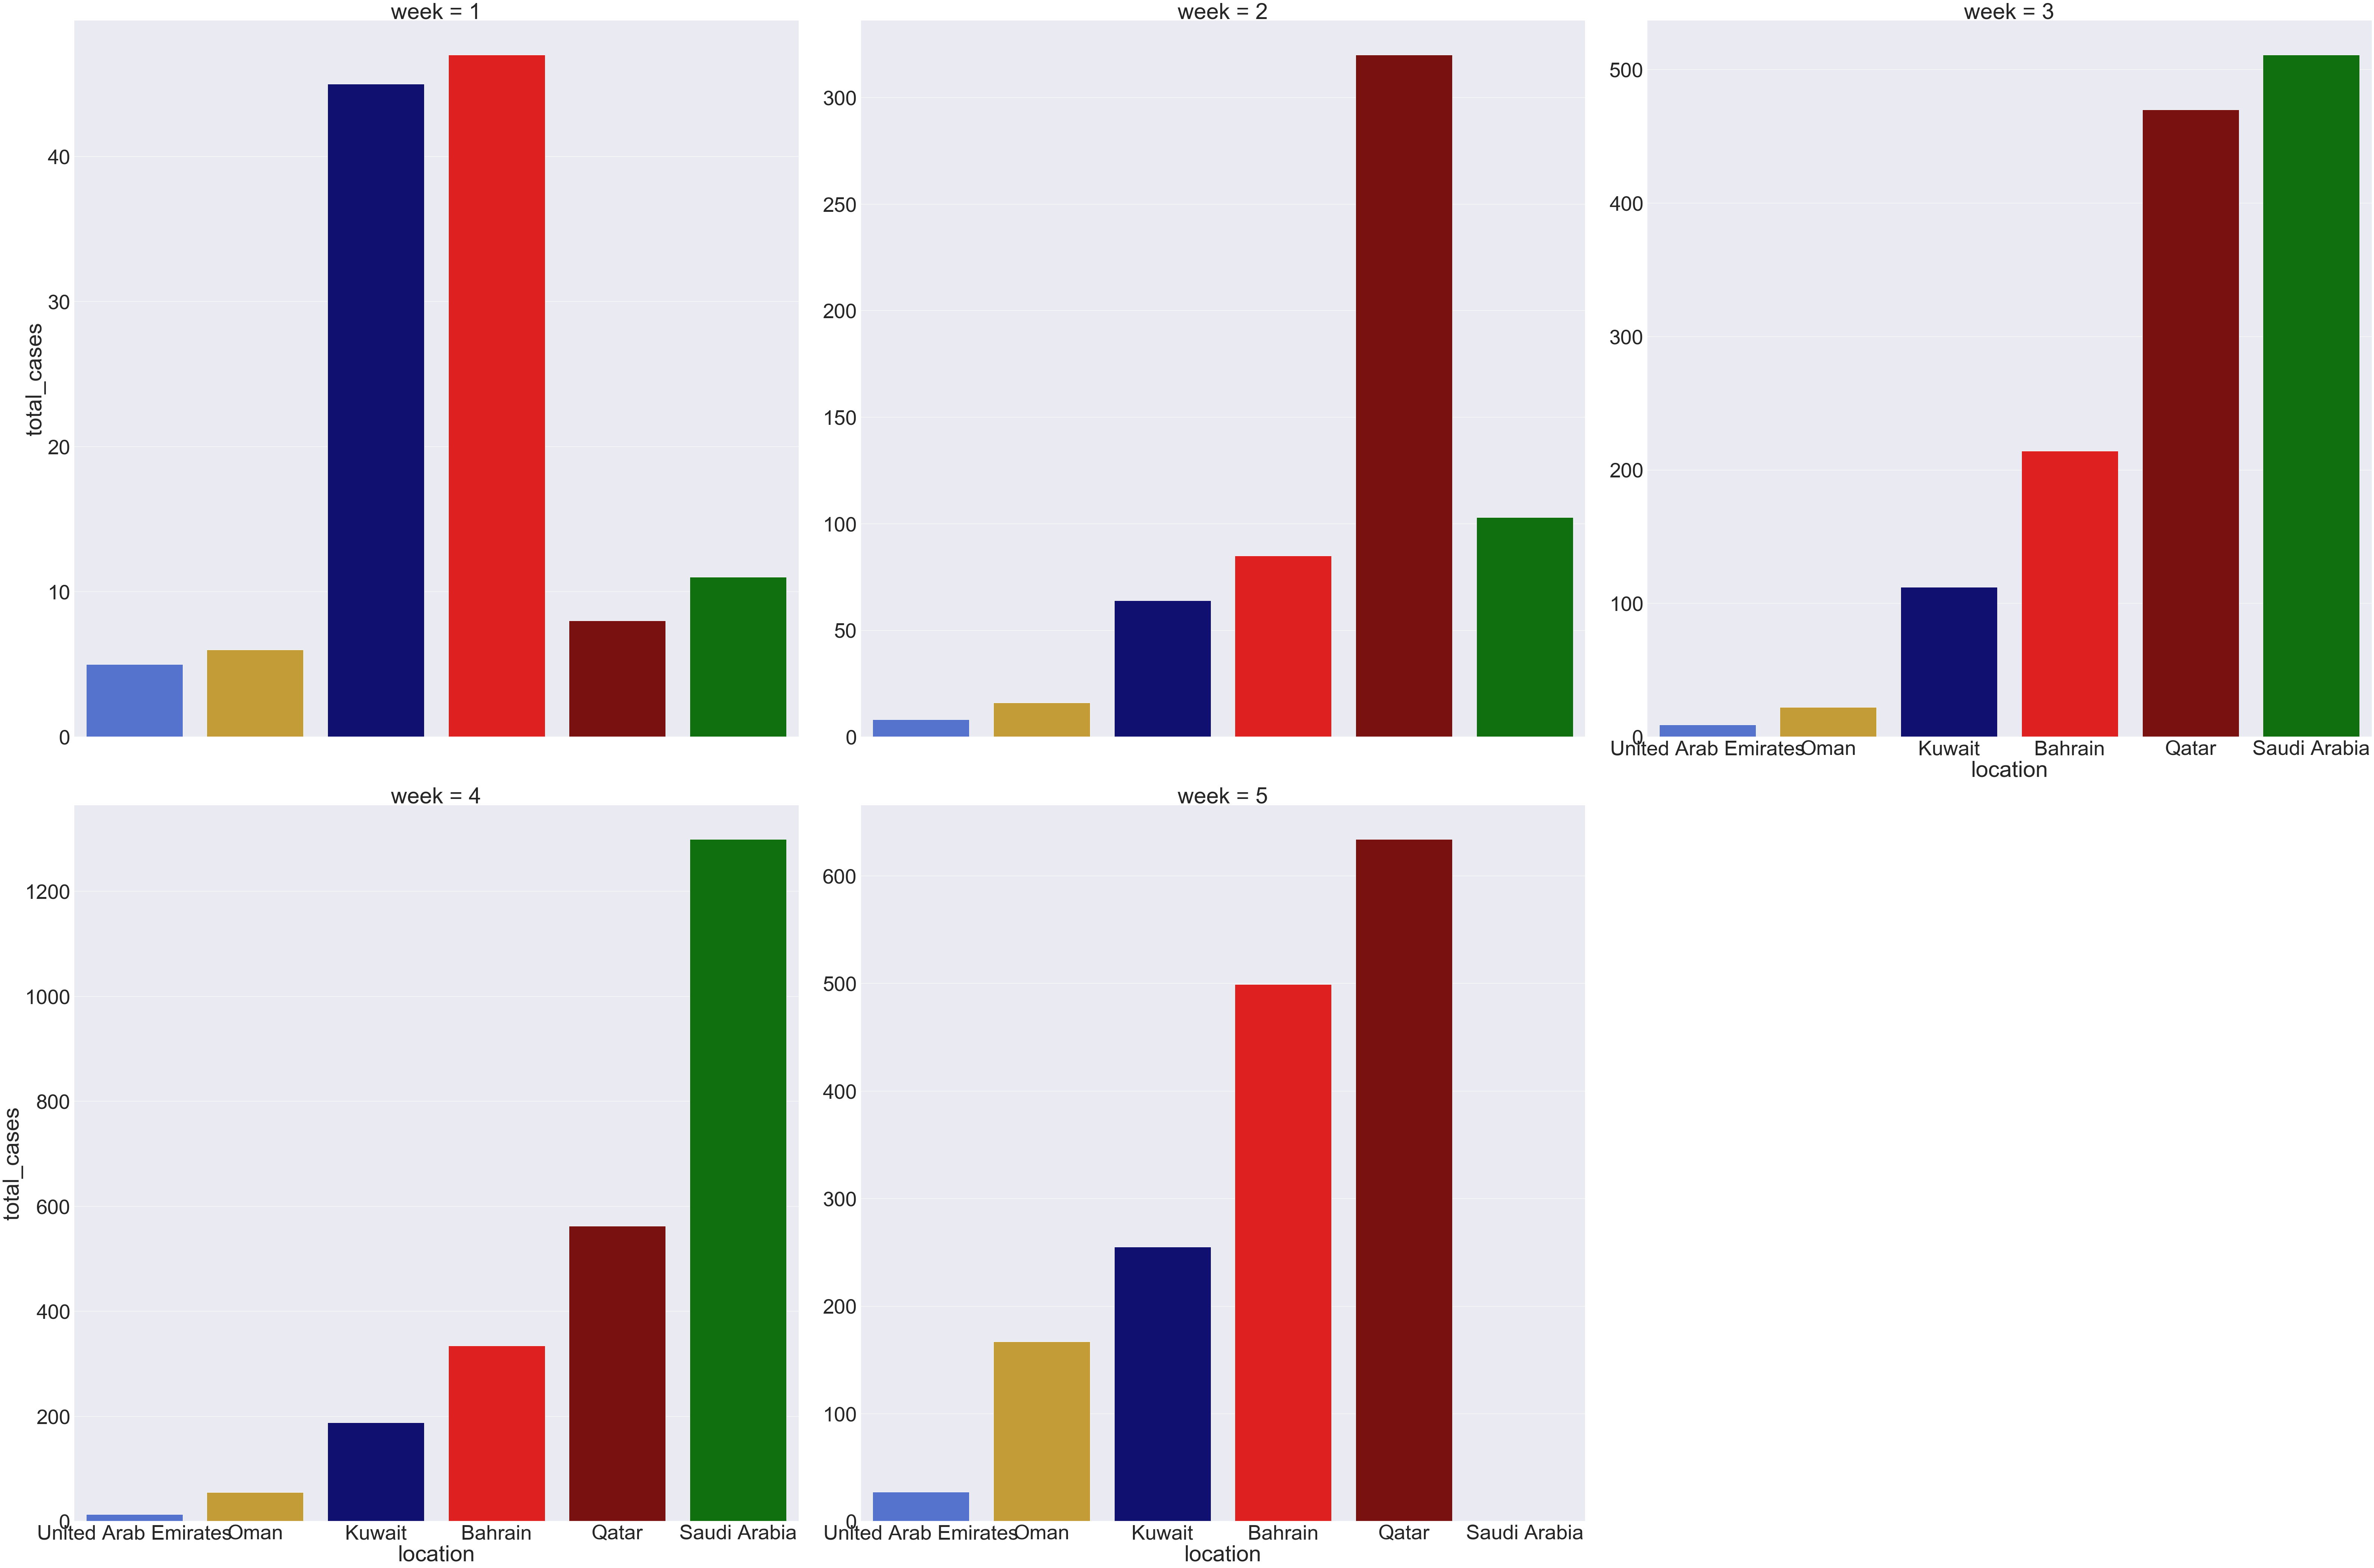

In [1737]:
# plt.figure(figsize = (30, 14))
# plt.title('Gulf Countries, Increasing Rate Each Week', fontsize=30)

palette = {
    'United Arab Emirates': 'royalblue',
    'Kuwait': 'navy',
    'Bahrain': 'red',
    'Saudi Arabia': 'green',
    'Oman': 'goldenrod',
    'Qatar': 'darkred'
}
sns.set(font_scale = 5)

g = sns.catplot(x="location", 
                y="total_cases", 
                col="week", 
                kind="bar", 
                data=weekly[weekly['week'] < 6], 
                col_wrap=3, height=30, aspect=1, 
                palette=palette, sharey=False );


In [1719]:
weekly_new = gulf_countries.groupby(['location', 'week']).agg({'new_cases':sum}).reset_index() # new_cases was created a few blocks down

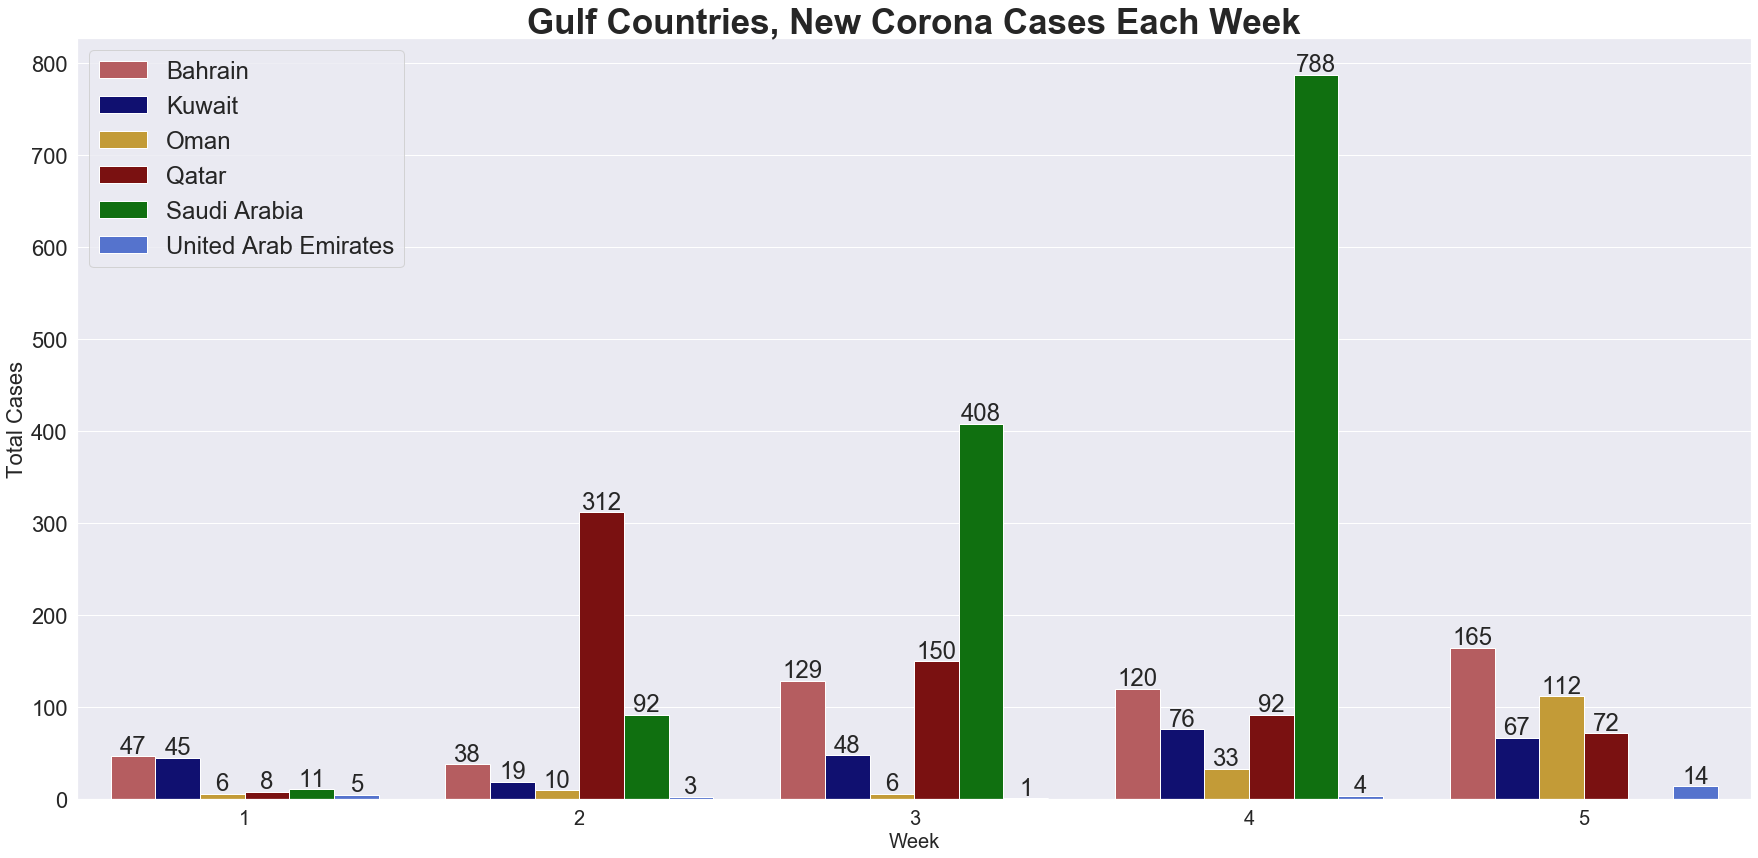

In [1720]:
plt.figure(figsize = (30, 14))
plt.title('Gulf Countries, New Corona Cases Each Week', fontsize = 35, weight='bold')

palette = {
    'United Arab Emirates': 'royalblue',
    'Kuwait': 'navy',
    'Bahrain': 'r',
    'Saudi Arabia': 'green',
    'Oman': 'goldenrod',
    'Qatar': 'darkred'
}

ax = sns.barplot(x="week", y="new_cases", hue="location", ci=None,  data=weekly_new[weekly_new['week'] < 6], palette=palette)

sns.set(font_scale = 2)

plt.xticks(fontsize =20)
plt.yticks(fontsize =22)

plt.xlabel('Week', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=24)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

### Other Countries V.S. Saudi Arabia

In [1721]:
iiss = corona_cases[corona_cases.location.isin(['Italy', 'Iran', 'Spain', 'Saudi Arabia'])]

iiss['week'] = iiss.apply(lambda x: num_of_week(x['date'], x['location']), axis=1)
iiss = iiss.sort_values(['date', 'total_cases'])

weekly_iiss = iiss.sort_values("date").drop_duplicates(subset =['location', 'week'], keep = 'last')

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


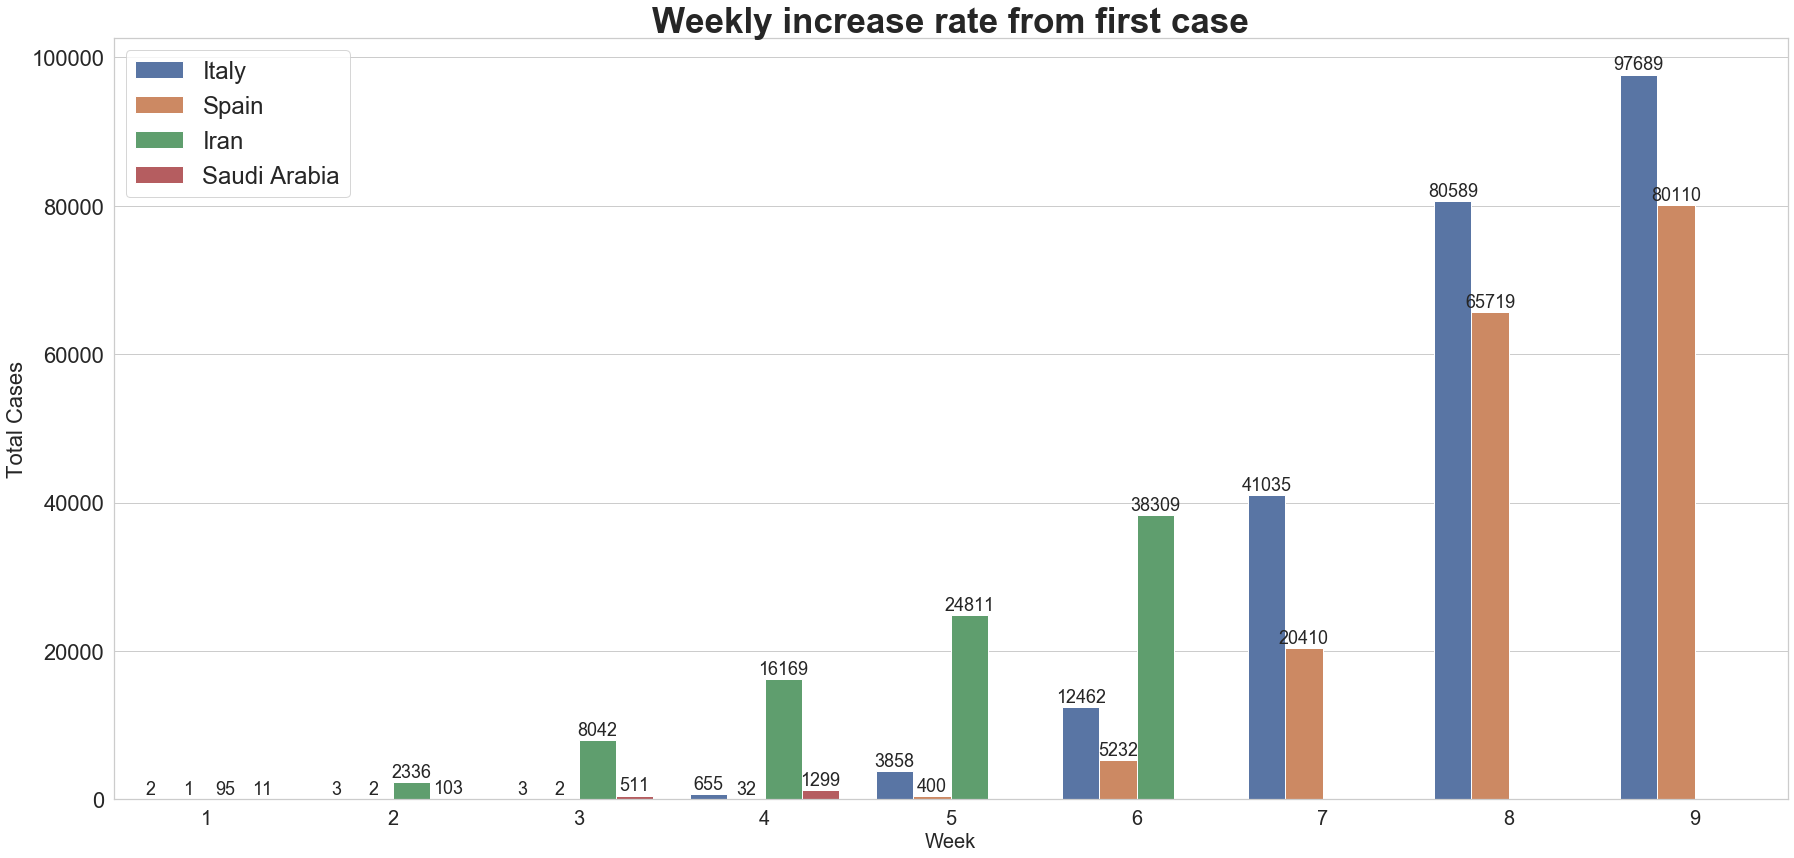

In [1723]:
# If I use here catplot() it will be clearer 

plt.figure(figsize = (30, 14))
plt.title('Weekly increase rate from first case', fontsize = 35, weight='bold')

ax = sns.barplot(x="week", y="total_cases", hue="location", ci=None,  data=weekly_iiss)


sns.set(font_scale = 1.5)
sns.set_style("whitegrid")

plt.xticks(fontsize =20)
plt.yticks(fontsize =22)

plt.xlabel('Week', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=24)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [1724]:
iiss['new_cases'] = iiss.apply(lambda x: new_cases(x['date'], x['total_cases'], location=x['location']), axis=1)
weekly_iss_new = iiss.groupby(['location', 'week']).agg({'new_cases':sum}).reset_index() # new_cases was created a few blocks down

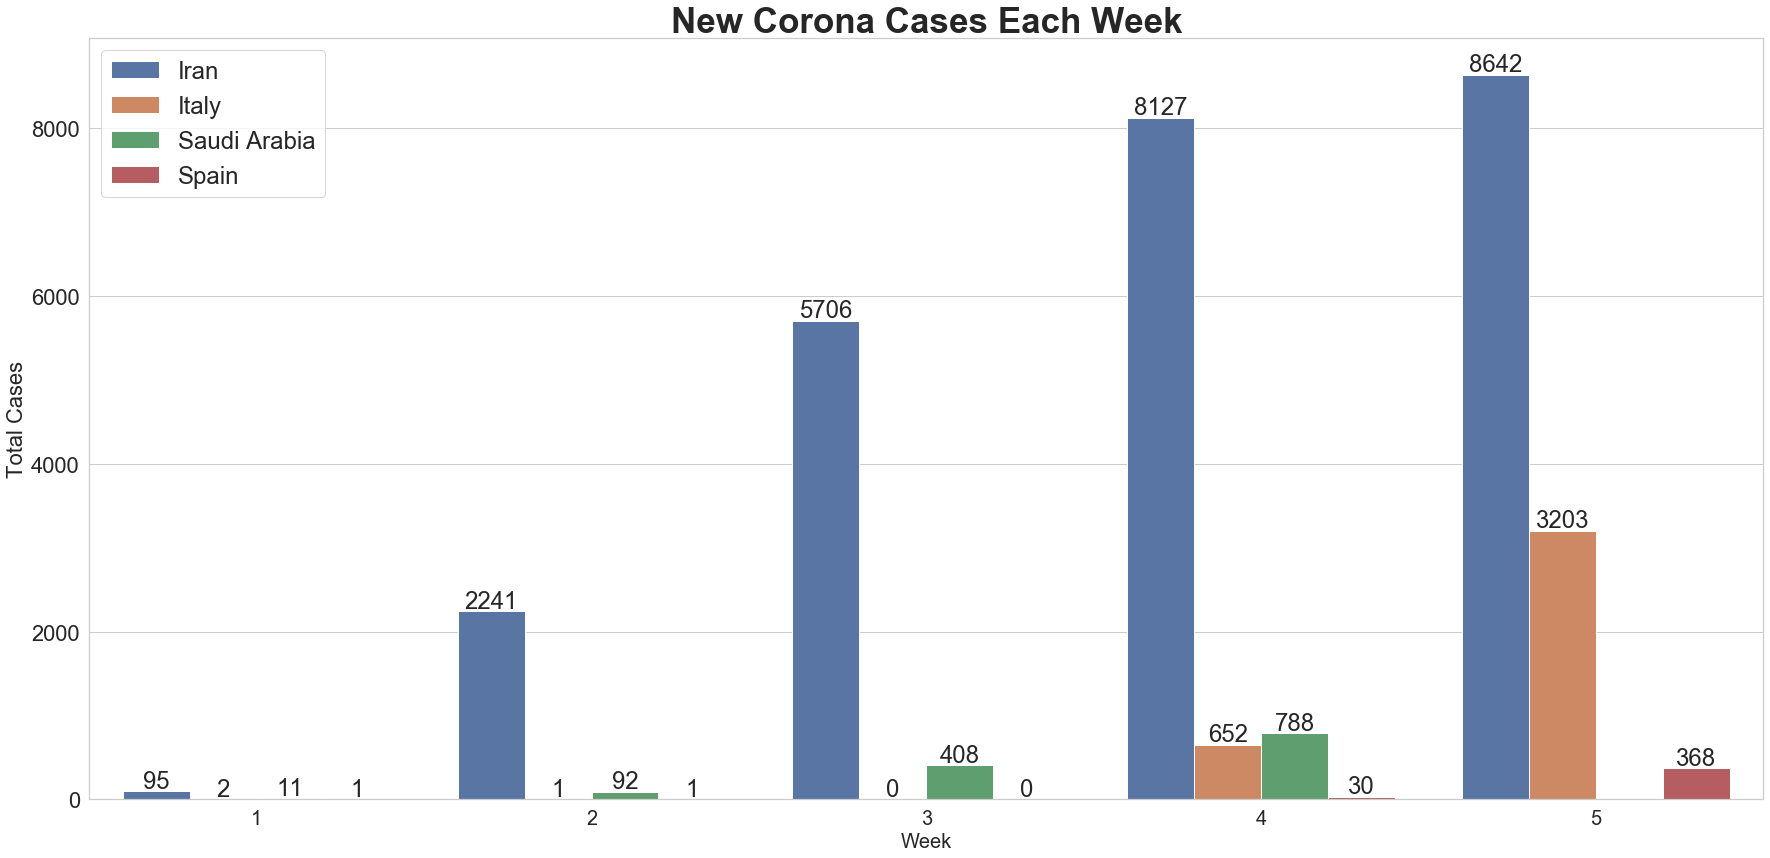

In [1725]:
plt.figure(figsize = (30, 14))
plt.title('New Corona Cases Each Week', fontsize = 35, weight='bold')


sns.set(font_scale = 2)
# sns.set_style("white")
sns.set_style("whitegrid")
ax = sns.barplot(x="week", y="new_cases", hue="location", ci=None,  data=weekly_iss_new[weekly_iss_new.week < 6])


plt.xticks(fontsize =20)
plt.yticks(fontsize =22)

plt.xlabel('Week', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=24)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

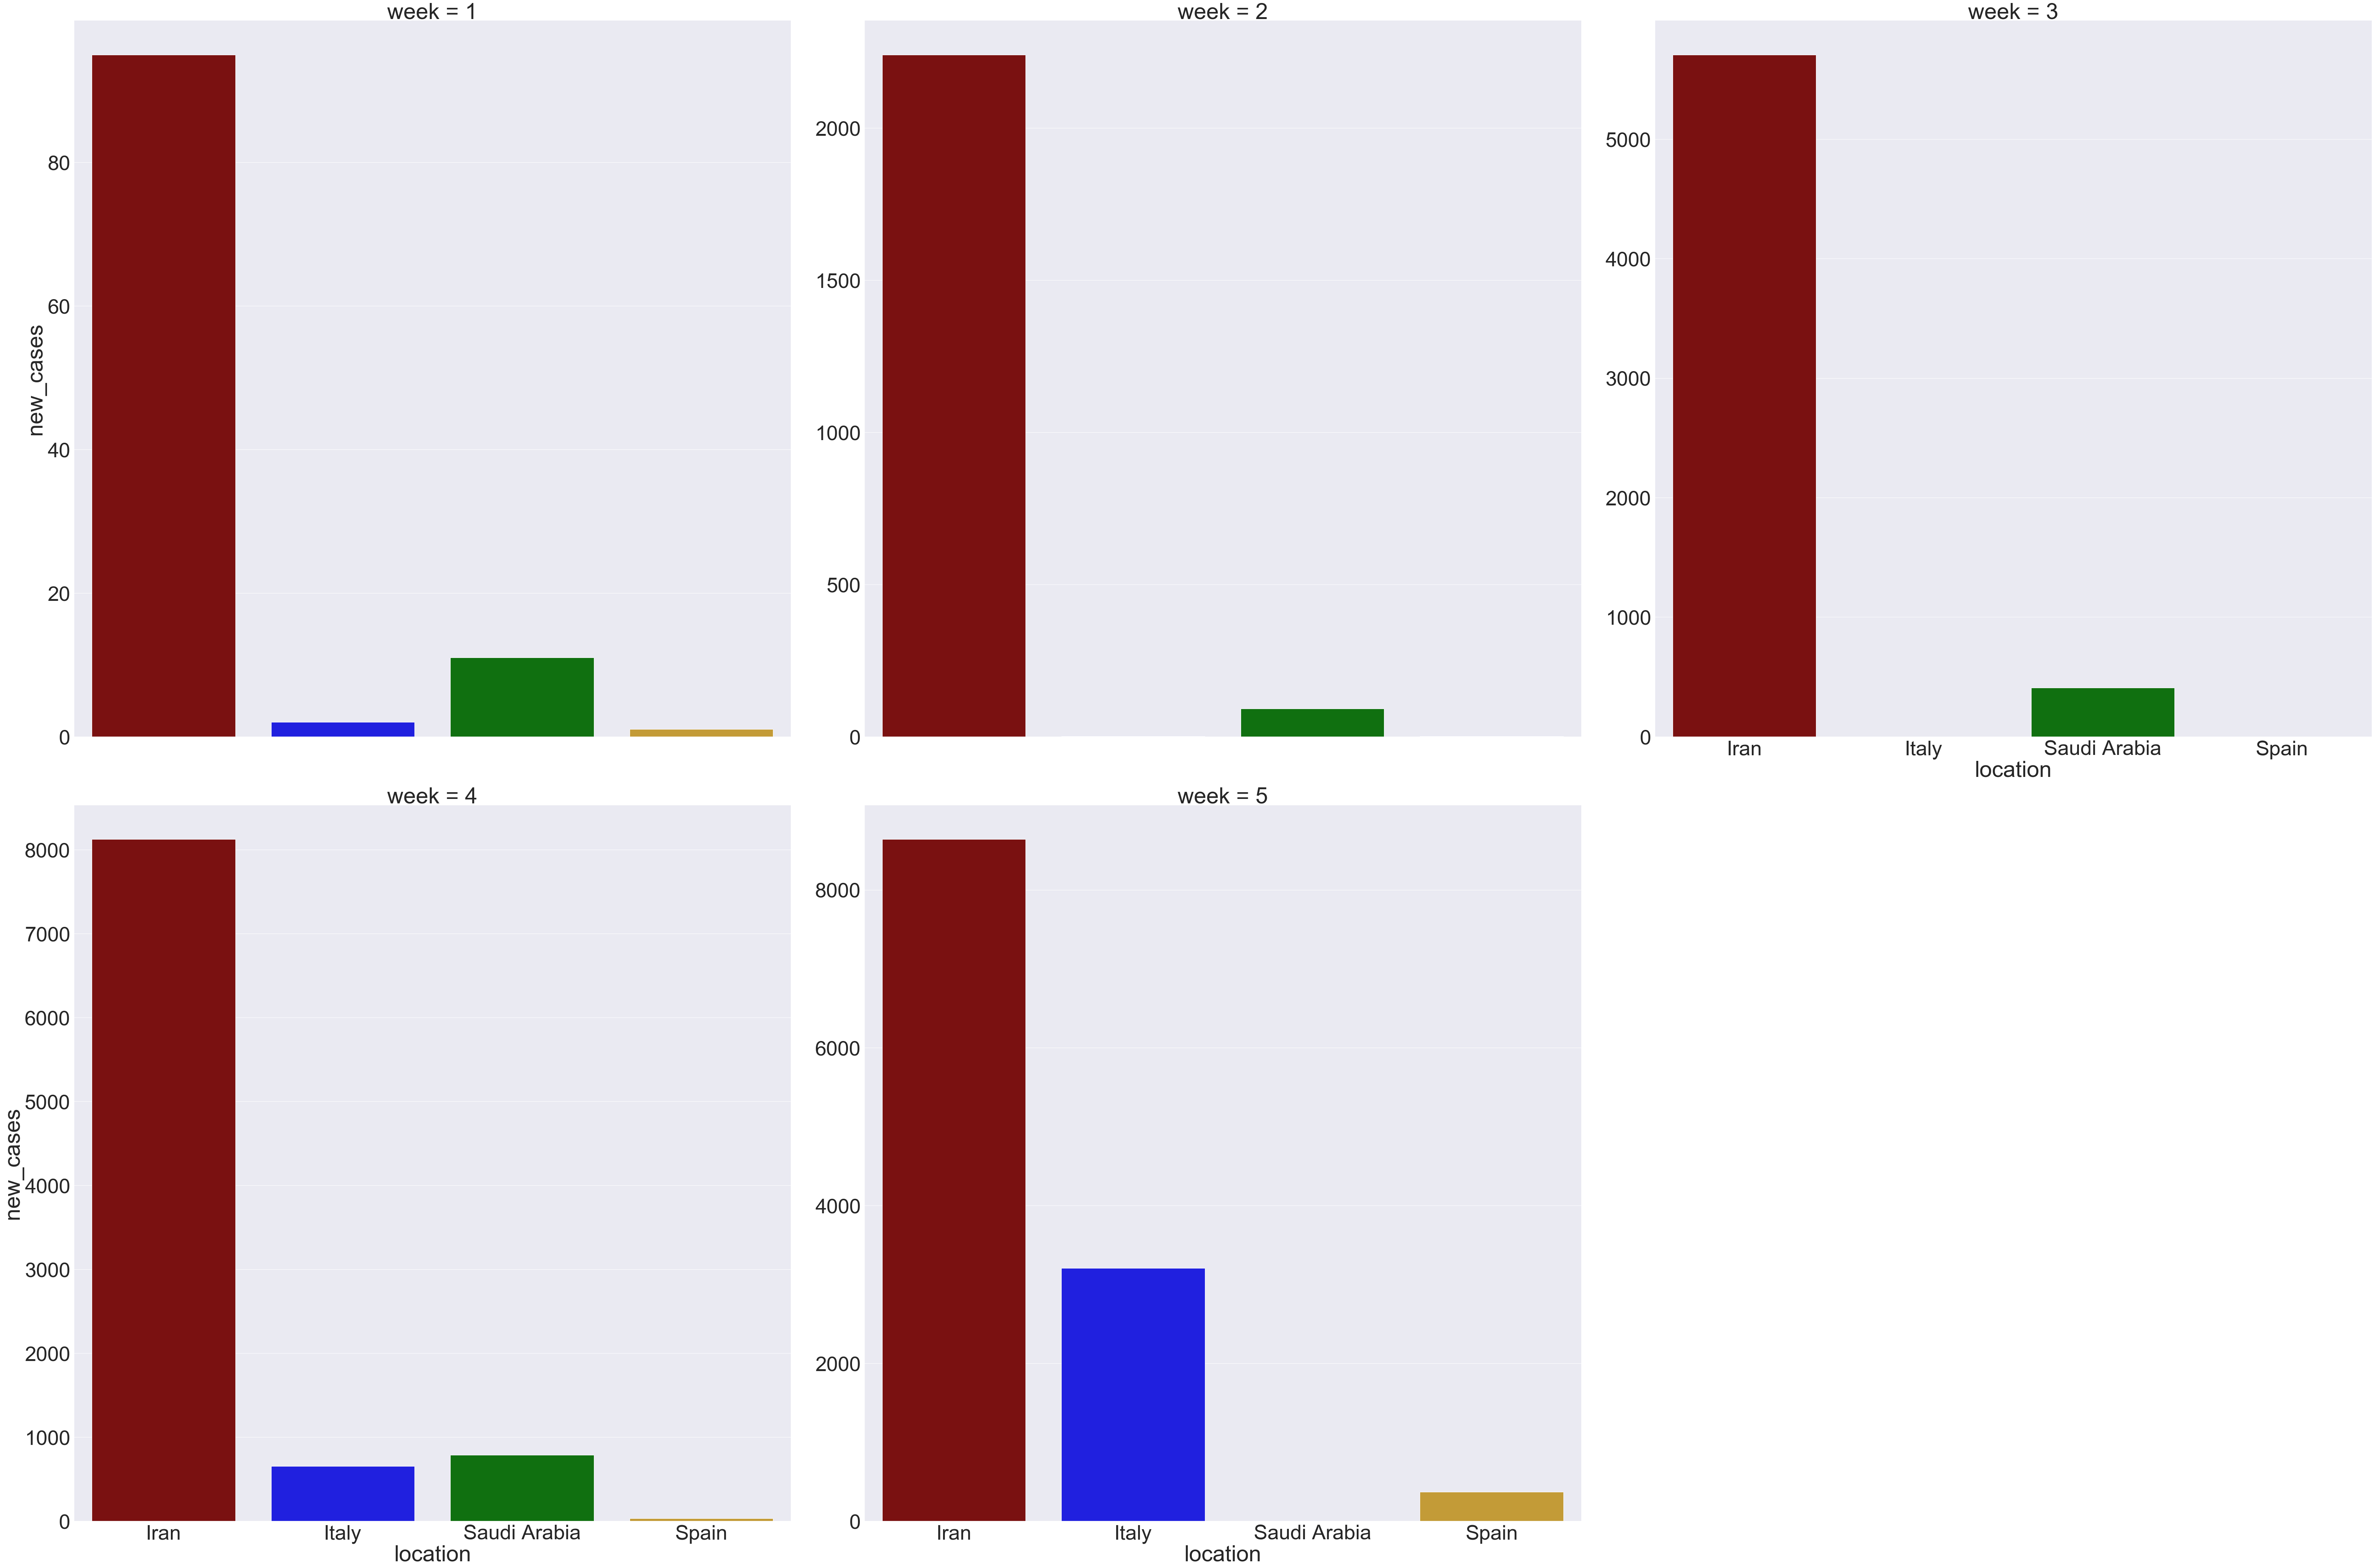

In [1734]:
palette = {
    'Italy': 'blue',
    'Saudi Arabia': 'green',
    'Spain': 'goldenrod',
    'Iran': 'darkred'
}
sns.set(font_scale = 5)

g = sns.catplot(x="location", 
                y="new_cases", 
                col="week", 
                kind="bar", 
                data=weekly_iss_new[weekly_iss_new.week < 6], 
                col_wrap=3, height=30, aspect=1, 
                palette=palette , sharey=False);

## Daily Growth rate

### Gulf Countries

#### Saudi daily growth

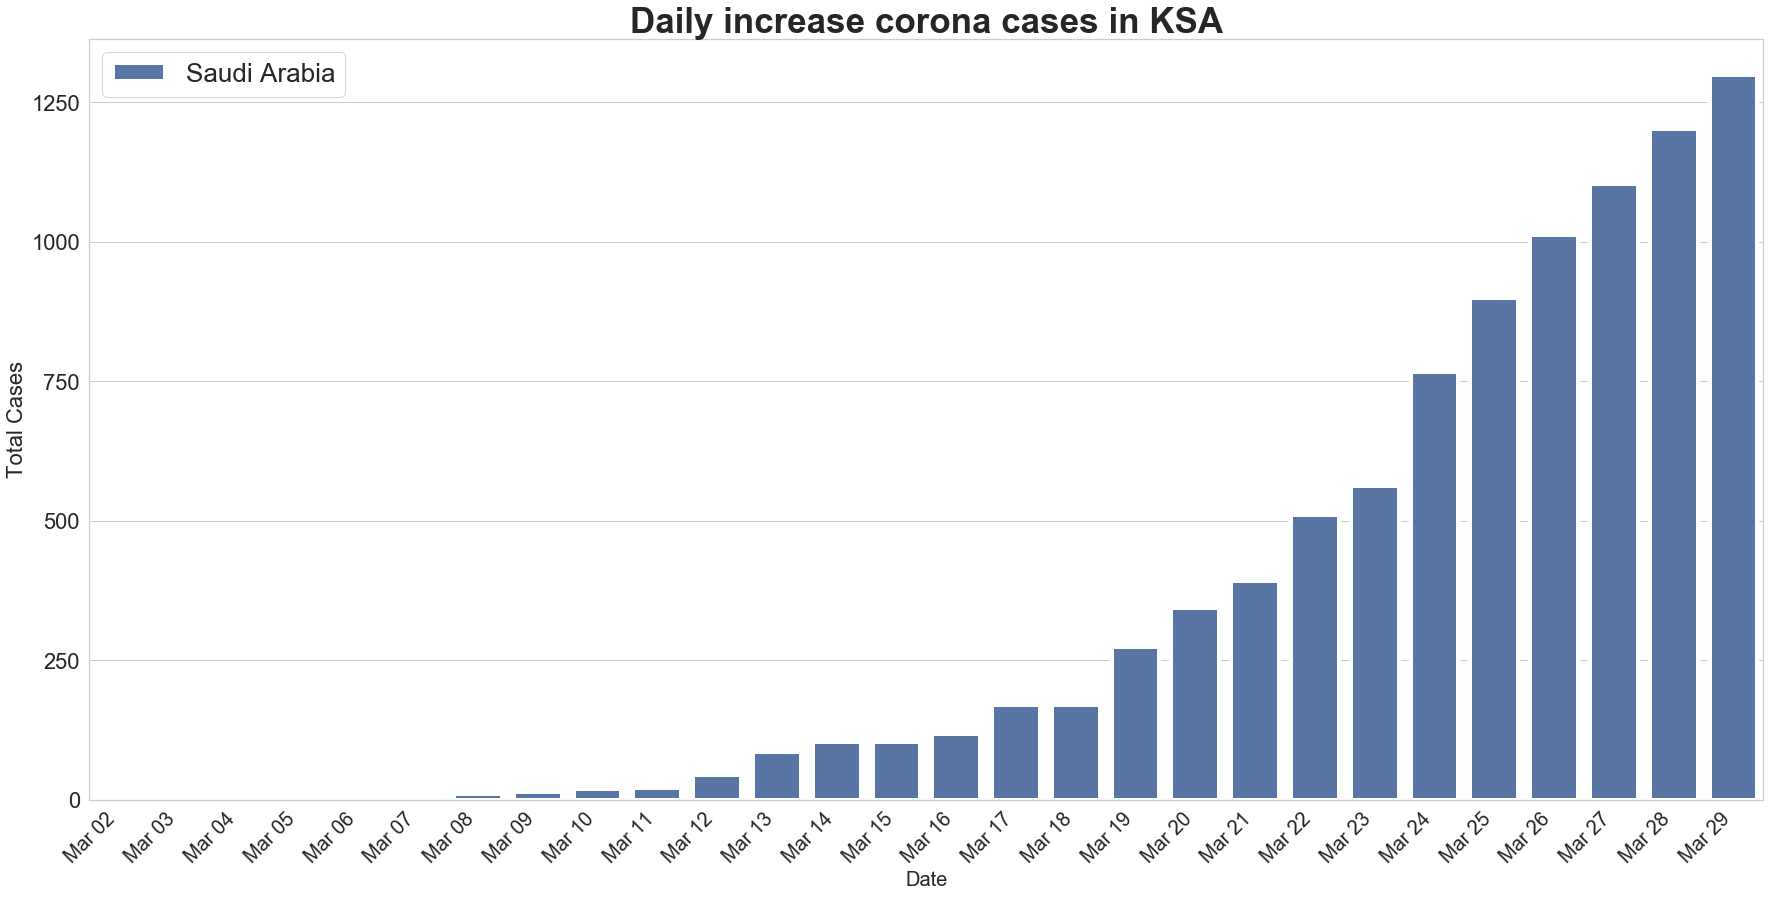

In [1738]:
saudi = gulf_countries[gulf_countries.location == 'Saudi Arabia']

sns.set_style("whitegrid")
plt.figure(figsize = (30, 14))
plt.title('Daily increase corona cases in KSA', fontsize = 35, weight='bold')

ax = sns.barplot(x="date", y="total_cases", hue="location",  data=saudi, linewidth=4)

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)

plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=26)


x_dates = saudi['date'].dt.strftime('%b %d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right');


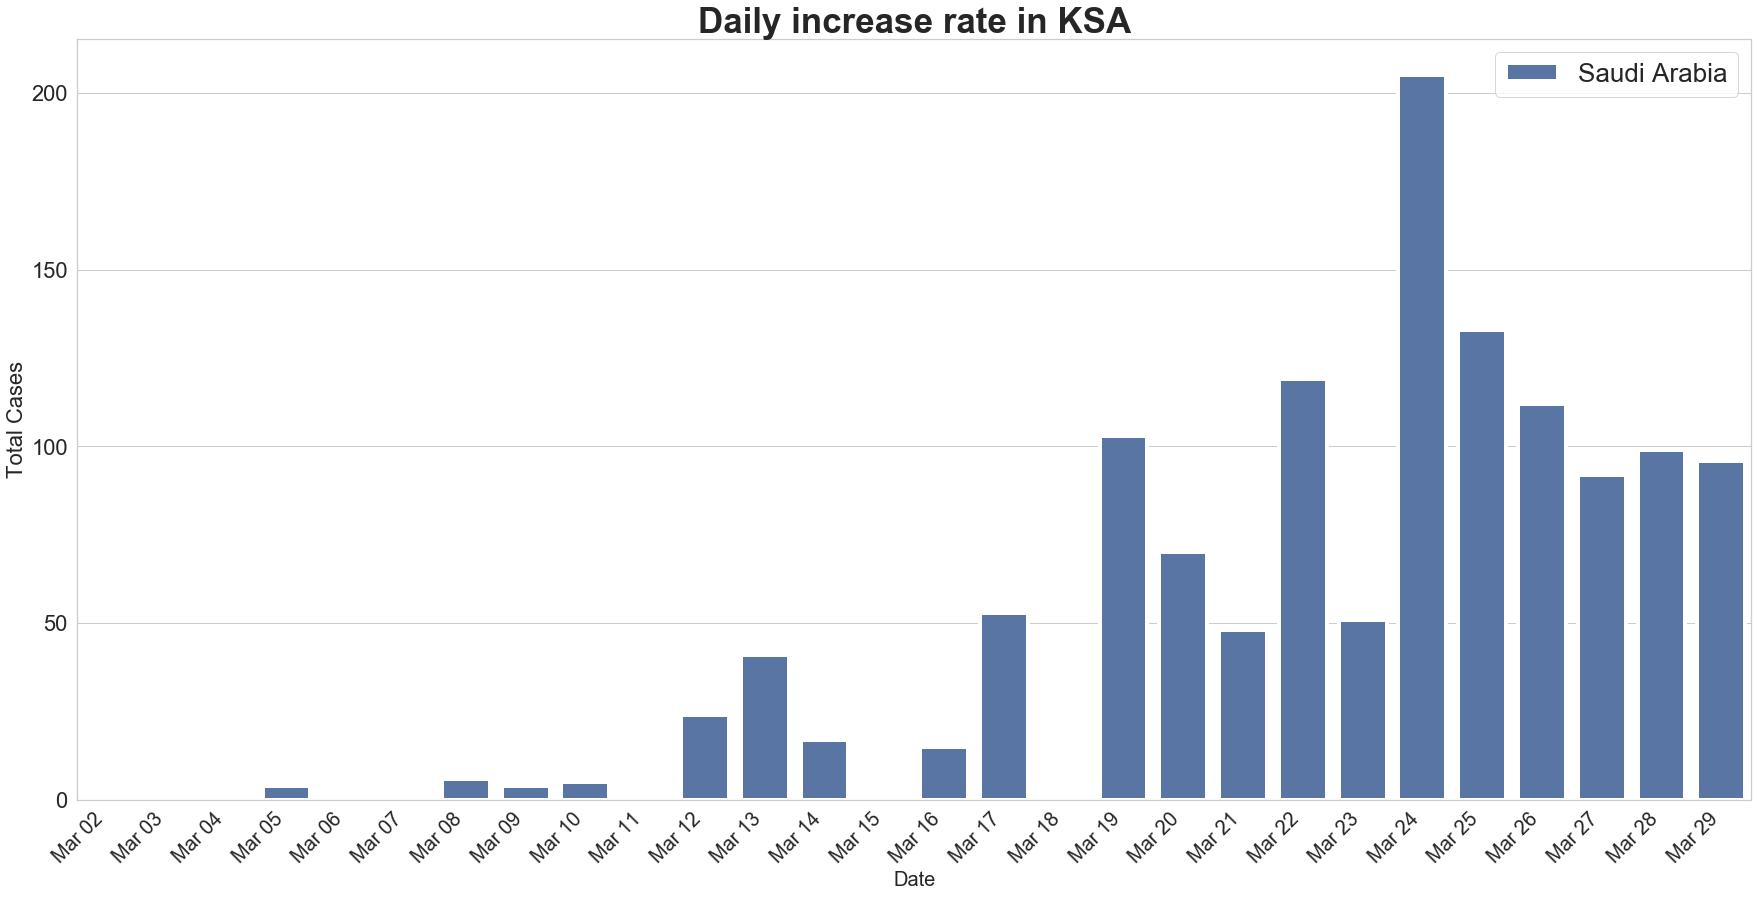

In [1739]:
saudi = gulf_countries[gulf_countries.location == 'Saudi Arabia']


plt.figure(figsize = (30, 14))
plt.title('Daily increase rate in KSA', fontsize = 35, weight='bold')
sns.set_style("whitegrid")

ax = sns.barplot(x="date", y="new_cases", hue="location",  data=saudi, linewidth=4)

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)

plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=26)


x_dates = saudi['date'].dt.strftime('%b %d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right');

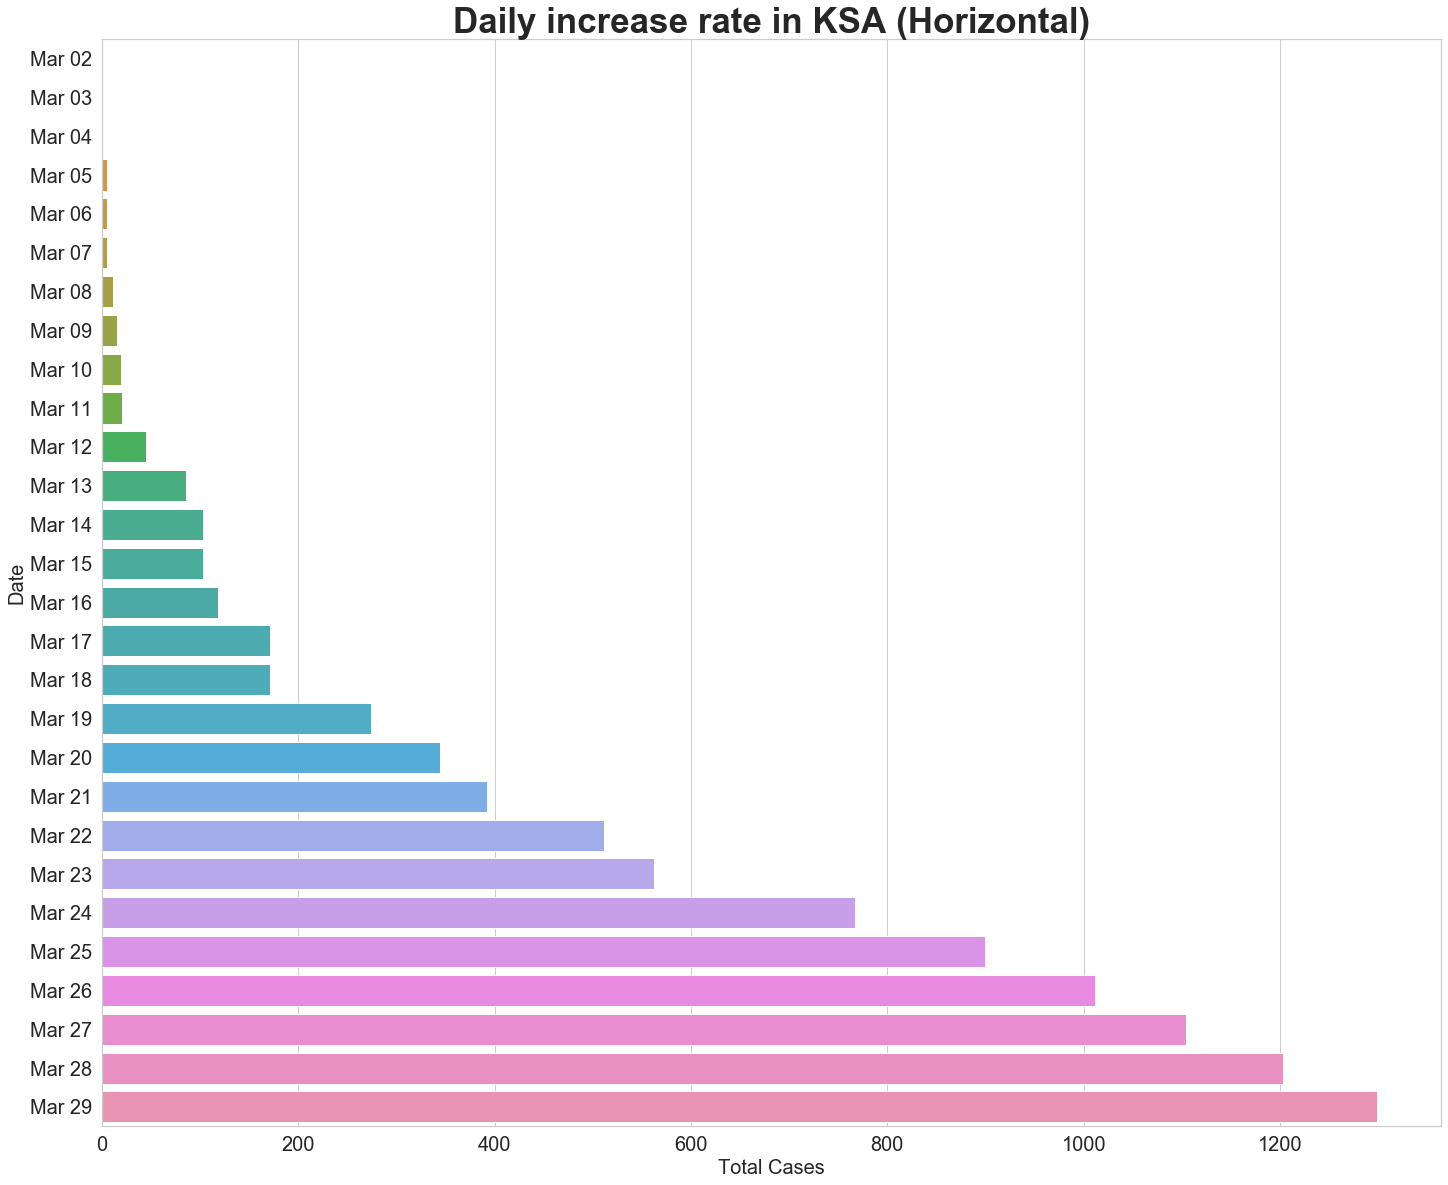

In [1740]:
saudi = gulf_countries[gulf_countries.location == 'Saudi Arabia']
plt.figure(figsize = (24, 20))

plt.title('Daily increase rate in KSA (Horizontal)', fontsize = 35, weight='bold')
sns.set_style("whitegrid")
ax = sns.barplot(x="total_cases", y="date",  data=saudi, orient = 'h');

plt.yticks(fontsize =20)
plt.xticks(fontsize =20)
plt.ylabel('Date', fontsize =20)
plt.xlabel('Total Cases', fontsize =20)

y_dates = saudi['date'].dt.strftime('%b %d').sort_values().unique()
ax.set_yticklabels(labels=y_dates, ha='right');


/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
No handles with labels found to put in legend.


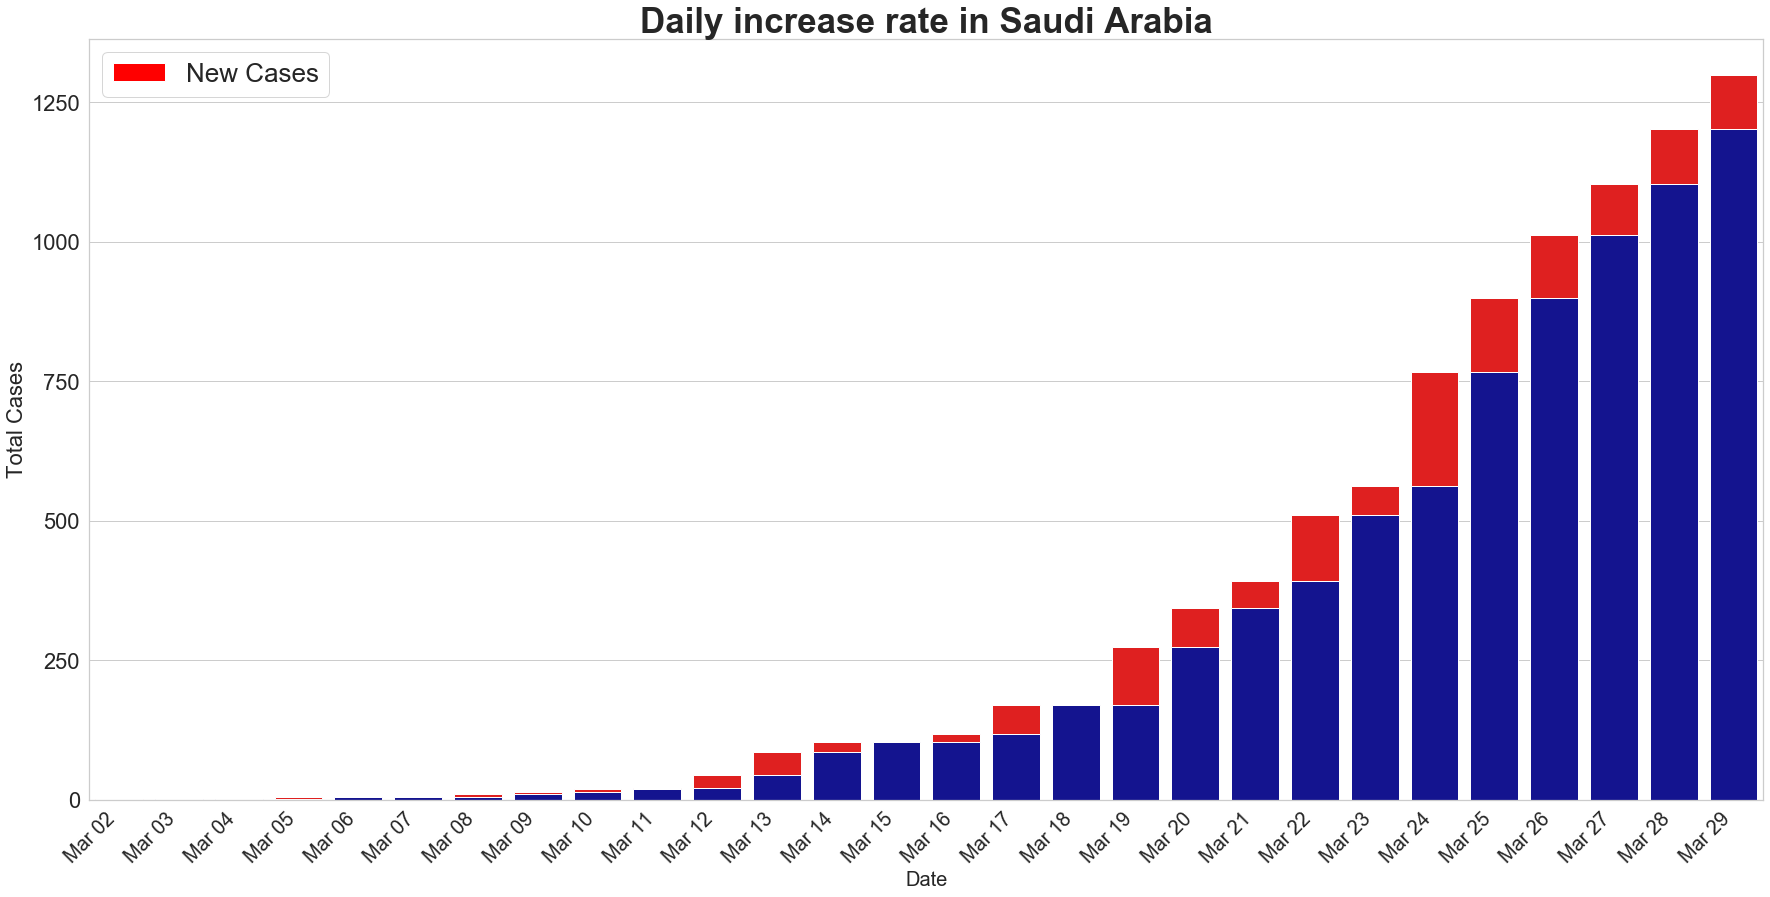

In [1741]:
saudi = gulf_countries[gulf_countries.location == 'Saudi Arabia']
saudi['new_cases'] = saudi['total_cases'] - saudi['new_cases']

plt.figure(figsize = (30, 14))
plt.title('Daily increase rate in Saudi Arabia', fontsize = 35, weight='bold')
sns.set_style("whitegrid")

sns.barplot(x='date', y='total_cases', data=saudi, color='red')
bottom_plot = sns.barplot(x='date', y='new_cases', data=saudi, color='#0000A3')


plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)
plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=26)

x_dates = saudi['date'].dt.strftime('%b %d').sort_values().unique()
bottom_plot.set_xticklabels(labels=x_dates, rotation=45, ha='right')

top_bar = plt.Rectangle((0, 0), 1, 1, fc='red')
plt.legend([top_bar], ['New Cases'], loc='upper left', ncol=1, prop={'size':26});

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
No handles with labels found to put in legend.


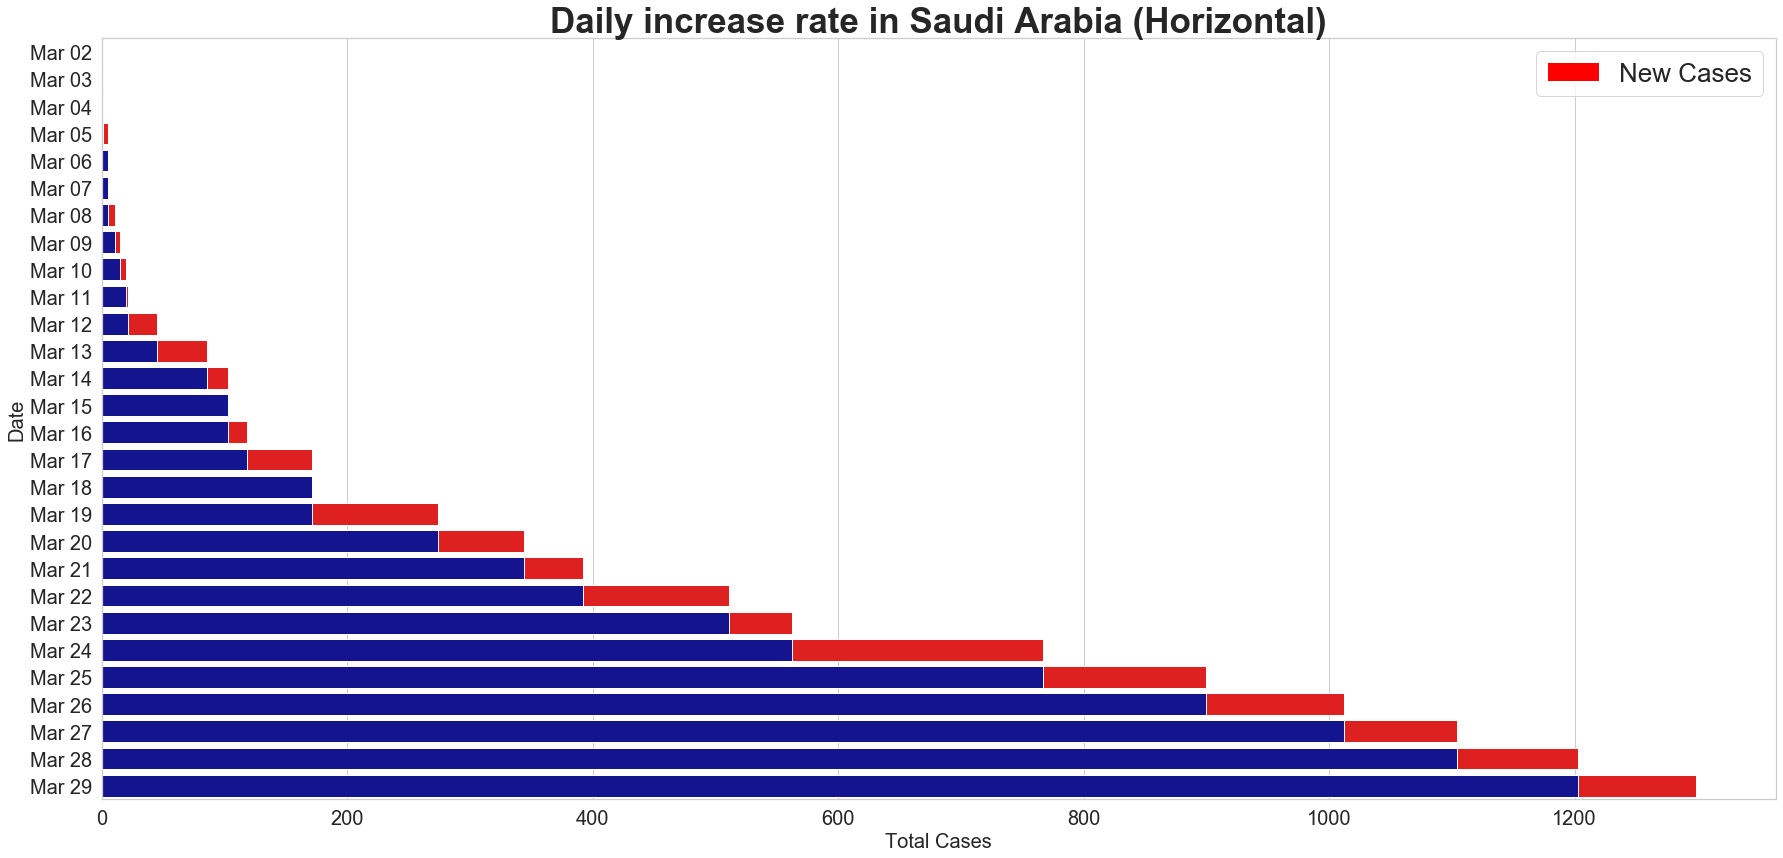

In [1742]:
saudi = gulf_countries[gulf_countries.location == 'Saudi Arabia']
saudi['new_cases'] = saudi['total_cases'] - saudi['new_cases']

plt.figure(figsize = (30, 14))
plt.title('Daily increase rate in Saudi Arabia (Horizontal)', fontsize = 35, weight='bold')
sns.set_style("whitegrid")

sns.barplot(y='date', x='total_cases', data=saudi, color='red', orient = 'h')
bottom_plot = sns.barplot(y='date', x='new_cases', data=saudi, color='#0000A3', orient = 'h')

plt.yticks(fontsize =20)
plt.xticks(fontsize =20)
plt.ylabel('Date', fontsize =20)
plt.xlabel('Total Cases', fontsize =20)
plt.legend(fontsize=26)

y_dates = saudi['date'].dt.strftime('%b %d').sort_values().unique()
bottom_plot.set_yticklabels(labels=y_dates, ha='right');

top_bar = plt.Rectangle((0, 0), 1, 1, fc='red')
plt.legend([top_bar], ['New Cases'], loc='upper right', ncol=1, prop={'size':26});

No handles with labels found to put in legend.


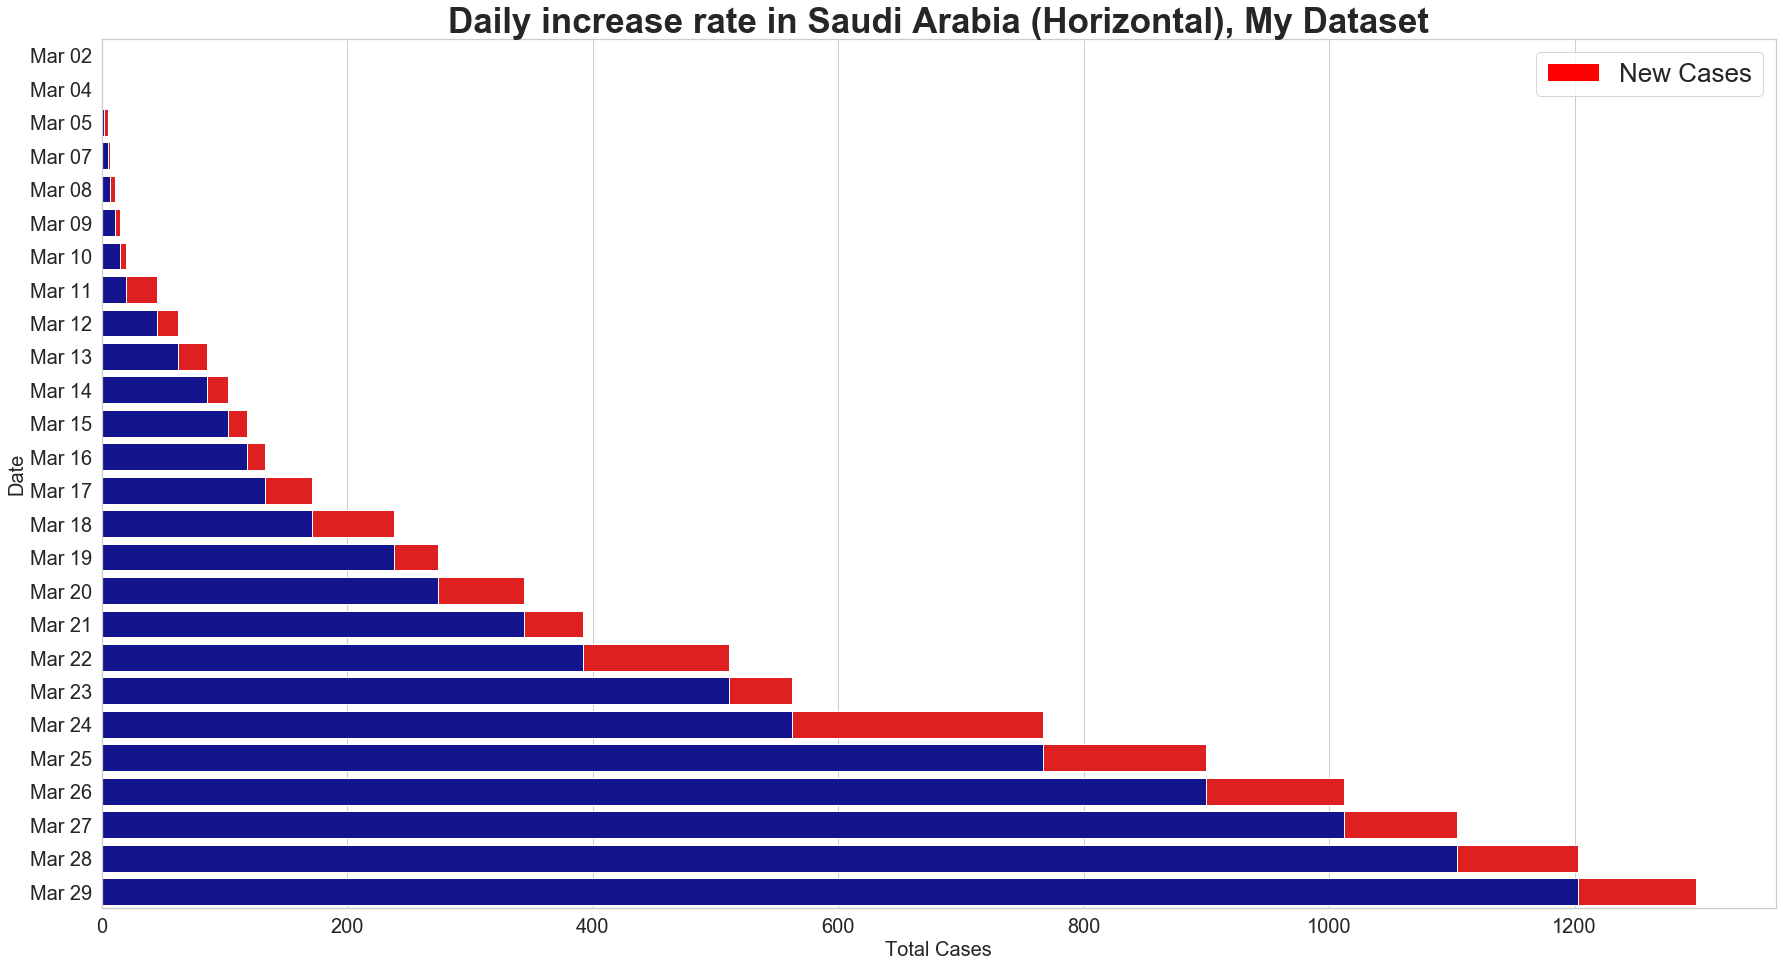

In [1743]:
saudi_cases = pd.read_excel('../data/corona_cases_ksa.xlsx')

saudi = saudi_cases.groupby(['date']).agg({'new_cases': sum, 'total_cases': max}).reset_index()
saudi['new_cases'] = saudi['total_cases'] - saudi['new_cases']
sns.set_style("whitegrid")

plt.figure(figsize = (30, 16))
plt.title('Daily increase rate in Saudi Arabia (Horizontal), My Dataset', fontsize = 35, weight='bold')
sns.barplot(y='date', x='total_cases', data=saudi, color='red', orient = 'h')

bottom_plot = sns.barplot(y='date', x='new_cases', data=saudi, color='#0000A3', orient = 'h')

plt.yticks(fontsize =20)
plt.xticks(fontsize =20)
plt.ylabel('Date', fontsize =20)
plt.xlabel('Total Cases', fontsize =20)
plt.legend(fontsize=26)

y_dates = saudi['date'].dt.strftime('%b %d').sort_values().unique()
bottom_plot.set_yticklabels(labels=y_dates, ha='right');

top_bar = plt.Rectangle((0, 0), 1, 1, fc='red')
plt.legend([top_bar], ['New Cases'], loc='upper right', ncol=1, prop={'size':26});

## Death Weekly growth

In [1744]:
iifs_d = death_dataset[death_dataset.location.isin(['Italy', 'Iran', 'Spain'])]

iifs_d['week'] = iifs_d.apply(lambda x: num_of_week(x['date'], x['location']), axis=1)
iifs_d = iifs_d.sort_values(['date', 'total_deaths'])
iifs_highest_d = iifs_d.nlargest(4, ['date', 'total_deaths']).reset_index()

weekly_iifs_d = iifs_d[iifs_d.total_deaths > 0].sort_values("date").drop_duplicates(subset =['location', 'week'], keep = 'last') 

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


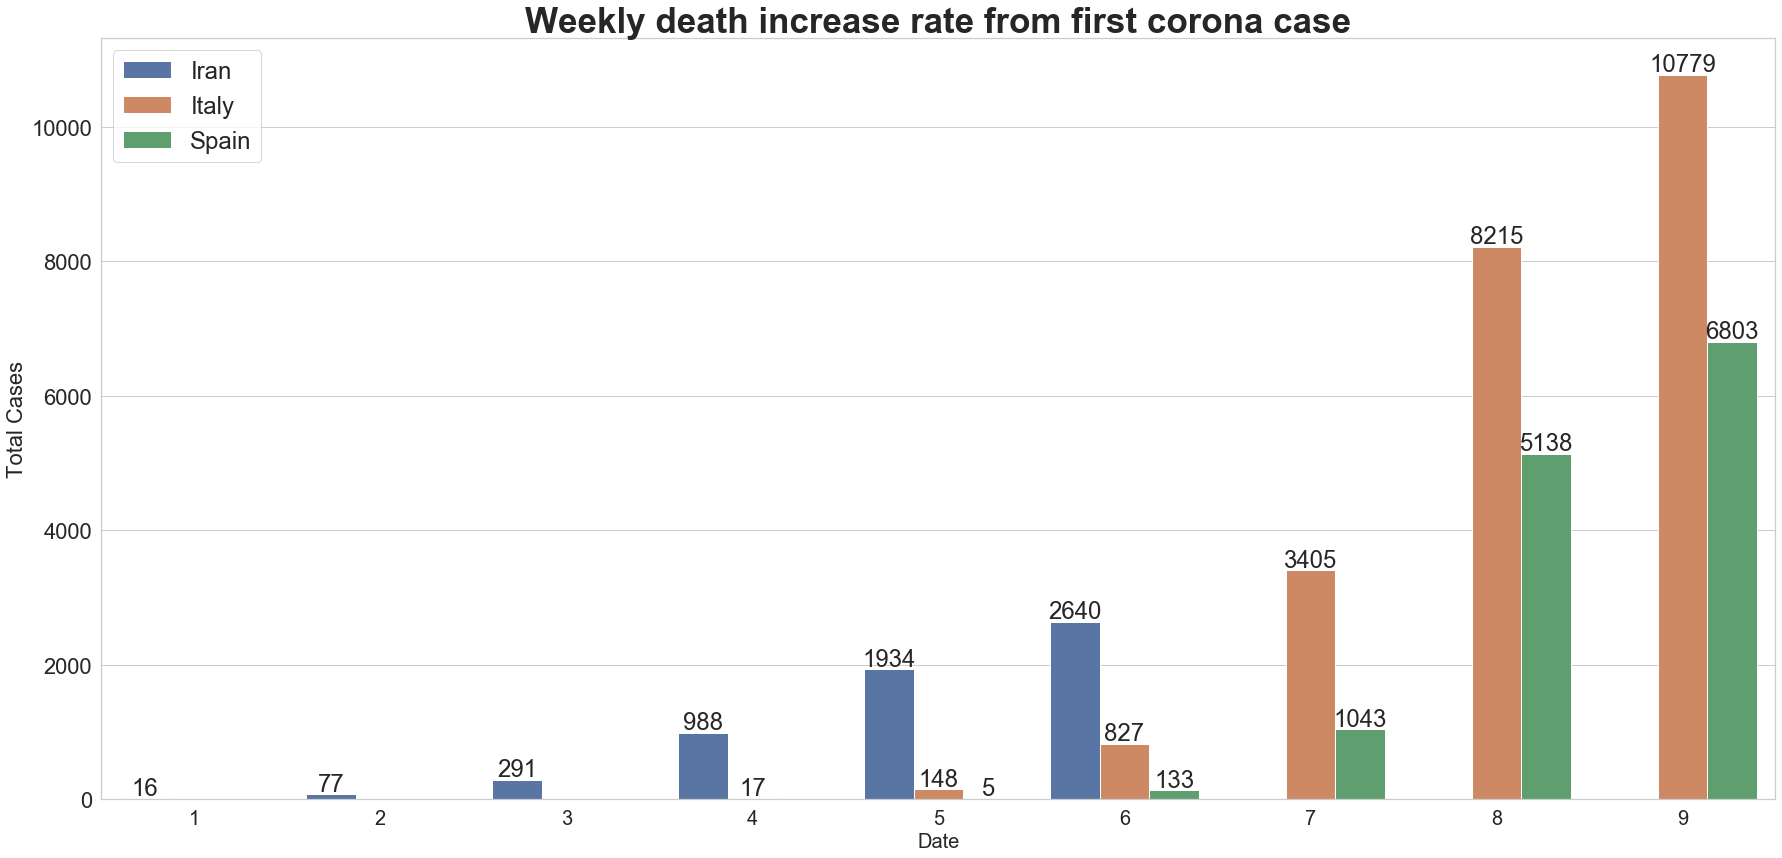

In [1748]:
plt.figure(figsize = (30, 14))
plt.title('Weekly death increase rate from first corona case', fontsize = 35, weight='bold')

sns.set(font_scale = 2)
sns.set_style("whitegrid")
ax = sns.barplot(x="week", y="total_deaths", hue="location", ci=None,  data=weekly_iifs_d)

plt.xticks(fontsize =20)
plt.yticks(fontsize =22)

plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=24, loc='upper left')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

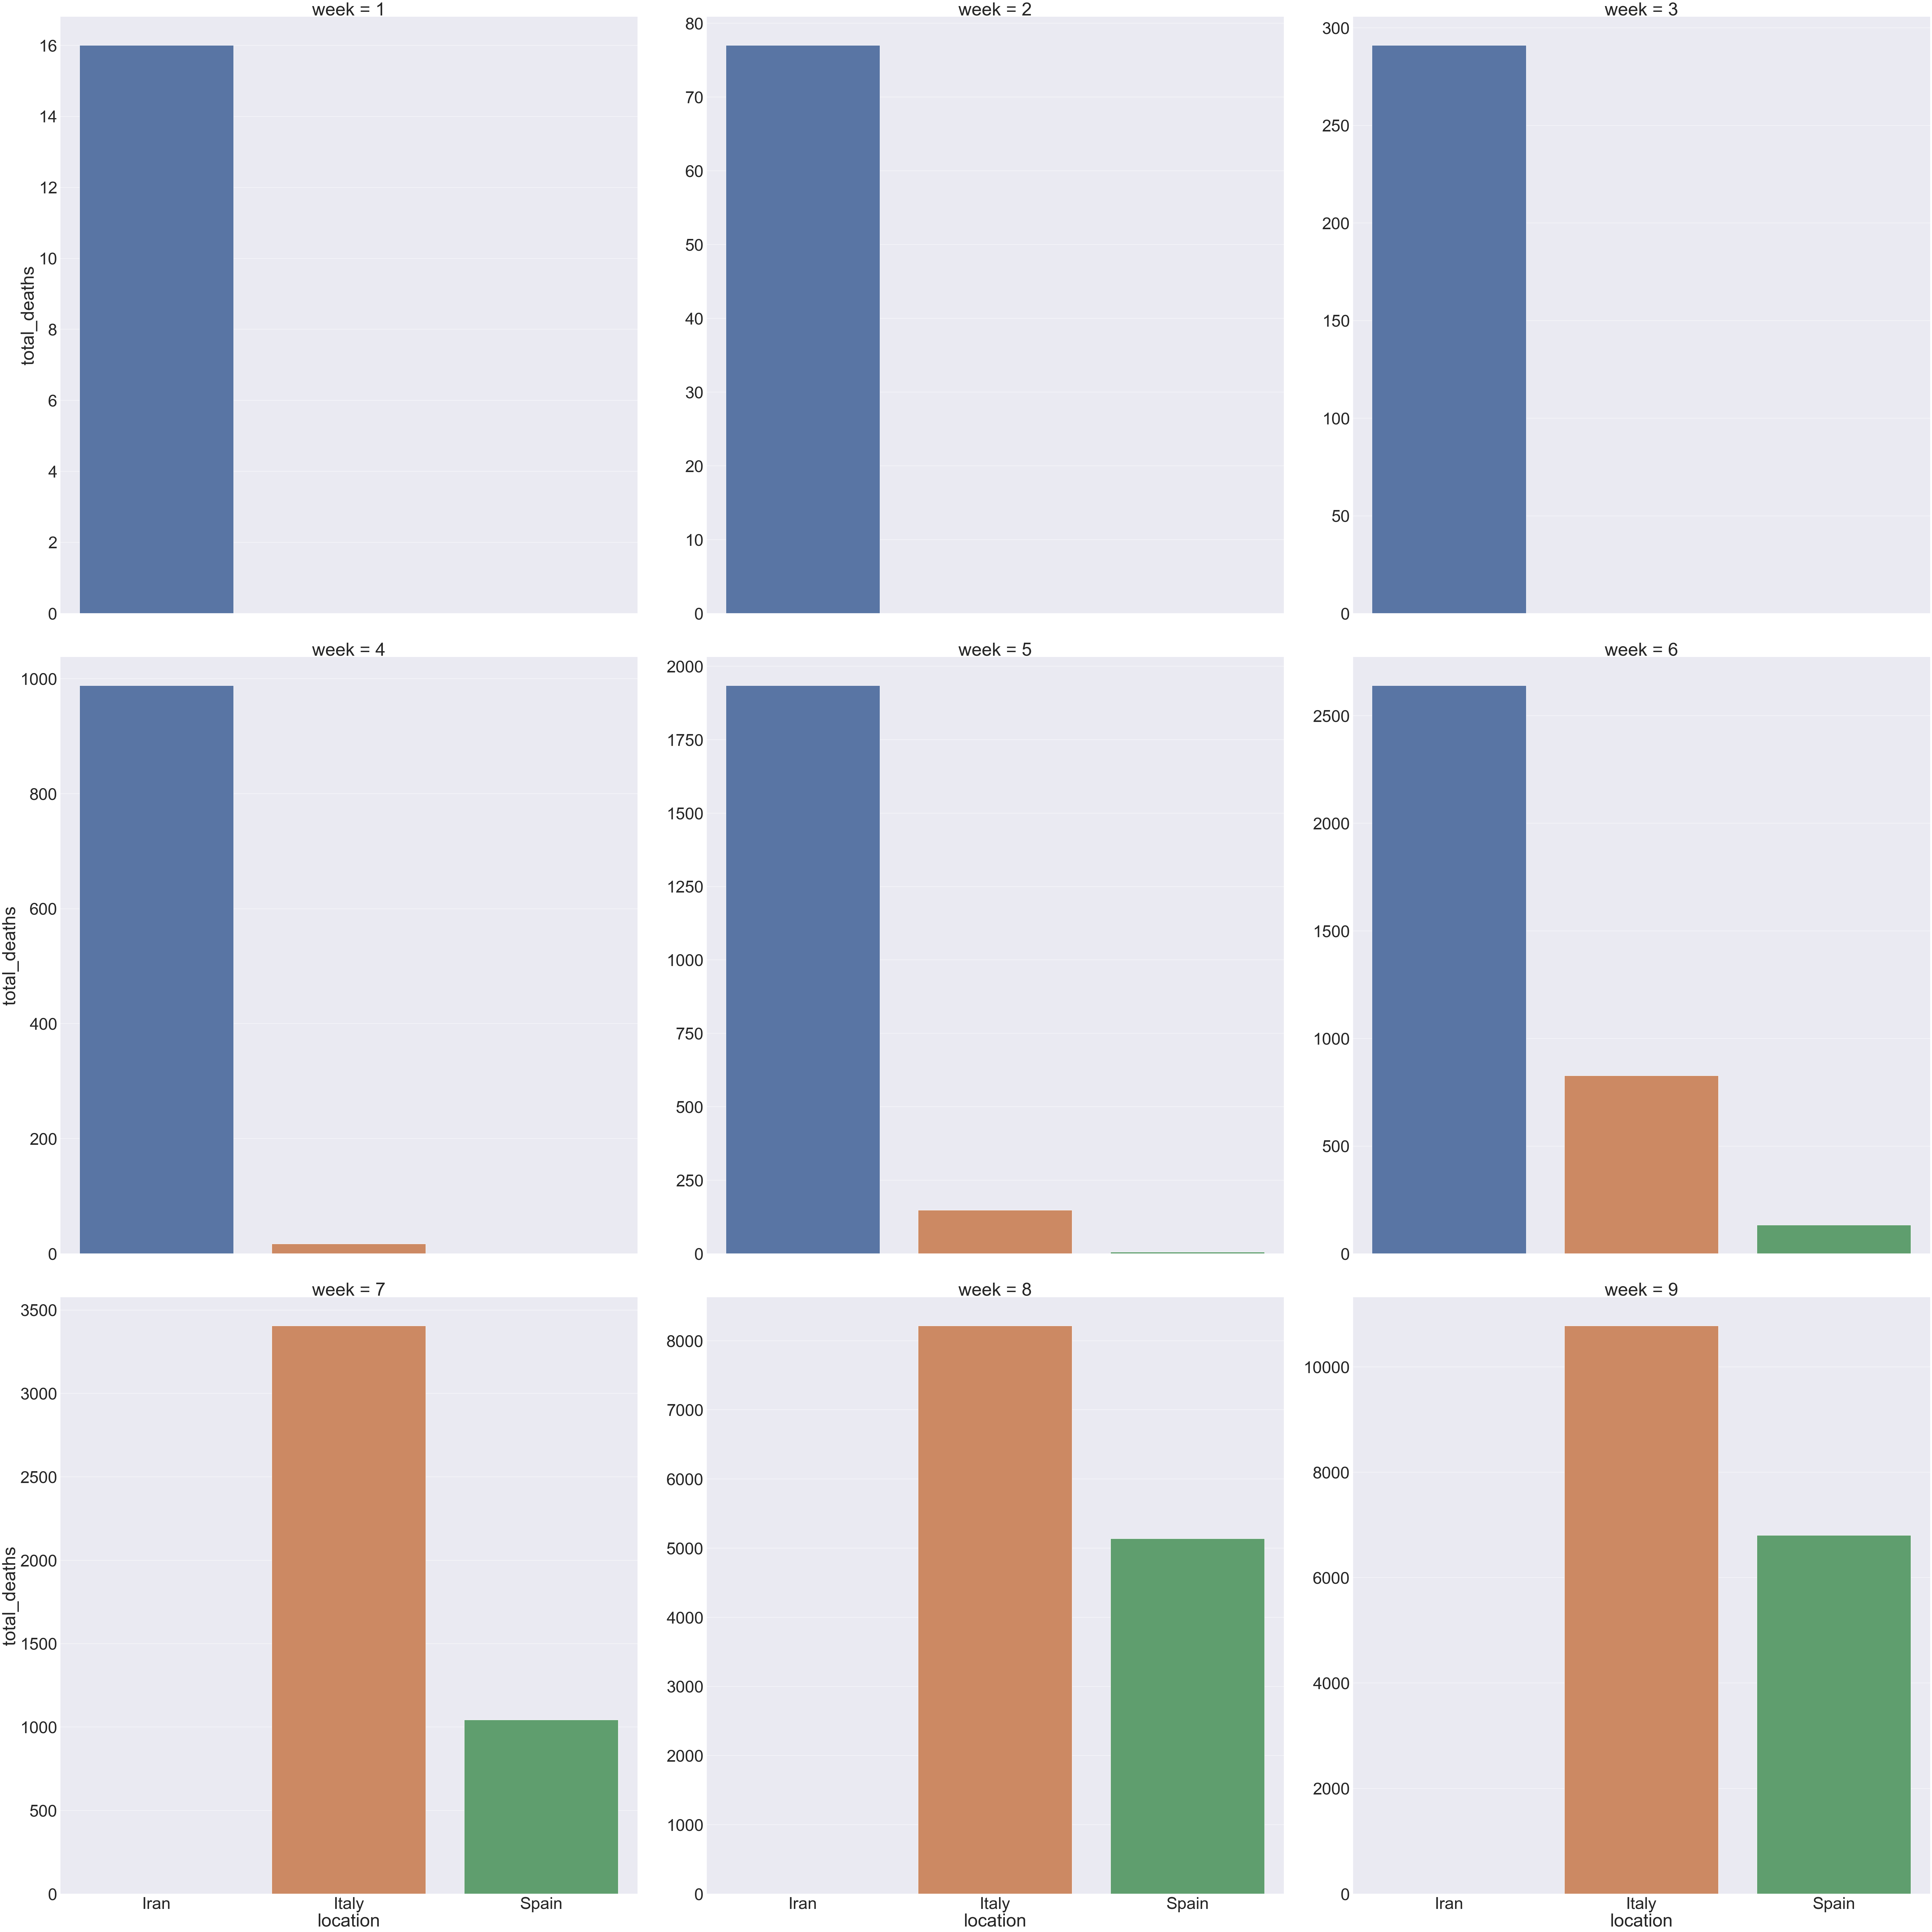

In [1751]:
sns.set(font_scale = 5)

g = sns.catplot(x="location", 
                y="total_deaths", 
                col="week", 
                kind="bar", 
                data=weekly_iifs_d, 
                col_wrap=3, height=30, aspect=1, 
                sharey=False);

## Rate of MOH Hospital Beds by Health Regions during 1439H


In [1752]:
MOH_hospital_beds = pd.read_excel('../data/rate_of_moh_hospital_beds.xlsx')
MOH_hospital_beds

المنطقة                      Name            Regions  \
0            الرياض                 Ar Riyad             Riyadh   
1   العاصمة المقدسة                   Makkah             Makkah   
2   المدينة المنوره               Al Madinah            Medinah   
3            القصيم               Al Quassim         Al Quassim   
4           الشرقيه            Ash Sharqiyah   Eastern province   
5              عسير                    `Asir               Asir   
6              تبوك                    Tabuk              Tabuk   
7              حائل                    Ha'il              Ha`il   
8   الحدود الشماليه  Al Hudud ash Shamaliyah  Northern Frontier   
9             جازان                    Jizan              Jizan   
10            نجران                   Najran             Najran   
11           الباحه                 Al Bahah           Al Bahah   
12            الجوف                  Al Jawf            Al Jawf   

    total_population  hospital_beds  population_rate  
0            8446866           8337         9.869933  
1            8803545           8825        10.024371  
2            2188138           2768        12.650025  
3            1455693           2859        19.640130  
4            5028753           6311        12.549831  
5            2261618           3100        13.707001  
6             930507           1820        19.559230  
7             716021           1790        24.999267  
8             375310           1360        36.236711  
9            1603659           2225        13.874521  
10            595705           1300        21.822882  
11            487108           1165        23.916667  
12            520737           1820        34.950464

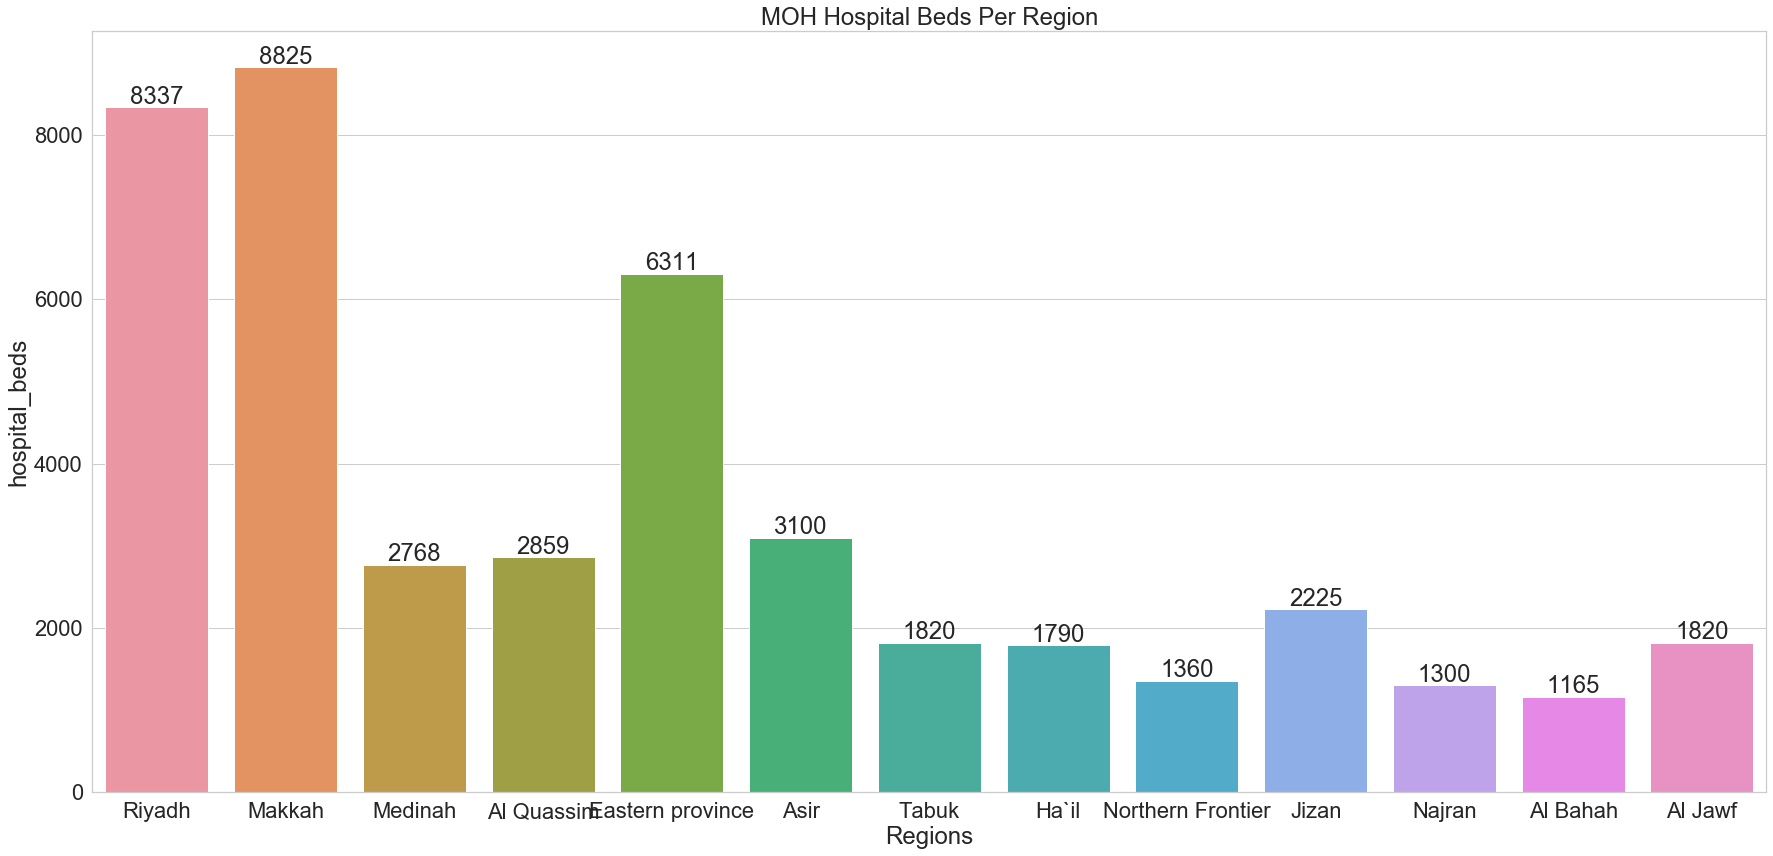

In [1756]:
plt.figure(figsize = (30, 14))
plt.title('MOH Hospital Beds Per Region')
sns.set(font_scale = 2)
sns.set_style("whitegrid")

ax = sns.barplot(x="Regions", y="hospital_beds",  data=MOH_hospital_beds[MOH_hospital_beds.Regions != 'Total'])

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

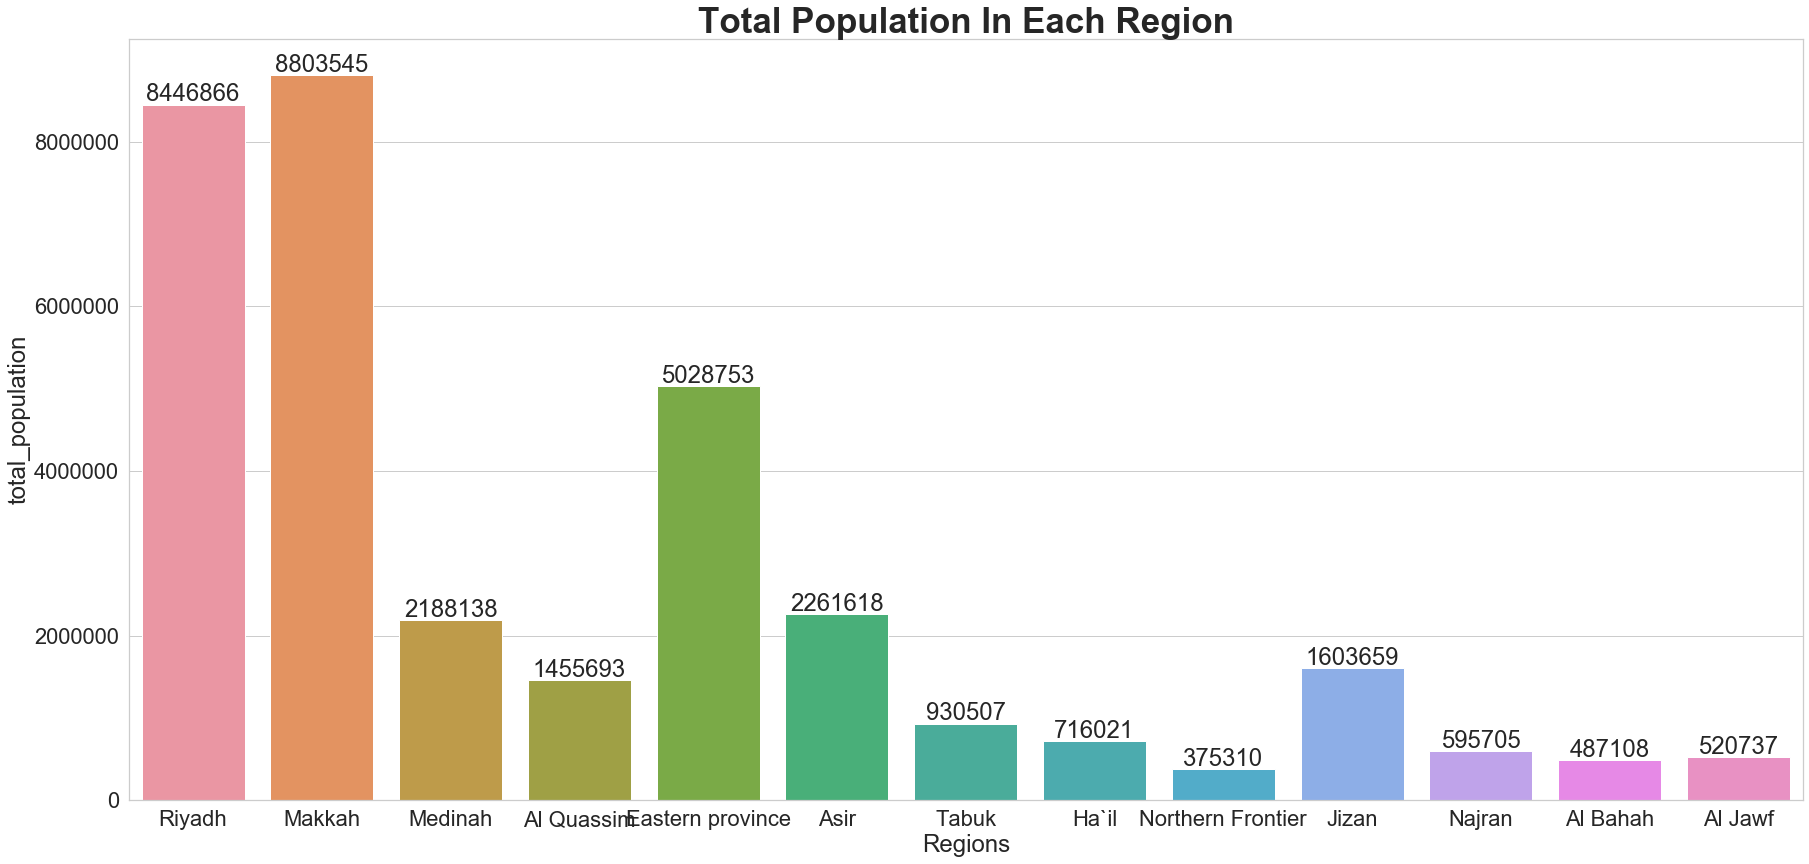

In [1755]:
plt.figure(figsize = (30, 14))
plt.title('Total Population In Each Region', fontsize = 35, weight='bold')
sns.set_style("whitegrid")

ax = sns.barplot(x="Regions", y="total_population",  data=MOH_hospital_beds[MOH_hospital_beds.Regions != 'Total'])

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

## Cases In Saudi Arabia

In [1757]:
saudi_cases_detailed = pd.read_excel('../data/corona_cases_ksa.xlsx')
saudi_cases_detailed

date            city          province  total_cases  new_cases  \
0   2020-03-02           Qatif  Eastern province            1          1   
1   2020-03-04           Qatif  Eastern province            2          1   
2   2020-03-05           Qatif  Eastern province            5          3   
3   2020-03-07           Qatif  Eastern province            6          1   
4   2020-03-07           Qatif  Eastern province            7          1   
..         ...             ...               ...          ...        ...   
196 2020-03-29      Ras Tanura  Eastern province         1295          1   
197 2020-03-29          Altaif            Makkah         1296          1   
198 2020-03-29           Ahsaa  Eastern province         1297          1   
199 2020-03-29  Khamis Mushait              Asir         1298          1   
200 2020-03-29           Tabuk             Tabuk         1299          1   

     from nationality       map_name  
0    Iran       Saudi  Ash Sharqiyah  
1    Iran       Saudi  Ash Sharqiyah  
2    Iran       Saudi  Ash Sharqiyah  
3    Iran       Saudi  Ash Sharqiyah  
4    Iraq       Saudi  Ash Sharqiyah  
..    ...         ...            ...  
196   NaN         NaN  Ash Sharqiyah  
197   NaN         NaN         Makkah  
198   NaN         NaN  Ash Sharqiyah  
199   NaN         NaN          `Asir  
200   NaN         NaN         Tabouk  

[201 rows x 8 columns]

In [1758]:
saudi_province = saudi_cases_detailed.groupby(['date', 'province']).agg({'new_cases': sum, 'total_cases': max}).reset_index()
saudi_province

date          province  new_cases  total_cases
0  2020-03-02  Eastern province          1            1
1  2020-03-04  Eastern province          1            2
2  2020-03-05  Eastern province          3            5
3  2020-03-07  Eastern province          2            7
4  2020-03-08  Eastern province          4           11
..        ...               ...        ...          ...
89 2020-03-29  Eastern province         24         1297
90 2020-03-29            Makkah         20         1296
91 2020-03-29           Medinah         23         1267
92 2020-03-29            Riyadh         27         1230
93 2020-03-29             Tabuk          1         1299

[94 rows x 4 columns]

In [1759]:
saudi_cases = pd.read_excel('../data/saudi_cases.xlsx')
saudi_cases = saudi_cases.fillna(0)

In [1760]:
saudi_cases['local'] = saudi_cases['local'] + saudi_cases['imported']

No handles with labels found to put in legend.


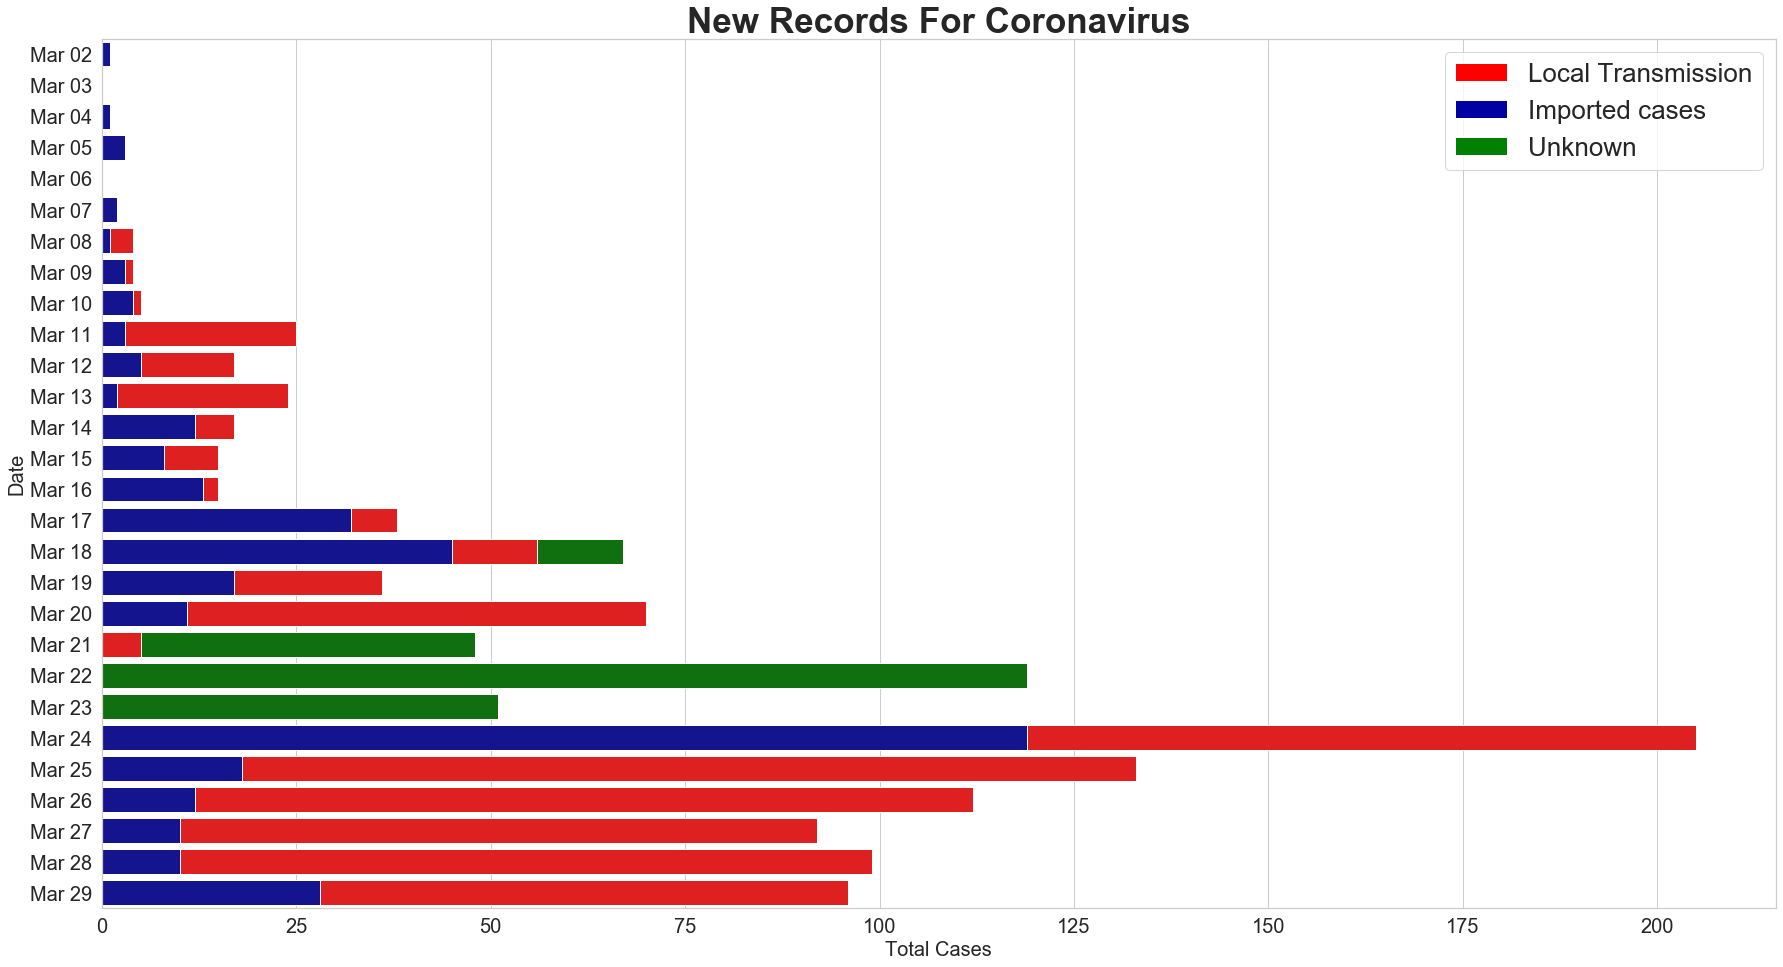

In [1761]:

plt.figure(figsize = (30, 16))
plt.title('New Records For Coronavirus', fontsize = 35, weight='bold')

sns.barplot(y='date', x='new_cases', data=saudi_cases, color='green', orient = 'h')

mid_plot = sns.barplot(y='date', x='local', data=saudi_cases, color='red', orient = 'h')

bottom_plot = sns.barplot(y='date', x='imported', data=saudi_cases, color='#0000A3', orient = 'h')

sns.set(font_scale = 3)
sns.set_style("whitegrid")

plt.yticks(fontsize =20)
plt.xticks(fontsize =20)
plt.ylabel('Date', fontsize =20)
plt.xlabel('Total Cases', fontsize =20)
plt.legend(fontsize=26)

y_dates = saudi_cases['date'].dt.strftime('%b %d').sort_values().unique()
bottom_plot.set_yticklabels(labels=y_dates, ha='right');



top_bar = plt.Rectangle((0, 0), 1, 1, fc='red')
mid_bar = plt.Rectangle((0, 0), 1, 1, fc='#0000A3')
idk = plt.Rectangle((0, 0), 1, 1, fc='green')

plt.legend([top_bar, mid_bar, idk], ['Local Transmission', 'Imported cases', 'Unknown'], loc='upper right', ncol=1, prop={'size':26});



/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
No handles with labels found to put in legend.


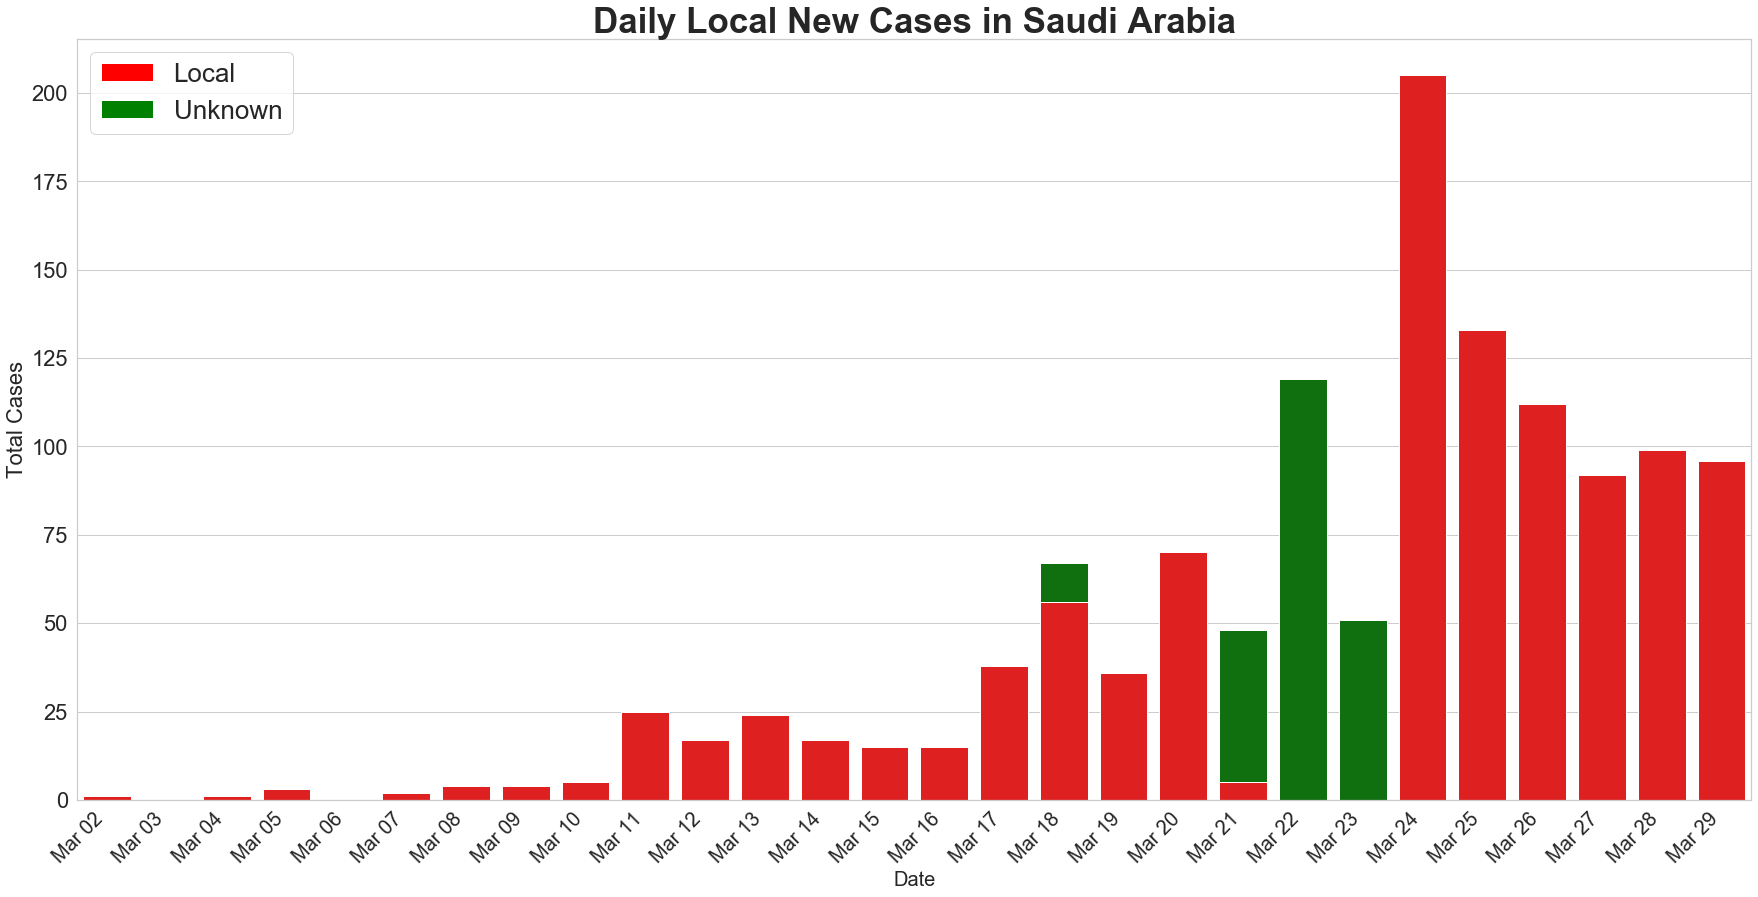

In [1762]:
saudi = gulf_countries[gulf_countries.location == 'Saudi Arabia']
saudi['new_cases'] = saudi['total_cases'] - saudi['new_cases']

plt.figure(figsize = (30, 14))
plt.title('Daily Local New Cases in Saudi Arabia', fontsize = 35, weight='bold')
sns.set_style("whitegrid")

sns.barplot(x='date', y='new_cases', data=saudi_cases, color='green')
bottom_plot = sns.barplot(x='date', y='local', data=saudi_cases, color='red')


plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)
plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=26)

x_dates = saudi_cases['date'].dt.strftime('%b %d').sort_values().unique()
bottom_plot.set_xticklabels(labels=x_dates, rotation=45, ha='right')

local = plt.Rectangle((0, 0), 1, 1, fc='red')
new_cases = plt.Rectangle((0, 0), 1, 1, fc='green')

plt.legend([local, new_cases], ['Local', 'Unknown'], loc='upper left', ncol=1, prop={'size':26});


No handles with labels found to put in legend.


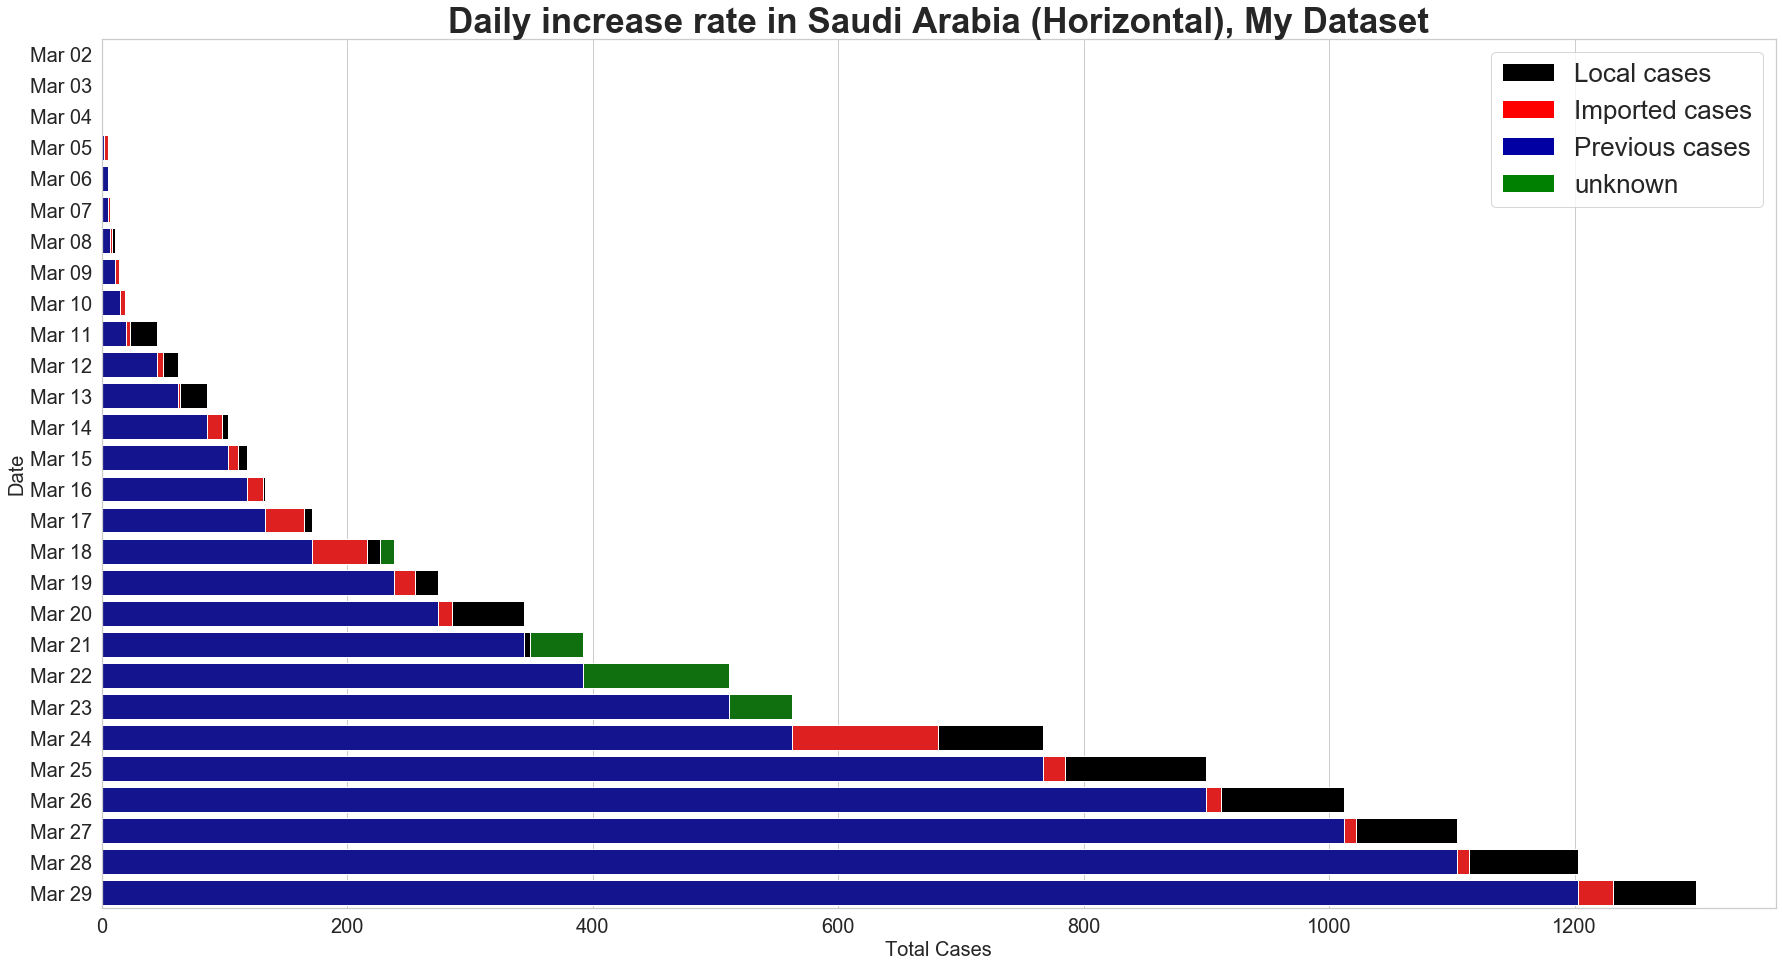

In [1763]:
saudi_cases = pd.read_excel('../data/saudi_cases.xlsx')
saudi_cases = saudi_cases.fillna(0)
saudi_cases['temp'] = saudi_cases['total_cases'] - saudi_cases['new_cases']
saudi_cases['local'] = saudi_cases['local'] + saudi_cases['imported'] + saudi_cases['temp']
saudi_cases['imported'] = saudi_cases['imported'] + saudi_cases['temp']

sns.set_style("whitegrid")

plt.figure(figsize = (30, 16))
plt.title('Daily increase rate in Saudi Arabia (Horizontal), My Dataset', fontsize = 35, weight='bold')
# sns.barplot(y='date', x='total_cases', data=saudi, color='red', orient = 'h')
new_unknown = sns.barplot(y='date', x='total_cases', data=saudi_cases, color='green', orient = 'h')

new_local = sns.barplot(y='date', x='local', data=saudi_cases, color='black', orient = 'h')

new_imported = sns.barplot(y='date', x='imported', data=saudi_cases, color='red', orient = 'h') 

total_old = sns.barplot(y='date', x='temp', data=saudi_cases, color='#0000A3', orient = 'h')

plt.yticks(fontsize =20)
plt.xticks(fontsize =20)
plt.ylabel('Date', fontsize =20)
plt.xlabel('Total Cases', fontsize =20)
plt.legend(fontsize=26)

y_dates = saudi_cases['date'].dt.strftime('%b %d').sort_values().unique()
total_old.set_yticklabels(labels=y_dates, ha='right');

new_unknown = plt.Rectangle((0, 0), 1, 1, fc='green')
new_local = plt.Rectangle((0, 0), 1, 1, fc='black')
new_imported = plt.Rectangle((0, 0), 1, 1, fc='red')
total_old = plt.Rectangle((0, 0), 1, 1, fc='#0000A3')

plt.legend([new_local, new_imported, total_old, new_unknown], ['Local cases', 'Imported cases', 'Previous cases', 'unknown'], loc='upper right', ncol=1, prop={'size':26});



## Hospital beds V.S Infected

In [1764]:
saudi_province_total = saudi_province.groupby(['province']).agg({'new_cases': sum}).reset_index()
saudi_province_total = saudi_province_total.rename(columns={'new_cases': 'total_cases'})
saudi_province_total

province  total_cases
0            Al Bahah           13
1          Al Quassim            4
2                Asir           29
3    Eastern province          310
4               Jizan            7
5              Makkah          339
6             Medinah           59
7              Najran           13
8   Northern Frontier            2
9              Riyadh          518
10              Tabuk            5

In [1765]:
province_hospital = pd.merge(saudi_province_total, MOH_hospital_beds[['Regions', 'hospital_beds', 'total_population']], left_on='province', right_on='Regions', how='left')
province_hospital = province_hospital.sort_values('total_cases', ascending=False)

No handles with labels found to put in legend.


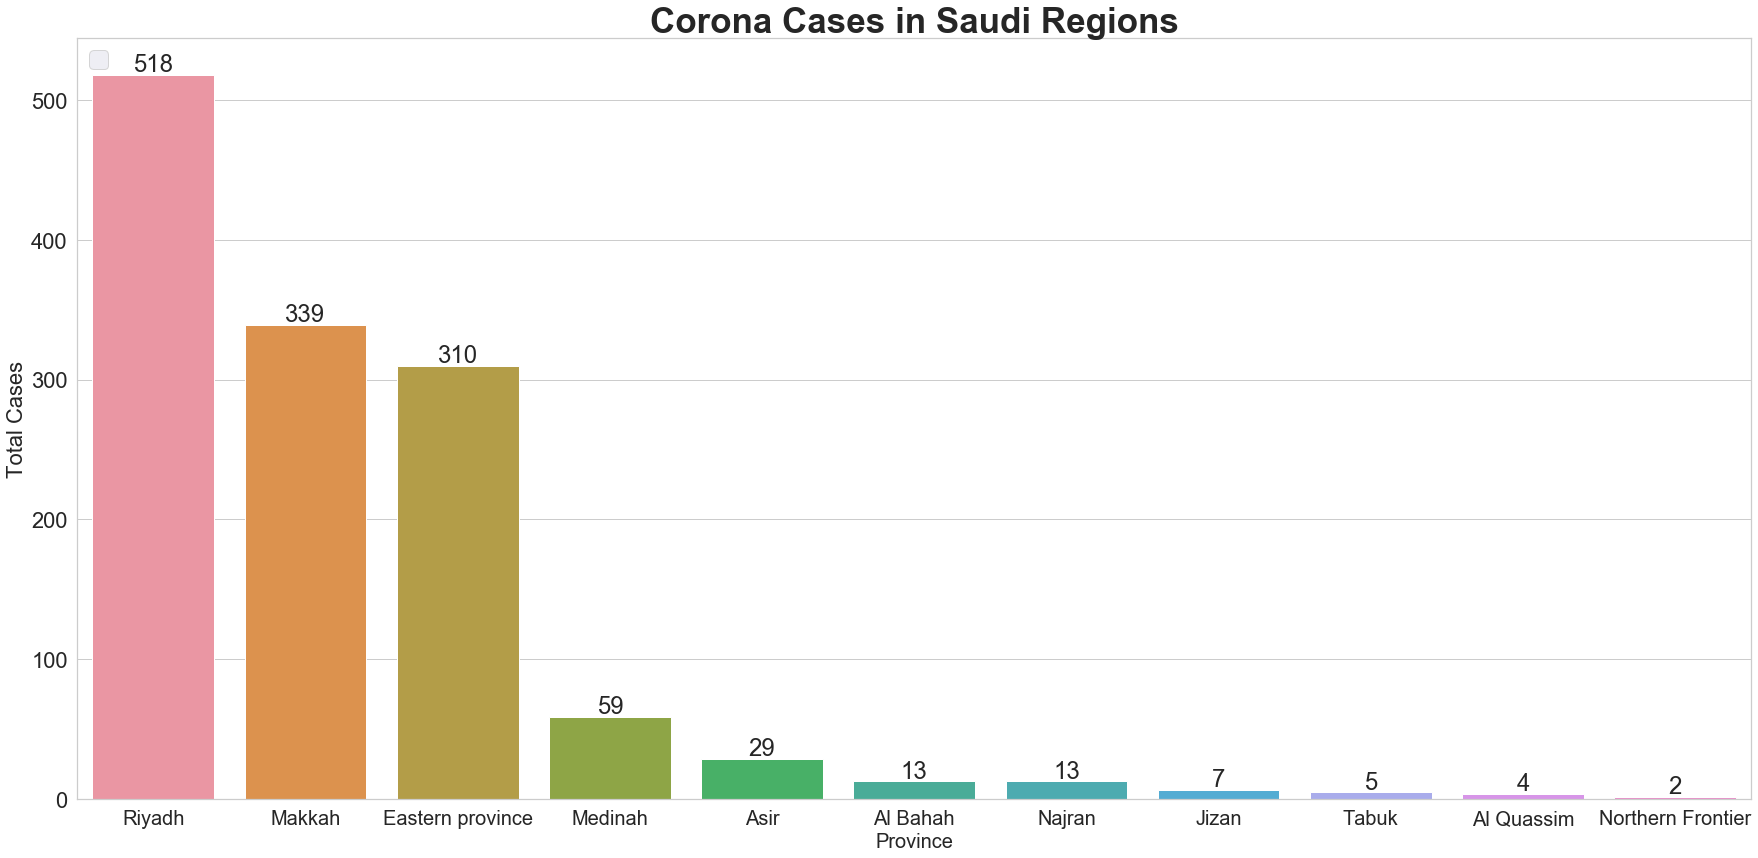

In [1766]:
plt.figure(figsize = (30, 14))
plt.title('Corona Cases in Saudi Regions', fontsize = 35, weight='bold')

ax = sns.barplot(x="province", y="total_cases", data=province_hospital)

sns.set_style("whitegrid")
sns.set(font_scale = 2)

plt.xticks(fontsize =20)
plt.yticks(fontsize =22)

plt.xlabel('Province', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=24, loc='upper left')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [1767]:
province_hospital['occupied'] = province_hospital['hospital_beds'] * 0.75
province_hospital['total_cases'] = province_hospital['total_cases'] + province_hospital['occupied']

No handles with labels found to put in legend.


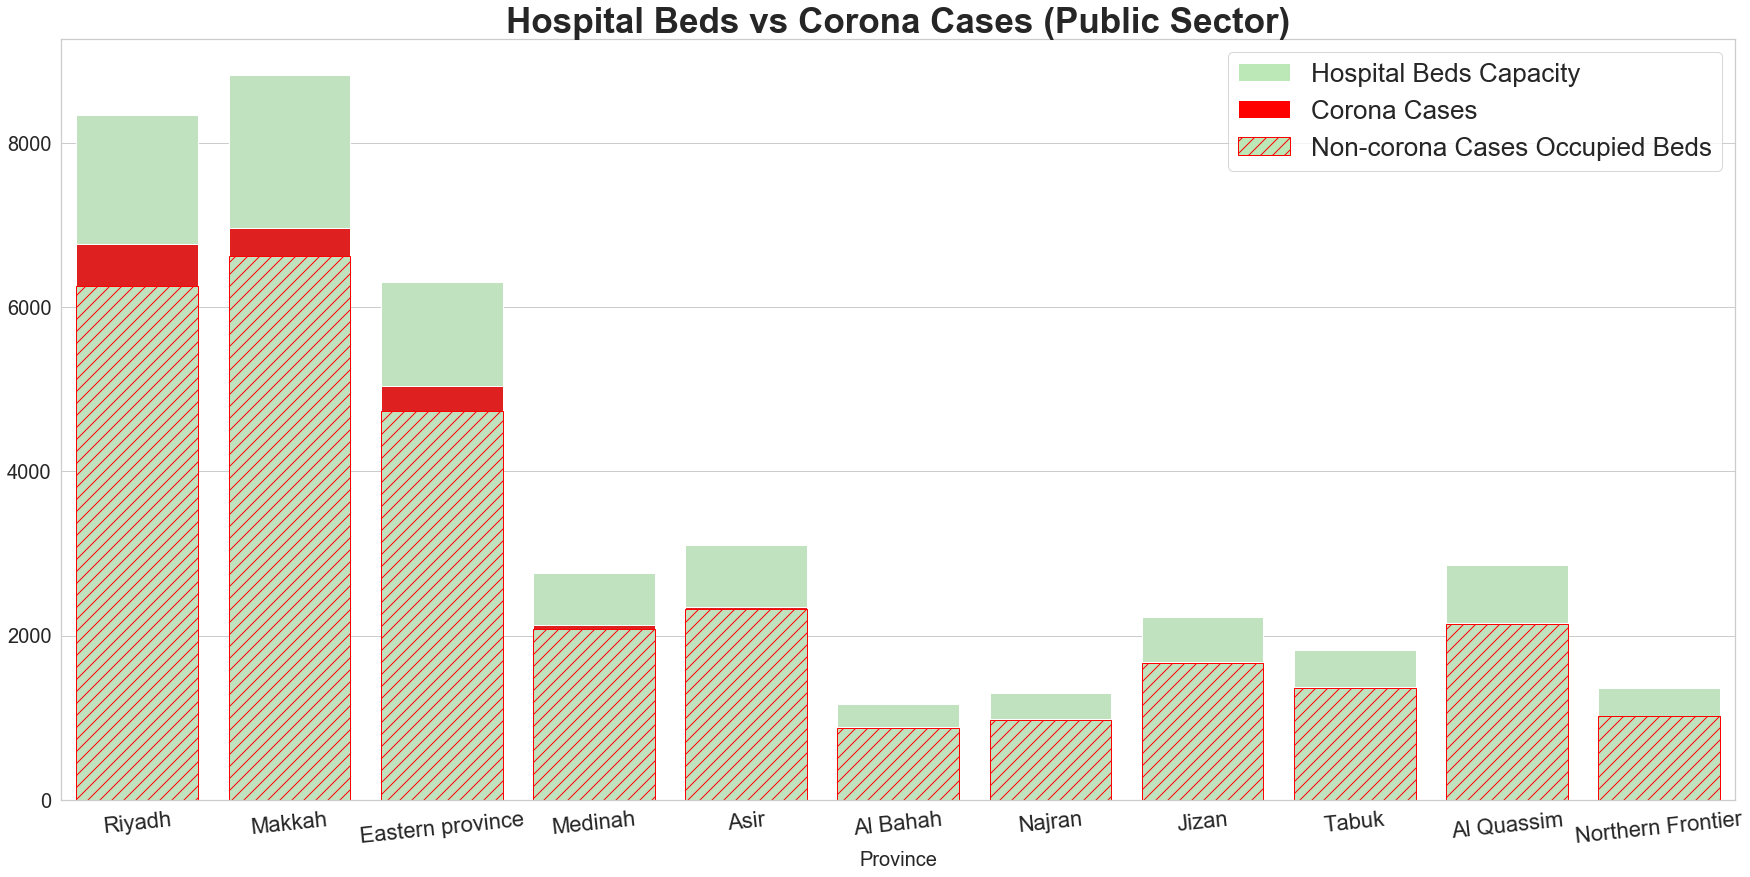

In [1769]:


plt.figure(figsize = (30, 14))

plt.title('Hospital Beds vs Corona Cases (Public Sector)', fontsize = 35, weight='bold')
sns.set_style("whitegrid")

ax = sns.barplot(x='province', y="hospital_beds", data=province_hospital, color='#BCE8B8')



sns.barplot(x='province', y="total_cases", data=province_hospital, color='red')
occupied = sns.barplot(x='province', y="occupied", data=province_hospital, color='#BCE8B8', hatch='//', edgecolor= "red")

sns.set(font_scale = 1.5)
sns.set_style("whitegrid")

plt.xticks(fontsize =22, rotation=6)
plt.yticks(fontsize =20)

plt.xlabel('Province', fontsize =20)
plt.ylabel('', fontsize =22)
plt.legend(fontsize=24, loc='upper right')
cases = plt.Rectangle((0, 0), 1, 1, fc='red')
hosp_space = plt.Rectangle((0, 0), 1, 1, fc='#BCE8B8')
occupied_beds = plt.Rectangle((0, 0), 1, 1, fc='#BCE8B8', hatch='//', edgecolor= "red")

plt.legend([hosp_space, cases, occupied_beds], ['Hospital Beds Capacity', 'Corona Cases', 'Non-corona Cases Occupied Beds'], loc='upper right', ncol=1, prop={'size':26});


No handles with labels found to put in legend.


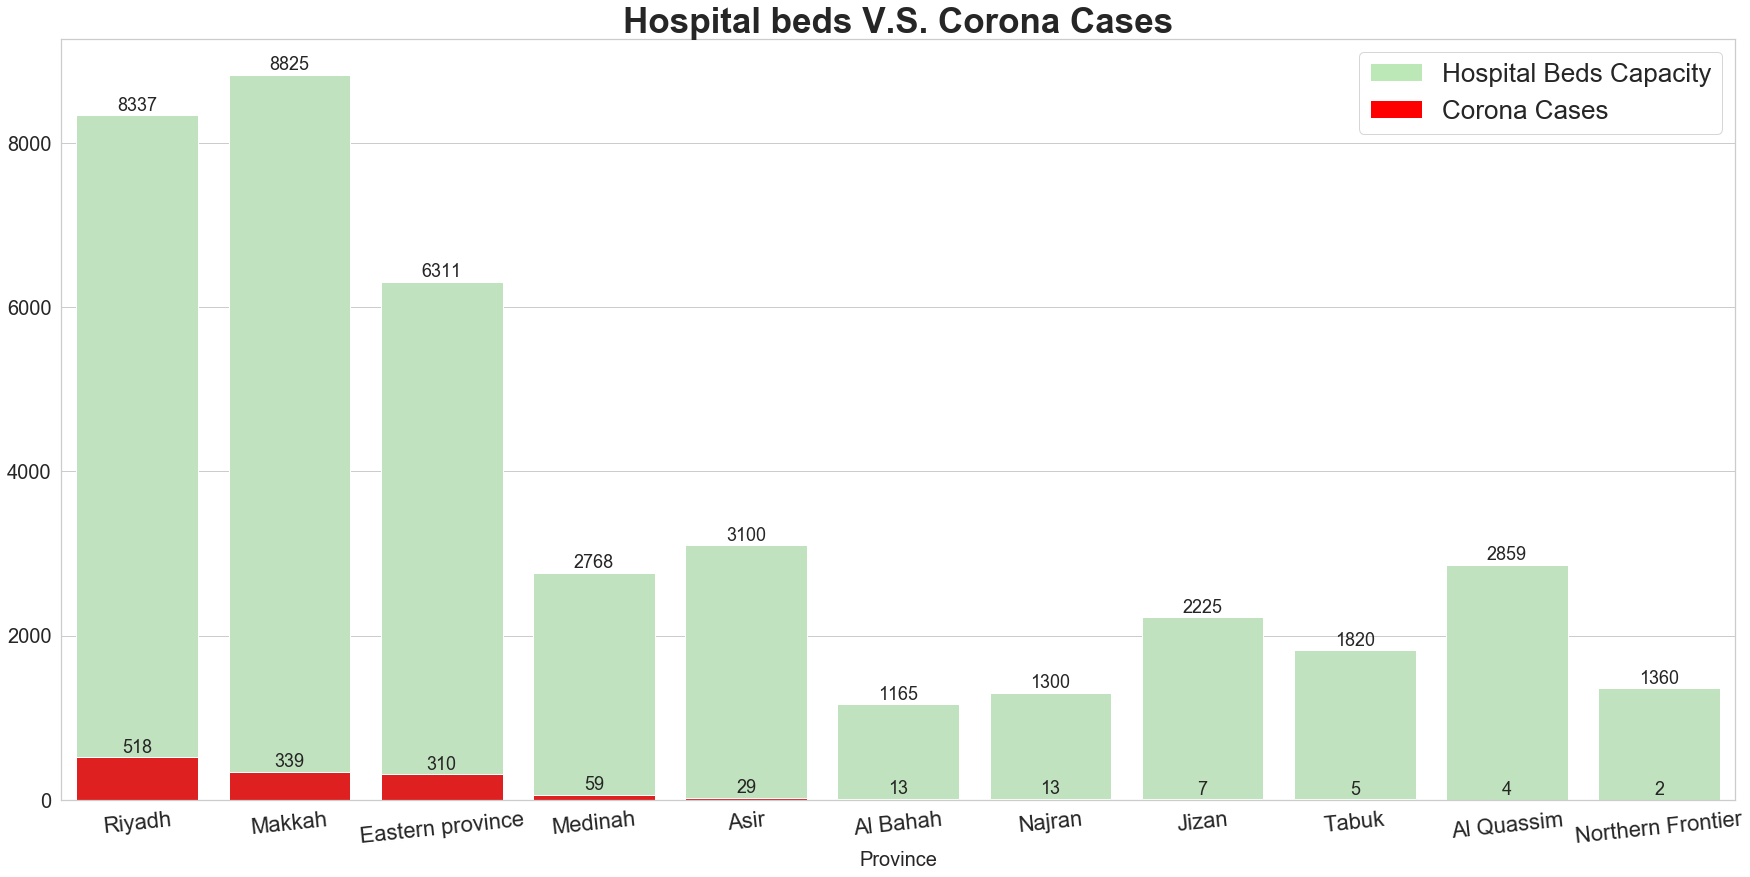

In [1772]:
plt.figure(figsize = (30, 14))

plt.title('Hospital beds V.S. Corona Cases', fontsize = 35, weight='bold')
sns.set_style("whitegrid")

ax = sns.barplot(x='province', y="hospital_beds", data=province_hospital, color='#BCE8B8')

sns.barplot(x='province', y="total_cases", data=province_hospital, color='red')


sns.set(font_scale = 1.5)
sns.set_style("whitegrid")

plt.xticks(fontsize =22, rotation=6)
plt.yticks(fontsize =20)

plt.xlabel('Province', fontsize =20)
plt.ylabel('', fontsize =22)
plt.legend(fontsize=24, loc='upper right')
cases = plt.Rectangle((0, 0), 1, 1, fc='red')
hosp_space = plt.Rectangle((0, 0), 1, 1, fc='#BCE8B8')

plt.legend([hosp_space, cases], ['Hospital Beds Capacity', 'Corona Cases'], loc='upper right', ncol=1, prop={'size':26});

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

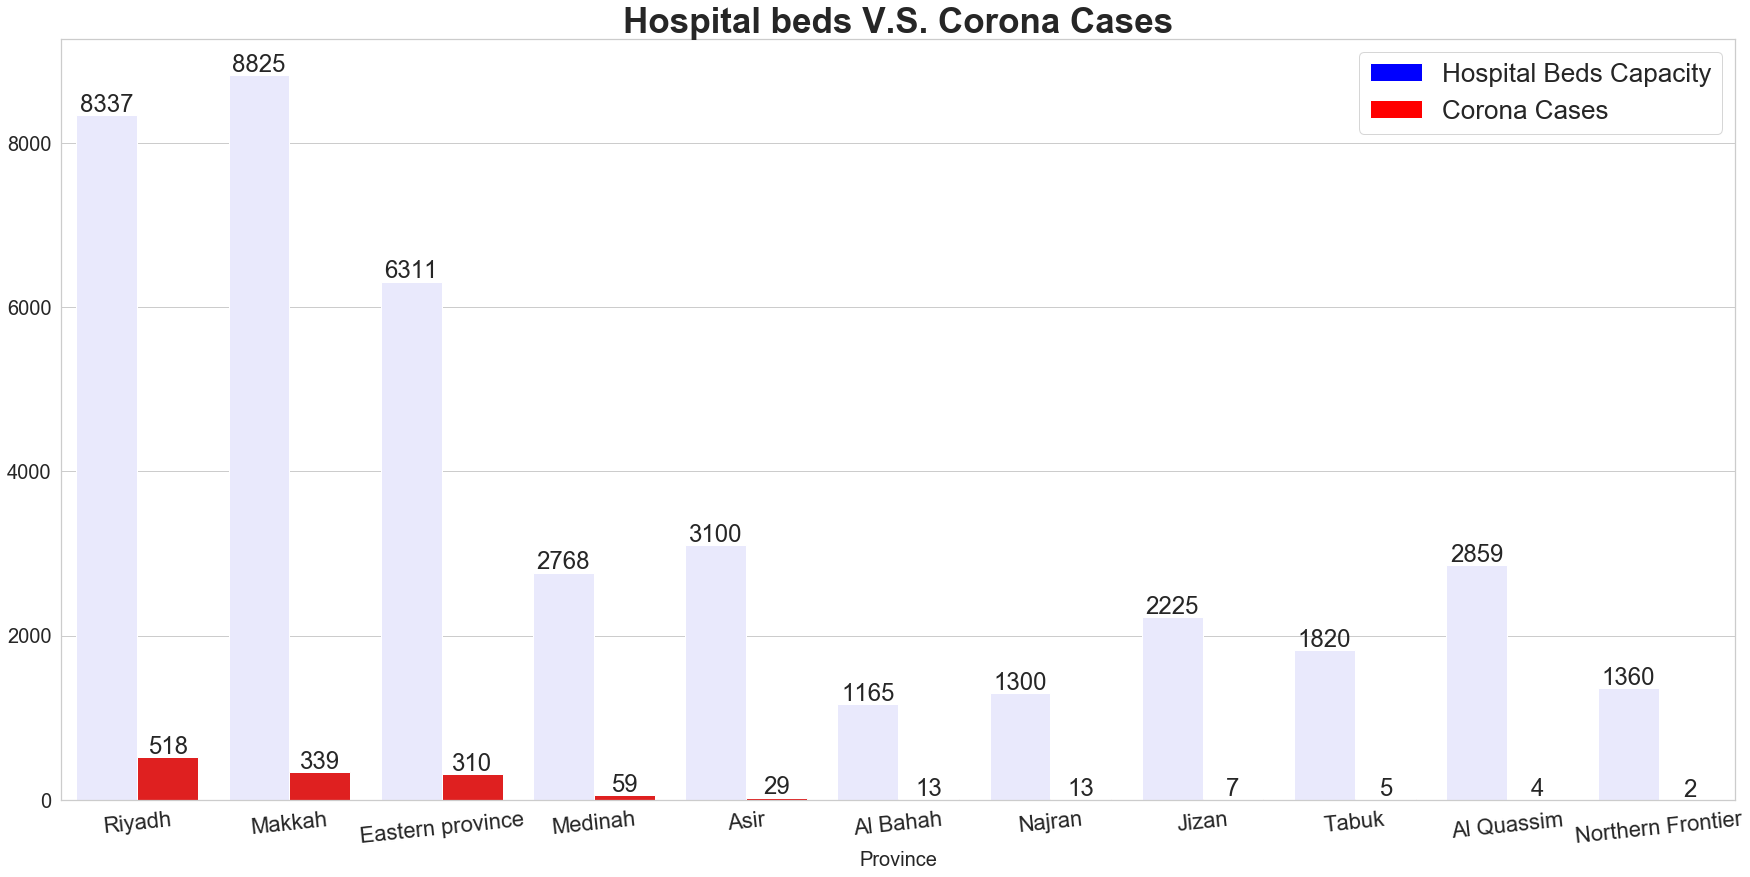

In [1771]:
province_hospital.loc[:,'dummy'] = 'dummy'
province_hospital['total_cases'] = province_hospital['total_cases'] - province_hospital['occupied']

plt.figure(figsize = (30, 14))
plt.title('Hospital beds V.S. Corona Cases', fontsize = 35, weight='bold')
sns.set_style("whitegrid")

ax = sns.barplot(x='province', y="hospital_beds", hue='dummy',  data=province_hospital, color='blue', hue_order=['dummy','total_cases'])
# ax2 = ax.twinx()
ax2 = sns.barplot(x='province', y="total_cases", hue='dummy', data=province_hospital, color='red', hue_order=['hospital_beds','dummy'])

sns.set(font_scale = 2)
sns.set_style("whitegrid")

plt.xticks(fontsize =22, rotation=6)
plt.yticks(fontsize =20)

plt.xlabel('Province', fontsize =20)
plt.ylabel('', fontsize =22)
plt.legend(fontsize=24, loc='upper right')
cases = plt.Rectangle((0, 0), 1, 1, fc='red')
hosp_space = plt.Rectangle((0, 0), 1, 1, fc='blue')

plt.legend([hosp_space, cases], ['Hospital Beds Capacity', 'Corona Cases'], loc='upper right', ncol=1, prop={'size':26});

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [1657]:
saudi_cities = saudi_cases_detailed[['date', 'city', 'new_cases']]
saudi_cities = saudi_cities.groupby(['date', 'city']).agg({'new_cases': sum}).reset_index()
saudi_cities['total_cases'] = saudi_cities.groupby('city').new_cases.cumsum() 

saudi_cities_largest = saudi_cities.nlargest(4, ['date', 'total_cases']).reset_index()

In [1677]:
important_dates = [
    (pd.to_datetime('2020-03-08'), ['* Schools on hold\n', '* Closing Qatif']),
    (pd.to_datetime('2020-03-15'), ['* Hold on International flights']),
    (pd.to_datetime('2020-03-16'), ['\n','\n    * Working Remotely' ]),
    (pd.to_datetime('2020-03-23'), ['* Applying curfew on all regons'])
    
]

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


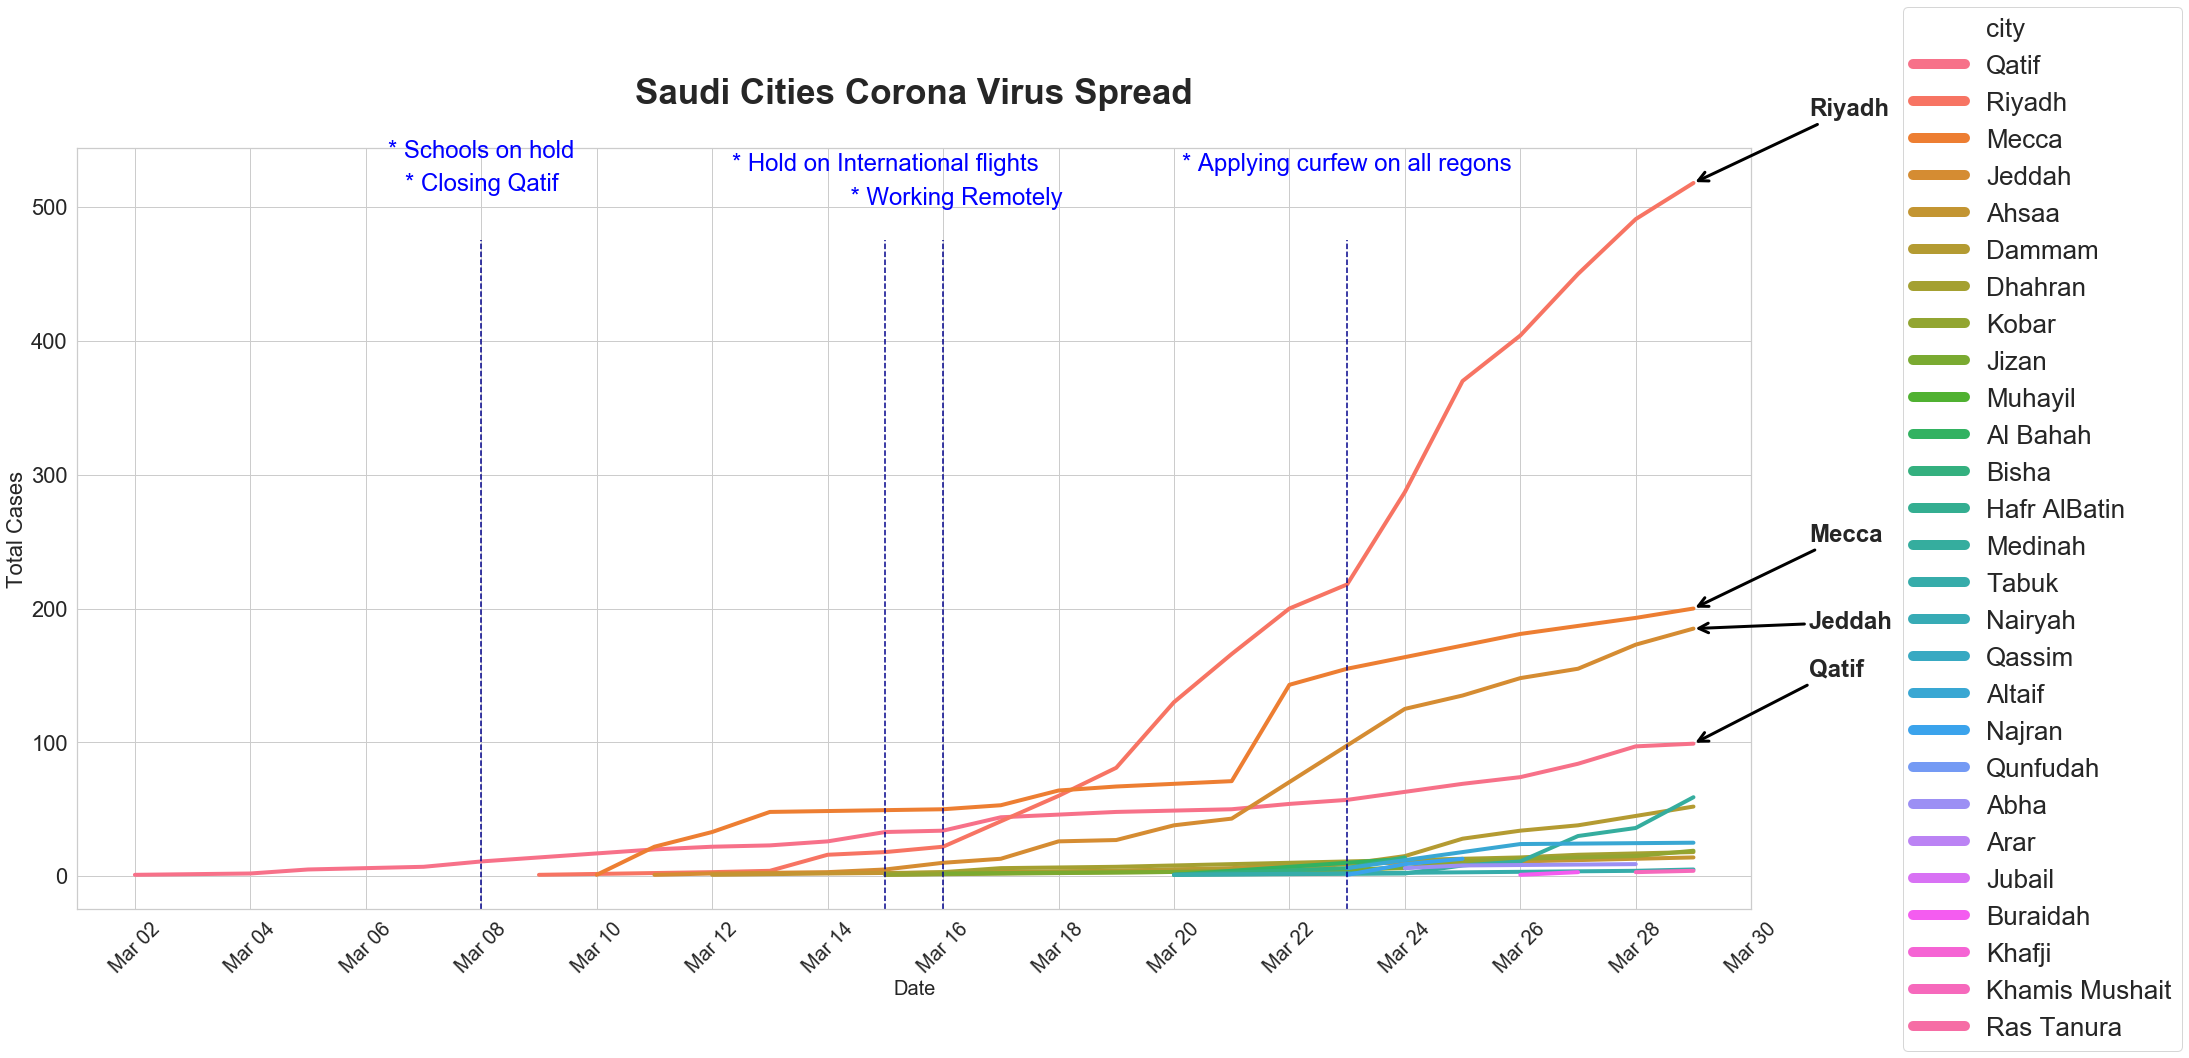

In [1690]:
plt.figure(figsize = (30, 14))
plt.title('Saudi Cities Corona Virus Spread\n', fontsize = 35, weight='bold')

ax = sns.lineplot(x="date", y="total_cases", hue="city", legend='brief',  data=saudi_cities, linewidth=4)

sns.set(font_scale = 3)
sns.set_style("whitegrid")

ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

ax.set_xlim([saudi_cities.date.min() - datetime.timedelta(days=1), saudi_cities.date.max() + datetime.timedelta(days=1)])

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)

plt.xlabel('Date', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)

for i in range(4):
    if i == 2:
        ax.annotate(saudi_cities_largest.iloc[i].city, 
                xy=(saudi_cities.date.max(), saudi_cities_largest.iloc[i].total_cases), fontsize=24, weight='bold',
                xytext=(saudi_cities.date.max() + datetime.timedelta(days=2),
                        saudi_cities_largest.iloc[i].total_cases), 
                arrowprops=dict(facecolor='black', arrowstyle="->", color='black', linewidth=3));
    else:
        ax.annotate(saudi_cities_largest.iloc[i].city, 
                xy=(saudi_cities.date.max(), saudi_cities_largest.iloc[i].total_cases), fontsize=24, weight='bold',
                xytext=(saudi_cities.date.max() + datetime.timedelta(days=2),
                        saudi_cities_largest.iloc[i].total_cases + 50), 
                arrowprops=dict(facecolor='black', arrowstyle="->", color='black', linewidth=3));

for date_point, labels, in important_dates:
    plt.axvline(x=date_point, ls='--', color='darkblue', ymax=0.88)
    i = 0
    for label in labels:
        plt.text(date_point, ax.get_ylim()[1]-12 - (i*15), label,
             horizontalalignment='center',
             verticalalignment='center',
             color='blue',
             fontsize=24
             )
        i = i + 1

leg = ax.legend(loc='center right', bbox_to_anchor=(1.265, 0.5), ncol=1, prop={'size':26});

for line in leg.get_lines():
    line.set_linewidth(10)
    
# plt.savefig('Saudi Cities Corona Virus Spread.png', dpi=300)
ax.figure.savefig("Saudi Cities Corona Virus Spread.png")

### Saudi Population

In [1594]:
saudi_population = pd.read_excel('../data/saudi_population_2018.xlsx', header=[0,1])
saudi_population

Age group     Saudi                     Non-Saudi           \
   Unnamed: 0_level_1      MALE    FEMALE     Total      MALE   FEMALE   
0               4 - 0   1123261   1084529   2207790    298126   283015   
1               9 - 5   1097810   1060664   2158474    377142   360021   
2             14 - 10    979511    952700   1932211    310548   293553   
3             19 - 15    926156    894846   1821002    254562   237191   
4             24 - 20   1072129    980185   2052314    300596   223588   
5             29 - 25    996017    975252   1971269    764993   453068   
6             34 - 30    896790    881961   1778751   1001237   450453   
7             39 - 35    786779    768617   1555396   1470571   579037   
8             44 - 40    665841    641244   1307085   1388695   528066   
9             49 - 45    559539    529550   1089089   1021389   283517   
10            54 - 50    446271    421928    868199    695508   106590   
11            59 - 55    348081    319715    667796    416427    69675   
12            64 - 60    252157    235932    488089    222927    49848   
13            69 - 65    153429    162787    316216     77344    30741   
14            74 - 70    111979    114965    226944     35395    19851   
15            79 - 75     72990     74509    147499     16526     4882   
16               + 80     87155     93348    180503     13075     6876   
17              Total  10575895  10192732  20768627   8665061  3979972   

                 Total                      
       Total      MALE    FEMALE     Total  
0     581141   1421387   1367544   2788931  
1     737163   1474952   1420685   2895637  
2     604101   1290059   1246253   2536312  
3     491753   1180718   1132037   2312755  
4     524184   1372725   1203773   2576498  
5    1218061   1761010   1428320   3189330  
6    1451690   1898027   1332414   3230441  
7    2049608   2257350   1347654   3605004  
8    1916761   2054536   1169310   3223846  
9    1304906   1580928    813067   2393995  
10    802098   1141779    528518   1670297  
11    486102    764508    389390   1153898  
12    272775    475084    285780    760864  
13    108085    230773    193528    424301  
14     55246    147374    134816    282190  
15     21408     89516     79391    168907  
16     19951    100230    100224    200454  
17  12645033  19240956  14172704  33413660

In [1595]:
saudi_population = pd.read_excel('../data/saudi_population_2018.xlsx', sheet_name='Sheet1')
saudi_population

age_group  saudi_male  saudi_female  total_saudi  non_saudi_male  \
0      4 - 0     1123261       1084529      2207790          298126   
1      9 - 5     1097810       1060664      2158474          377142   
2    14 - 10      979511        952700      1932211          310548   
3    19 - 15      926156        894846      1821002          254562   
4    24 - 20     1072129        980185      2052314          300596   
5    29 - 25      996017        975252      1971269          764993   
6    34 - 30      896790        881961      1778751         1001237   
7    39 - 35      786779        768617      1555396         1470571   
8    44 - 40      665841        641244      1307085         1388695   
9    49 - 45      559539        529550      1089089         1021389   
10   54 - 50      446271        421928       868199          695508   
11   59 - 55      348081        319715       667796          416427   
12   64 - 60      252157        235932       488089          222927   
13   69 - 65      153429        162787       316216           77344   
14   74 - 70      111979        114965       226944           35395   
15   79 - 75       72990         74509       147499           16526   
16      + 80       87155         93348       180503           13075   

    non_saudi_femal  total_non_saudi     MALE   FEMALE    Total  
0            283015           581141  1421387  1367544  2788931  
1            360021           737163  1474952  1420685  2895637  
2            293553           604101  1290059  1246253  2536312  
3            237191           491753  1180718  1132037  2312755  
4            223588           524184  1372725  1203773  2576498  
5            453068          1218061  1761010  1428320  3189330  
6            450453          1451690  1898027  1332414  3230441  
7            579037          2049608  2257350  1347654  3605004  
8            528066          1916761  2054536  1169310  3223846  
9            283517          1304906  1580928   813067  2393995  
10           106590           802098  1141779   528518  1670297  
11            69675           486102   764508   389390  1153898  
12            49848           272775   475084   285780   760864  
13            30741           108085   230773   193528   424301  
14            19851            55246   147374   134816   282190  
15             4882            21408    89516    79391   168907  
16             6876            19951   100230   100224   200454

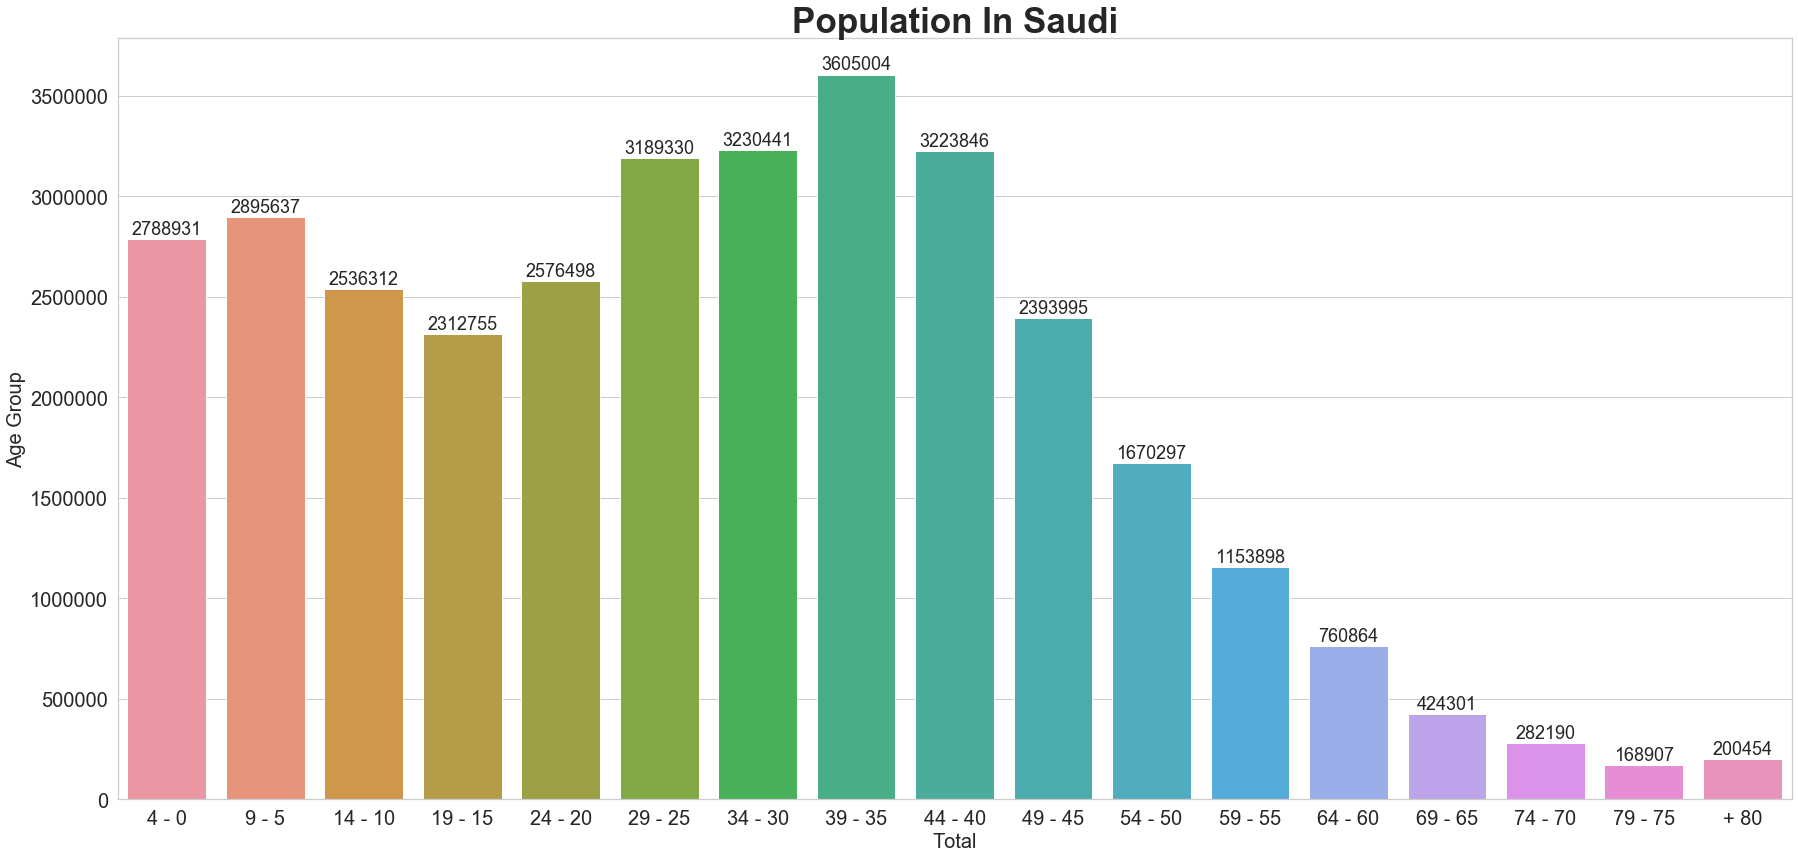

In [1596]:
plt.figure(figsize = (30, 14))
plt.title('Population In Saudi', fontsize = 35, weight='bold')
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)
ax = sns.barplot(x="age_group", y="Total",  data=saudi_population)

plt.yticks(fontsize =20)
plt.xticks(fontsize =20)
plt.ylabel('Age Group', fontsize =20)
plt.xlabel('Total', fontsize =20)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

### Hospitalization, intensive care unit (ICU) admission, and case–fatality percentages for reported COVID–19 cases, by age group —United States

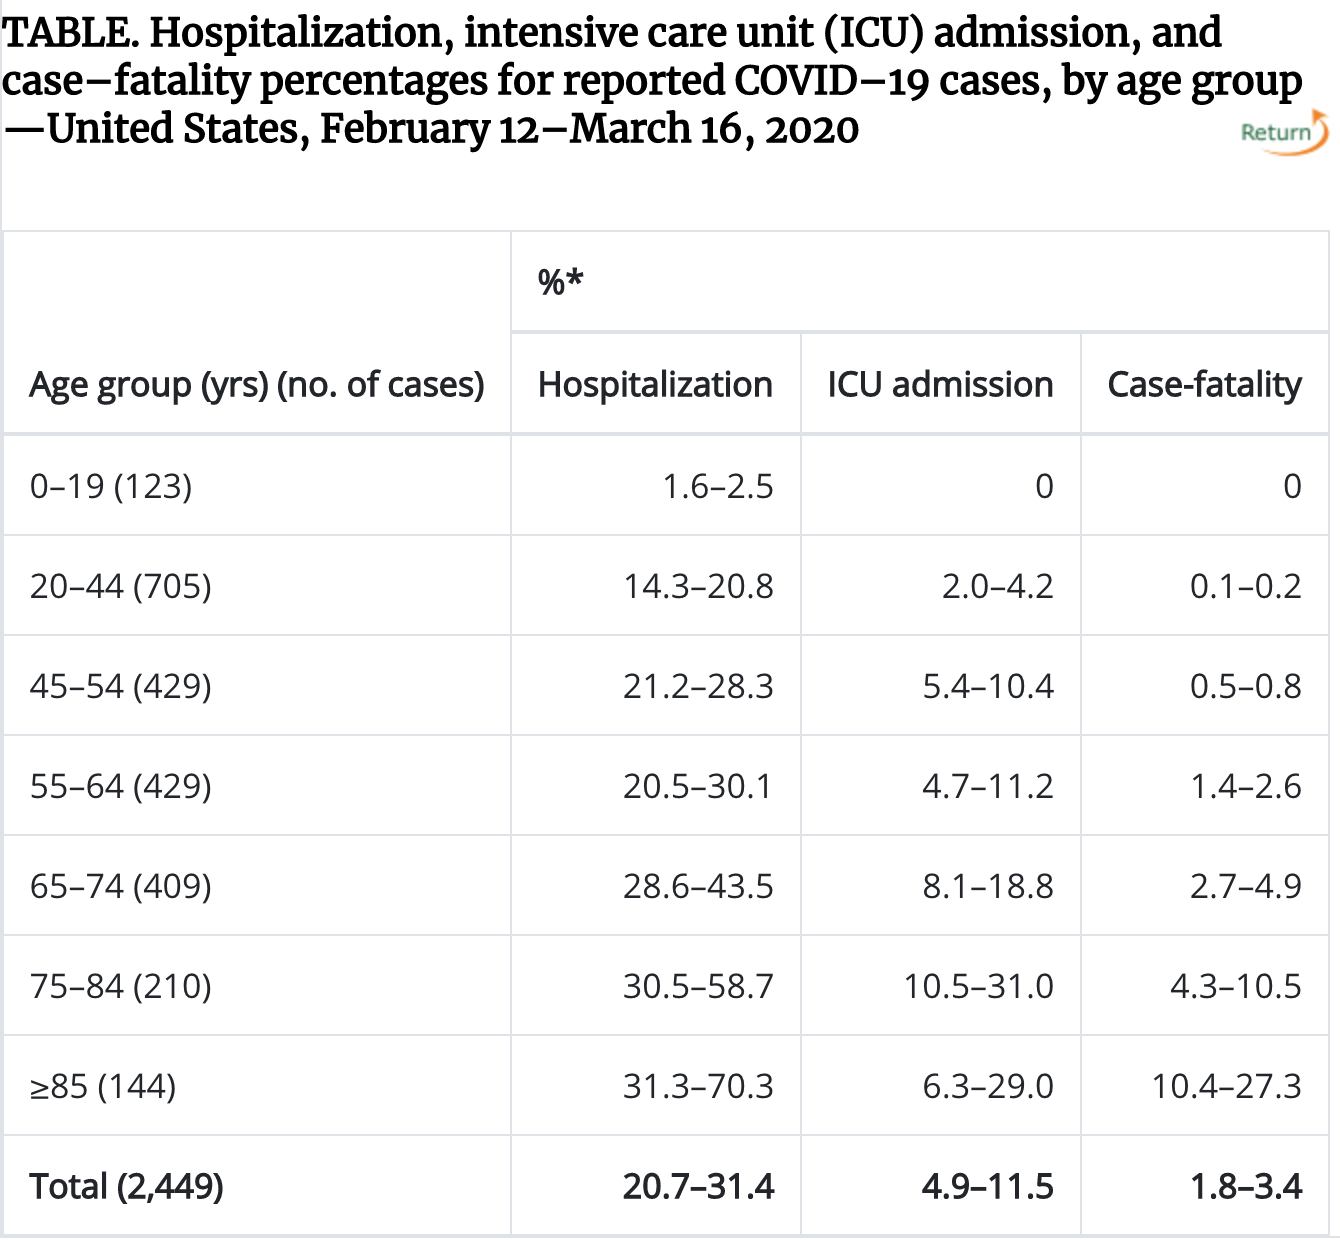

In [1178]:
from IPython.display import Image
Image("hospitalization-icu-cdc.png", width=500, height=500)

### Saudi Estimation

In [1328]:
sa_population = sum(saudi_population.Total)

us_data = {
'Hospitalization': ['1.6-2.5', '14.3-20.8', '21.2-28.3', '20.5-30.1', '28.6-43.5', '30.5-58.7', '31.3-70.3'],
'ICU admission': ['0', '2.0-4.2', '5.4-10.4', '4.7-11.2', '8.1-18.8', '10.5-31.0', '6.3-29.0'],
'Case-fatality': ['0', '0.1-0.2', '0.5-0.8','1.4-2.6', '2.7-4.9', '4.3-10.5', '10.4-27.3']
}
        
def calc_Hospitalization_rate(age, population, case, i):
    if us_data[case][i] == '0':
        return 0
    
    rate_lower = float(us_data[case][i].split(('-'))[0]) / 10
    rate_upper = float(us_data[case][i].split(('-'))[1]) / 10


    rate_lower = (population * rate_lower) / sa_population
    rate_upper = (population * rate_upper) / sa_population

    
    return '{}-{}'.format("%.2f" % rate_lower , "%.2f" % rate_upper)


In [1180]:
sa_data = {
    'Age Group': ['0-19', '20-44', '45-54', '55-64', '65-74', '75-84', '>84'],
    'total': [
        sum(saudi_population.Total[0:4]), 
        sum(saudi_population.Total[4:9]),
        sum(saudi_population.Total[9:11]),
        sum(saudi_population.Total[11:13]),
        sum(saudi_population.Total[13:15]),
        sum(saudi_population.Total[15:16]),
        saudi_population.Total[16]
    ],
    'Hospitalization': 0,
    'ICU admission': 0,
    'Case-fatality': 0
} 

us_data = {
    'Age Group': ['0-19', '20-44', '45-54', '55-64', '65-74', '75-84', '>84'],
    'Hospitalization': ['1.6-2.5', '14.3-20.8', '21.2-28.3', '20.5-30.1', '28.6-43.5', '30.5-58.7', '31.3-70.3'],
    'ICU admission': ['0', '2.0-4.2', '5.4-10.4', '4.7-11.2', '8.1-18.8', '10.5-31.0', '6.3-29.0'],
    'Case-fatality': ['0', '0.1-0.2', '0.5-0.8','1.4-2.6', '2.7-4.9', '4.3-10.5', '10.4-27.3']
}

us_hospitalized_distribution = pd.DataFrame(us_data) 

sa_hospitalized_distribution = pd.DataFrame(sa_data) 
us_hospitalized_distribution

Age Group Hospitalization ICU admission Case-fatality
0      0-19         1.6-2.5             0             0
1     20-44       14.3-20.8       2.0-4.2       0.1-0.2
2     45-54       21.2-28.3      5.4-10.4       0.5-0.8
3     55-64       20.5-30.1      4.7-11.2       1.4-2.6
4     65-74       28.6-43.5      8.1-18.8       2.7-4.9
5     75-84       30.5-58.7     10.5-31.0      4.3-10.5
6       >84       31.3-70.3      6.3-29.0     10.4-27.3

In [1181]:
cases = ['Hospitalization', 'ICU admission', 'Case-fatality']
age_group = ['0-19', '20-44', '45-54', '55-64', '65-74', '75-84', '>84']
    
for case in cases:
    i = 0
    for age in age_group:
        sa_hospitalized_distribution[case][sa_hospitalized_distribution['Age Group'] == age] = calc_Hospitalization_rate(age, sa_hospitalized_distribution['total'][i], case, i)
        i = i + 1
sa_hospitalized_distribution

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Age Group     total Hospitalization ICU admission Case-fatality
0      0-19  10533635       0.05-0.08             0             0
1     20-44  15825119       0.68-0.99     0.09-0.20     0.00-0.01
2     45-54   4064292       0.26-0.34     0.07-0.13     0.01-0.01
3     55-64   1914762       0.12-0.17     0.03-0.06     0.01-0.01
4     65-74    706491       0.06-0.09     0.02-0.04     0.01-0.01
5     75-84    168907       0.02-0.03     0.01-0.02     0.00-0.01
6       >84    200454       0.02-0.04     0.00-0.02     0.01-0.02

In [1351]:
hospitalization = sa_hospitalized_distribution['Hospitalization'].str.split('-')
icu_admission = sa_hospitalized_distribution['ICU admission'].str.split('-')
case_fatality = sa_hospitalized_distribution['Case-fatality'].str.split('-')

hospitalization_lower = 0
hospitalization_upper = 0

icu_admission_lower = 0
icu_admission_upper = 0

case_fatality_lower = 0
case_fatality_upper = 0

for i in range(0,6):
    hospitalization_lower = hospitalization_lower + float(hospitalization[i][0])
    hospitalization_upper = hospitalization_upper + float(hospitalization[i][1])
    try:
        icu_admission_lower = icu_admission_lower + float(icu_admission[i][0])
        icu_admission_upper = icu_admission_upper + float(icu_admission[i][1])

        case_fatality_lower = case_fatality_lower + float(case_fatality[i][0])
        case_fatality_upper = case_fatality_upper + float(case_fatality[i][1])
    except TypeError:
        icu_admission_lower = icu_admission_lower + 0
        icu_admission_upper = icu_admission_upper + 0

        case_fatality_lower = case_fatality_lower + 0
        case_fatality_upper = case_fatality_upper + 0

In [1357]:
hospital_beds = sum(MOH_hospital_beds.hospital_beds)
available_beds = hospital_beds * 0.25
hosp_lower_cap = available_beds / hospitalization_lower
hosp_upper_cap = available_beds / hospitalization_upper
print(hosp_lower_cap)
print(hosp_upper_cap)

9176.470588235294
6423.529411764705


In [1358]:
print(icu_admission_lower)
print(icu_admission_upper)

0.22
0.45


In [1359]:
print(case_fatality_lower)
print(case_fatality_upper)

0.03
0.05


In [1182]:
def seven_days_total(date, location):
    min_date = date - datetime.timedelta(days=7)
    total = 0
    i = 0
#     while corona_cases[(corona_cases.location == location) & (corona_cases.date >= date)]:
    while date >= min_date:
        if corona_cases[(corona_cases.location == location) & (corona_cases.date == min_date)].empty:
            min_date = min_date + datetime.timedelta(days=1)
        else:
            i = i + 1
            total = total + int(corona_cases.total_cases[(corona_cases.location == location) & (corona_cases.date == min_date)])
            min_date = min_date + datetime.timedelta(days=1)
            
    return total/i
                

In [1773]:
# saudi = corona_cases[corona_cases.location == 'Saudi Arabia']
# saudi['new_7day_avg'] = saudi.apply(lambda x: new_cases(x['date'], x['total_cases'], location=x['location']), axis=1)
saudi = pd.read_excel('../data/saudi_cases.xlsx')
saudi['new_7day_avg'] = saudi.new_cases.rolling(window=7).mean()
saudi['total_7day_avg'] = saudi.total_cases.rolling(window=7).mean()
saudi = saudi[~saudi.total_7day_avg.isna()]
saudi

date  total_cases  new_cases  imported  local  unknown  new_7day_avg  \
6  2020-03-08           11          4       1.0    3.0        0      1.571429   
7  2020-03-09           15          4       3.0    1.0        0      2.000000   
8  2020-03-10           20          5       4.0    1.0        0      2.714286   
9  2020-03-11           45         25       3.0   22.0        0      6.142857   
10 2020-03-12           62         17       5.0   12.0        0      8.142857   
11 2020-03-13           86         24       2.0   22.0        0     11.571429   
12 2020-03-14          103         17      12.0    5.0        0     13.714286   
13 2020-03-15          118         15       8.0    7.0        0     15.285714   
14 2020-03-16          133         15      13.0    2.0        0     16.857143   
15 2020-03-17          171         38      32.0    6.0        0     21.571429   
16 2020-03-18          238         67      45.0   11.0       11     27.571429   
17 2020-03-19          274         36      17.0   19.0        0     30.285714   
18 2020-03-20          344         70      11.0   59.0        0     36.857143   
19 2020-03-21          392         48       NaN    5.0        0     41.285714   
20 2020-03-22          511        119       NaN    NaN        0     56.142857   
21 2020-03-23          562         51       NaN    NaN        0     61.285714   
22 2020-03-24          767        205     119.0   86.0        0     85.142857   
23 2020-03-25          900        133      18.0  115.0        0     94.571429   
24 2020-03-26         1012        112      12.0  100.0        0    105.428571   
25 2020-03-27         1104         92      10.0   82.0        0    108.571429   
26 2020-03-28         1203         99      10.0   89.0        0    115.857143   
27 2020-03-29         1299         96      28.0   68.0        0    112.571429   
28 2020-03-30         1453        154      16.0  138.0        0    127.285714   

    total_7day_avg  
6         4.571429  
7         6.571429  
8         9.285714  
9        15.428571  
10       23.571429  
11       35.142857  
12       48.857143  
13       64.142857  
14       81.000000  
15      102.571429  
16      130.142857  
17      160.428571  
18      197.285714  
19      238.571429  
20      294.714286  
21      356.000000  
22      441.142857  
23      535.714286  
24      641.142857  
25      749.714286  
26      865.571429  
27      978.142857  
28     1105.428571

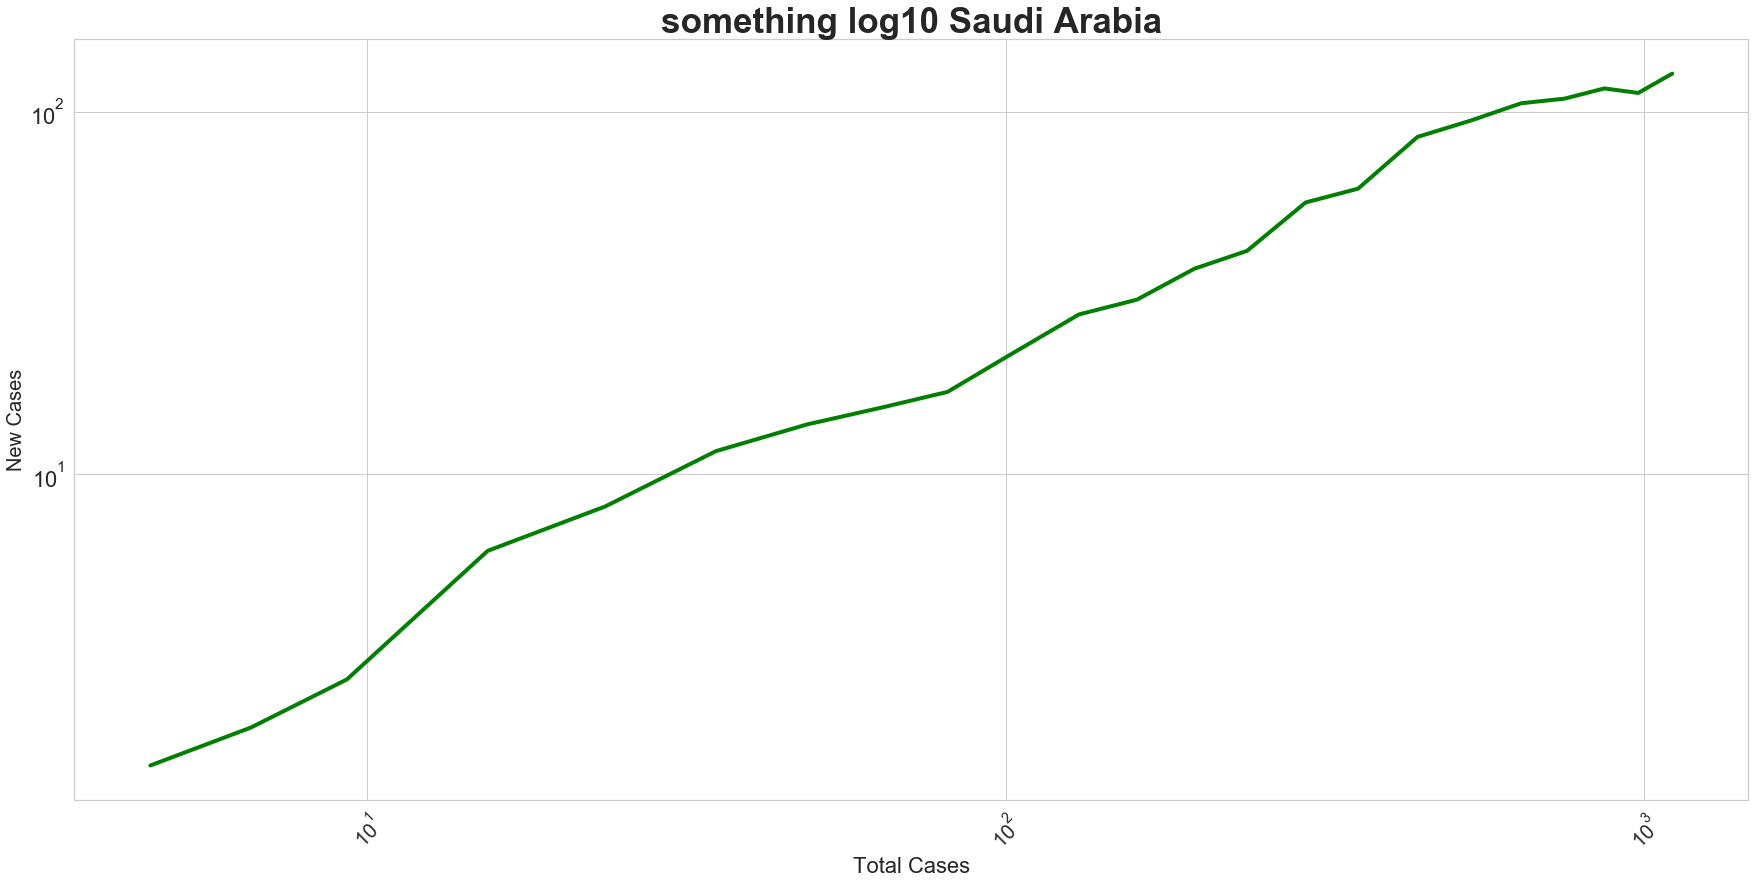

In [1774]:
plt.figure(figsize = (30, 14))

ax = sns.lineplot(x="total_7day_avg", y="new_7day_avg", legend=False,  data=saudi, linewidth=4, color='green')
ax.set_xscale('log')
ax.set_yscale('log')
sns.set_style("whitegrid")

plt.title('something log10 Saudi Arabia', fontsize = 35, weight='bold')

plt.xticks(fontsize =20, rotation=45)
plt.yticks(fontsize =22)


plt.ylabel('New Cases', fontsize =20)
plt.xlabel('Total Cases', fontsize =22);



In [1779]:
countries = ['Saudi Arabia', 'Korea, South', 'Italy', 'Spain', 'Japan']

csikus = corona_cases[corona_cases.location.isin(countries)]
csikus['new_cases'] = csikus.apply(lambda x: new_cases(x['date'], x['total_cases'], location=x['location']), axis=1)
csikus['new_7day'] = csikus.groupby('location').new_cases.rolling(window=7).sum().reset_index(0).new_cases
# csikus['total_7day_avg'] = csikus.total_cases.rolling(window=7).mean()
# csikus = csikus[~csikus.total_7day_avg.isna()]
csikus = csikus[~csikus.new_7day.isna()]
csikus

/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/mohammedalawami/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


province      location   Lat   Long       date  total_cases  new_cases  \
250         0  Korea, South  36.0  128.0 2020-01-28            4          0   
255         0         Japan  36.0  138.0 2020-01-28            7          3   
300         0  Korea, South  36.0  128.0 2020-01-29            4          0   
306         0         Japan  36.0  138.0 2020-01-29            7          0   
355         0  Korea, South  36.0  128.0 2020-01-30            4          0   
...       ...           ...   ...    ...        ...          ...        ...   
7863        0  Saudi Arabia  24.0   45.0 2020-03-29         1299         96   
7873        0         Japan  36.0  138.0 2020-03-29         1866        173   
7889        0  Korea, South  36.0  128.0 2020-03-29         9583        105   
7898        0         Spain  40.0   -4.0 2020-03-29        80110       6875   
7899        0         Italy  43.0   12.0 2020-03-29        97689       5217   

      new_7day  
250        4.0  
255        7.0  
300        3.0  
306        5.0  
355        3.0  
...        ...  
7863     788.0  
7873     765.0  
7889     622.0  
7898   51342.0  
7899   38551.0  

[251 rows x 8 columns]

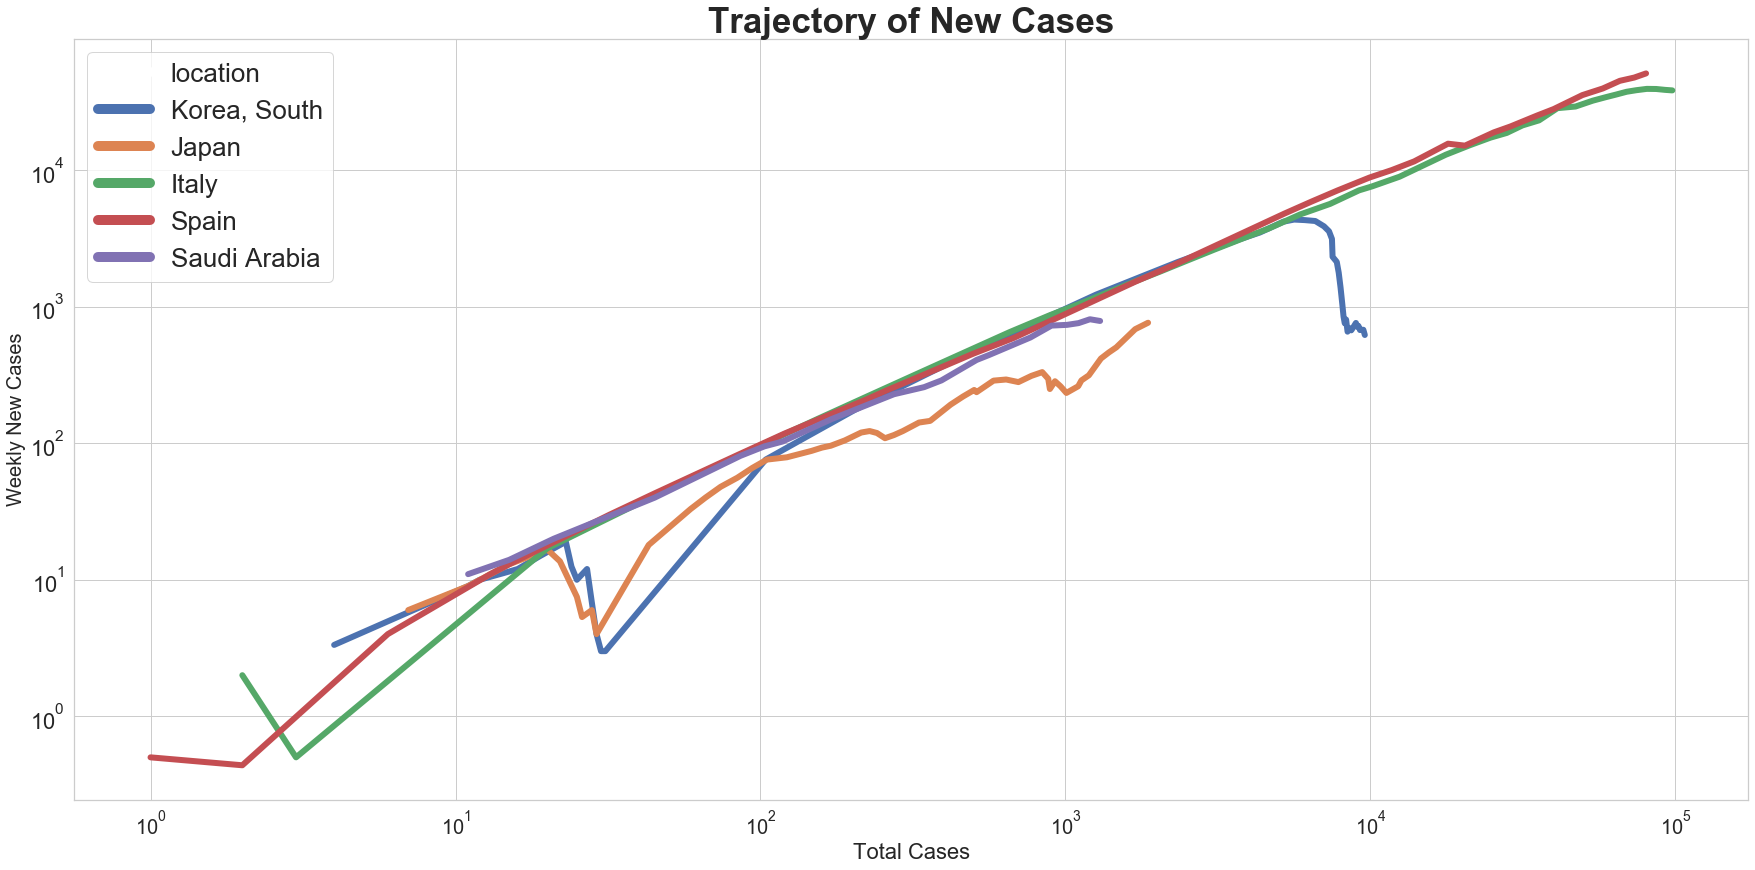

In [1780]:
plt.figure(figsize = (30, 14))

ax = sns.lineplot(x="total_cases", y="new_7day", hue="location", ci=False, legend='full',  data=csikus, linewidth=6 )
ax.set_xscale('log')
ax.set_yscale('log')
sns.set_style("whitegrid")
plt.title('Trajectory of New Cases', fontsize = 35, weight='bold')

plt.xticks(fontsize =20)
plt.yticks(fontsize =22)


plt.ylabel('Weekly New Cases', fontsize =20)
plt.xlabel('Total Cases', fontsize =22);


leg = ax.legend(prop={'size':26});

for line in leg.get_lines():
    line.set_linewidth(10)

### Curve Fitting

In [1607]:
from scipy.optimize import curve_fit

In [1781]:
# saudi = gulf_countries[gulf_countries.location == 'Saudi Arabia'].sort_values('date').reset_index()
saudi = pd.read_excel('../data/saudi_cases.xlsx')
saudi['day_num'] = saudi.index + 1
saudi

date  total_cases  new_cases  imported  local  unknown  day_num
0  2020-03-02            1          1       1.0    0.0        0        1
1  2020-03-03            1          0       0.0    0.0        0        2
2  2020-03-04            2          1       1.0    0.0        0        3
3  2020-03-05            5          3       3.0    NaN        0        4
4  2020-03-06            5          0       0.0    0.0        0        5
5  2020-03-07            7          2       2.0    0.0        0        6
6  2020-03-08           11          4       1.0    3.0        0        7
7  2020-03-09           15          4       3.0    1.0        0        8
8  2020-03-10           20          5       4.0    1.0        0        9
9  2020-03-11           45         25       3.0   22.0        0       10
10 2020-03-12           62         17       5.0   12.0        0       11
11 2020-03-13           86         24       2.0   22.0        0       12
12 2020-03-14          103         17      12.0    5.0        0       13
13 2020-03-15          118         15       8.0    7.0        0       14
14 2020-03-16          133         15      13.0    2.0        0       15
15 2020-03-17          171         38      32.0    6.0        0       16
16 2020-03-18          238         67      45.0   11.0       11       17
17 2020-03-19          274         36      17.0   19.0        0       18
18 2020-03-20          344         70      11.0   59.0        0       19
19 2020-03-21          392         48       NaN    5.0        0       20
20 2020-03-22          511        119       NaN    NaN        0       21
21 2020-03-23          562         51       NaN    NaN        0       22
22 2020-03-24          767        205     119.0   86.0        0       23
23 2020-03-25          900        133      18.0  115.0        0       24
24 2020-03-26         1012        112      12.0  100.0        0       25
25 2020-03-27         1104         92      10.0   82.0        0       26
26 2020-03-28         1203         99      10.0   89.0        0       27
27 2020-03-29         1299         96      28.0   68.0        0       28
28 2020-03-30         1453        154      16.0  138.0        0       29

In [1782]:
def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

In [1783]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

In [1786]:
x = saudi["day_num"][saudi.day_num < 25]
y = saudi["total_cases"][saudi.day_num < 25]
epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
eerror = np.sqrt(np.diag(epcov))

In [1636]:
# exponential(x, *epopt)

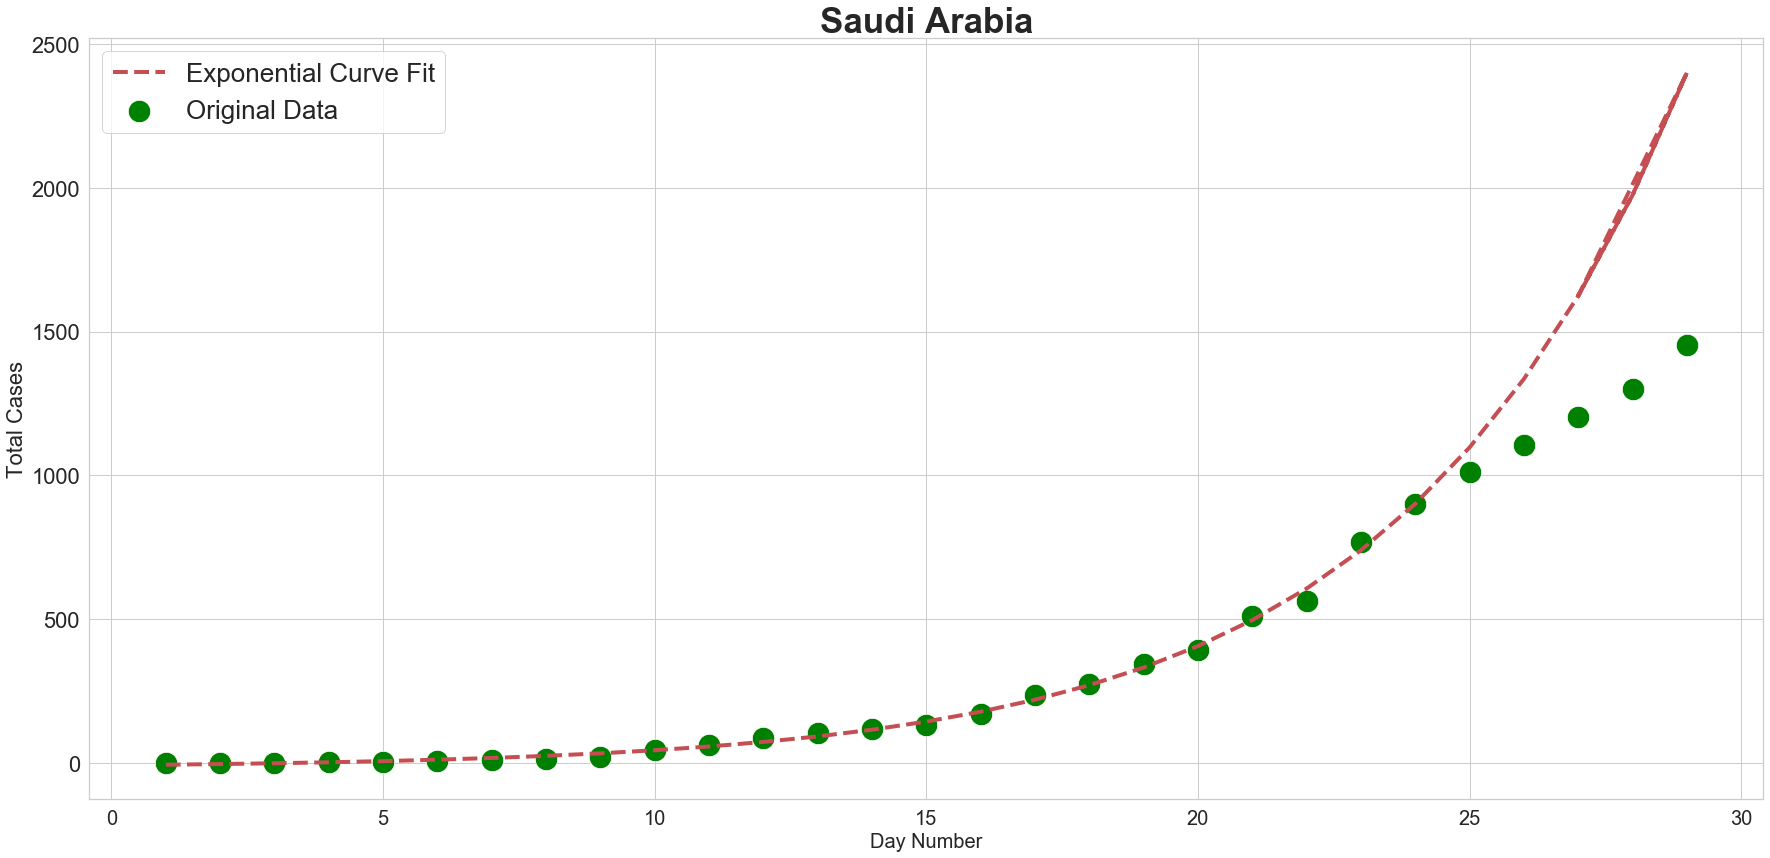

In [1787]:
plt.figure(figsize = (30, 14))
plt.title('Saudi Arabia', fontsize = 35, weight='bold')

ax = sns.scatterplot(x="day_num", y="total_cases", legend=False, data=saudi, s=500, label="Original Data", palette=['green'], color='green')
sns.set_style("whitegrid")

x = saudi["day_num"].append(pd.Series([27, 28, 29]))
plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit", linewidth=4);

plt.xticks(fontsize =20, )
plt.yticks(fontsize =22)

plt.xlabel('Day Number', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=26);


In [1789]:
x = saudi["day_num"]
y = saudi["total_cases"]
epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
eerror = np.sqrt(np.diag(epcov))

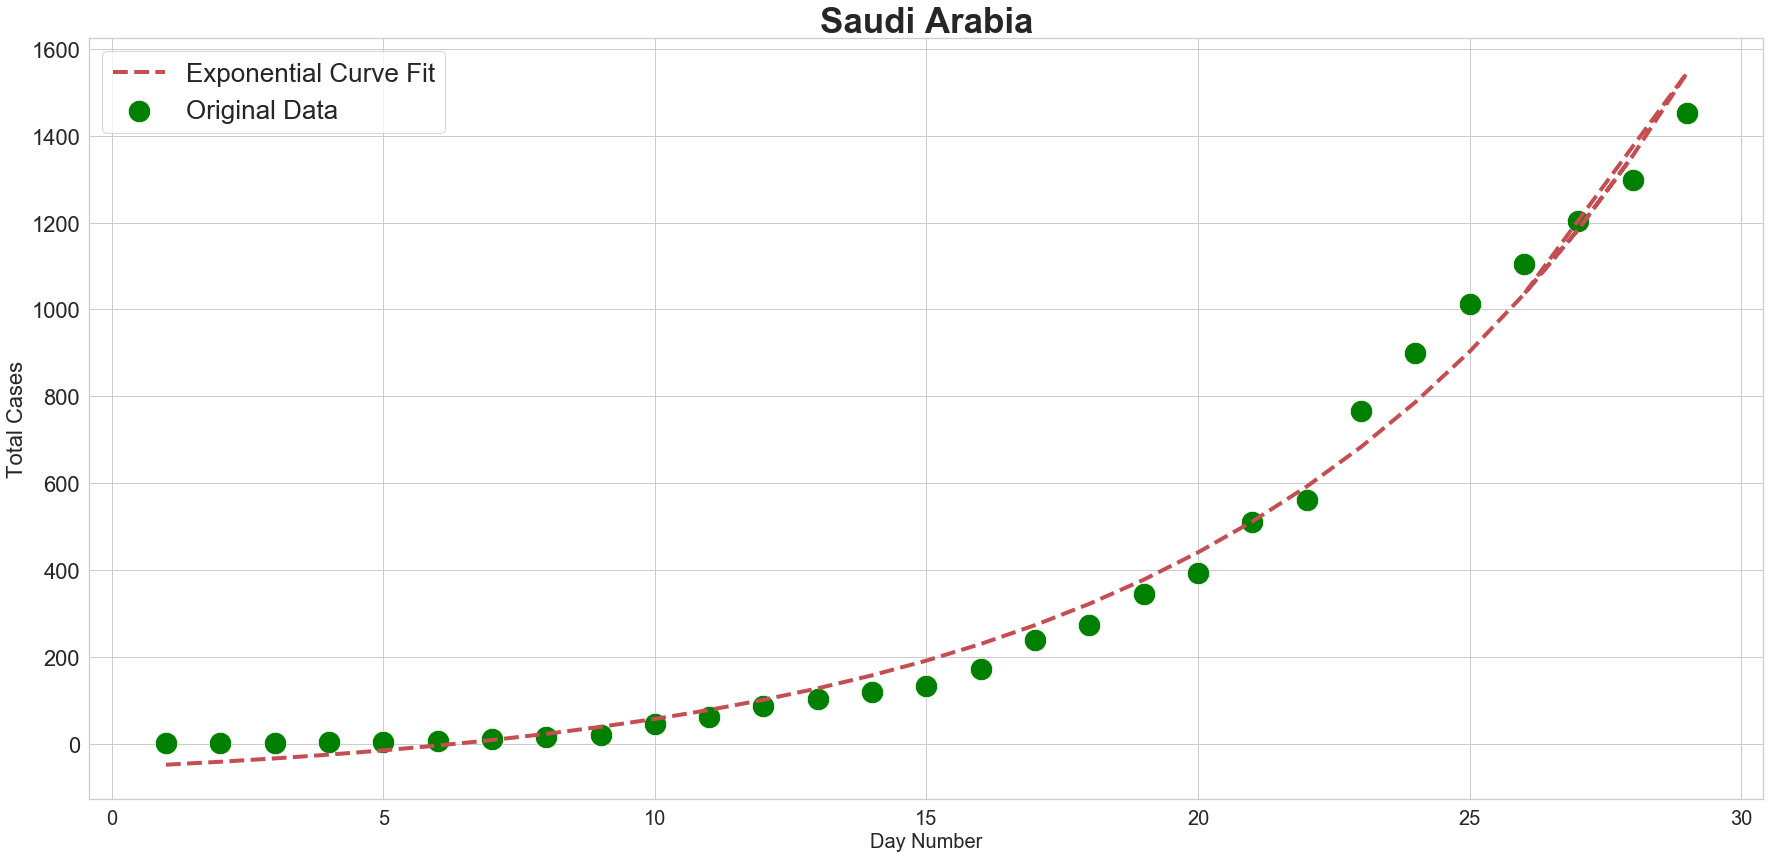

In [1790]:
plt.figure(figsize = (30, 14))
plt.title('Saudi Arabia', fontsize = 35, weight='bold')

ax = sns.scatterplot(x="day_num", y="total_cases", legend=False,  data=saudi, s=500, label="Original Data", palette=['green'], color='green')
sns.set_style("whitegrid")

x = saudi["day_num"].append(pd.Series([26, 27, 28]))
plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit", linewidth=4);

plt.xticks(fontsize =20, )
plt.yticks(fontsize =22)

plt.xlabel('Day Number', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=26);



### Logistic, (didn't work)

In [1791]:
x = saudi["day_num"]
y = saudi["total_cases"]
lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
lerror = np.sqrt(np.diag(lpcov))

In [1792]:
# for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
ldoubletime = np.log(2)/(lpopt[1]/2)
# standard error
ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
# calculate R^2
residuals = y - logistic(x, *lpopt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
logisticr2 = 1 - (ss_res / ss_tot)

In [1793]:
logisticr2

0.9979309313612875

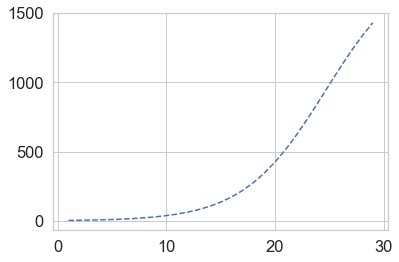

In [1794]:
plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")

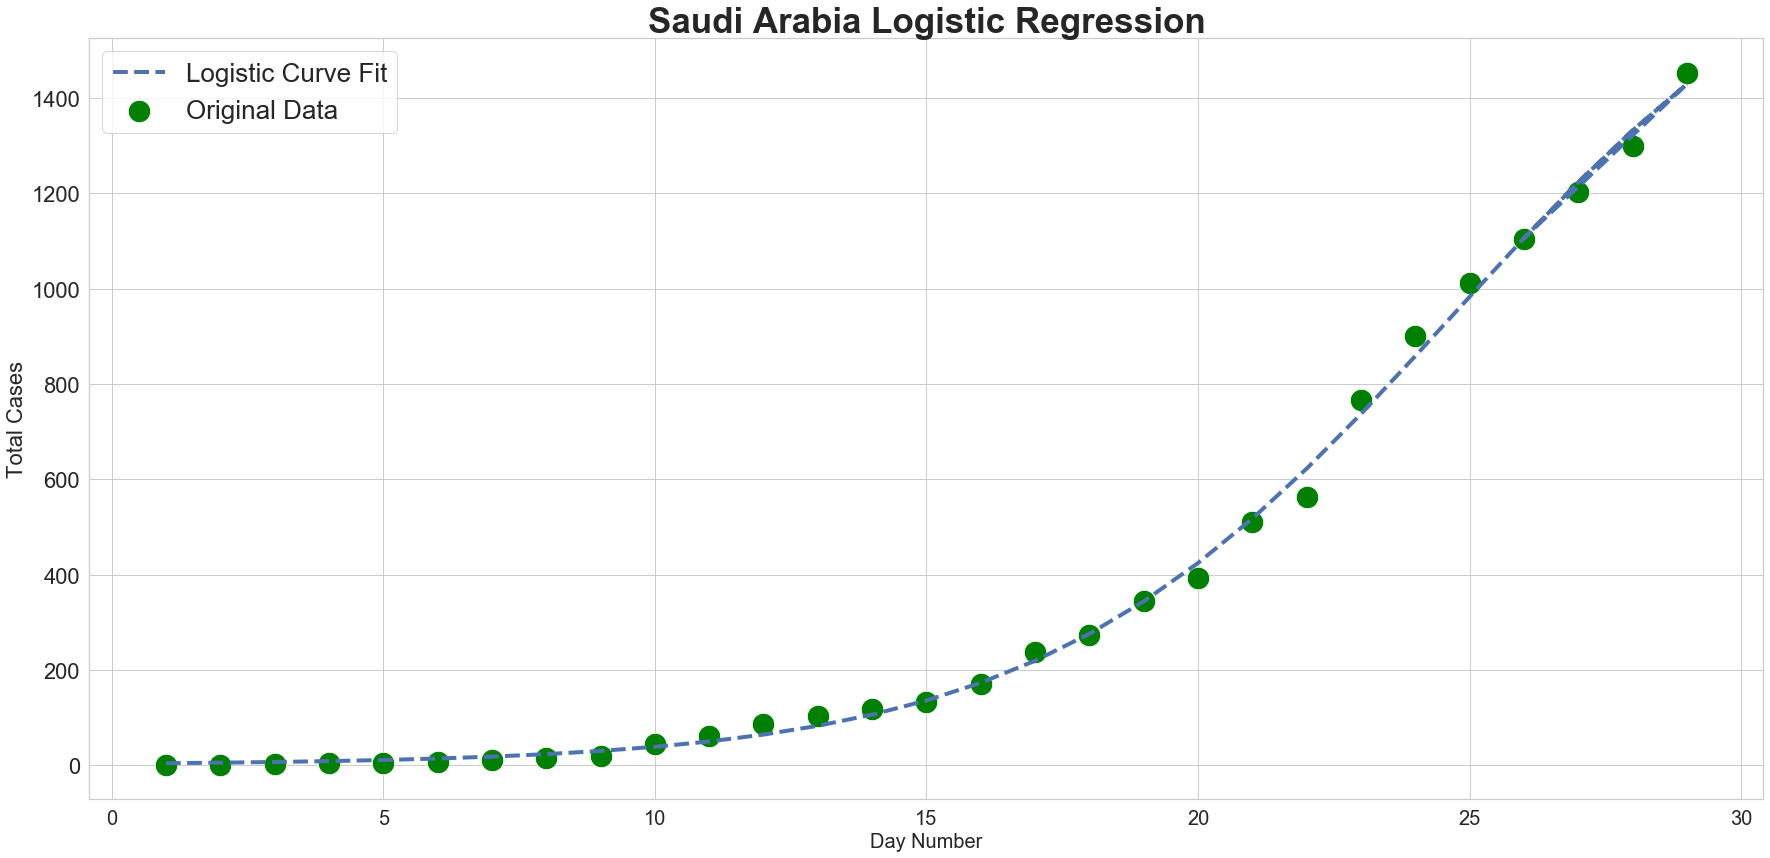

In [1795]:
plt.figure(figsize = (30, 14))
plt.title('Saudi Arabia Logistic Regression', fontsize = 35, weight='bold')

ax = sns.scatterplot(x="day_num", y="total_cases", legend=False,  data=saudi, s=500, label="Original Data", color='green', palette=['green'])
sns.set_style("whitegrid")

x = saudi["day_num"].append(pd.Series([26, 27, 28, 29]))
plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit",  linewidth=4);

plt.xticks(fontsize =20, )
plt.yticks(fontsize =22)

plt.xlabel('Day Number', fontsize =20)
plt.ylabel('Total Cases', fontsize =22)
plt.legend(fontsize=26);